In [1]:
%%javascript 
IPython.notebook.kernel.execute('nb_name = "' + IPython.notebook.notebook_name + '"')

<IPython.core.display.Javascript object>

In [2]:
# lib
import os
import gc
import random
import math
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.optimizer import Optimizer
from torch.utils.data import DataLoader, Dataset
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')

import warnings
warnings.filterwarnings("ignore")

from fastprogress import master_bar, progress_bar
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

if not os.path.exists('models1'):
    os.mkdir('models1')


def seed_everything(seed=777):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


SEED = 777
seed_everything(SEED)

torch.__version__

'1.7.0'

In [3]:
data_path = '../input/lish-moa/'

In [4]:
def get_logger(filename='log', save=True):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    
    if save:
        handler2 = FileHandler(filename=f"{filename}.log")
        handler2.setFormatter(Formatter("%(message)s"))  
        logger.addHandler(handler2)
    return logger

logger = get_logger(nb_name[:-6])
logger.info(f'file_name: {nb_name[:-6]}')
logger.info(f'Time: {time.ctime()}')
logger.info(f'Set seed: {SEED}')

file_name: 01_baseline-opt-CosineAnnealingWarmRestarts-wd
Time: Tue Nov 17 20:03:16 2020
Set seed: 777


# load df

In [5]:
# load df
# train_df
trn_feature = pd.read_csv(data_path + 'train_features.csv')
print(trn_feature.shape)

# train_df_target
trn_tar_df = pd.read_csv(data_path + 'train_targets_scored.csv')
print(trn_tar_df.shape)

# test_df
test_df = pd.read_csv(data_path + 'test_features.csv')
print(test_df.shape)

# sub_df
sub_df = pd.read_csv(data_path + 'sample_submission.csv')
print(sub_df.shape)

# label column keys
y_keys = list(trn_tar_df.keys())[1:];

# numerical col
genes = [col for col in trn_feature.columns if col.startswith('g-')]
cells = [col for col in trn_feature.columns if col.startswith('c-')]

# catgoriacal col
cat_col = ['cp_time', 'cp_dose']

(23814, 876)
(23814, 207)
(3982, 876)
(3982, 207)


In [6]:
# create df without ctl_vehicle in cp_type
trn_df = trn_feature.merge(trn_tar_df, on='sig_id')
trn_df = trn_df[trn_df.cp_type !='ctl_vehicle'].reset_index(drop=True)
test_df = test_df[test_df.cp_type !='ctl_vehicle'].reset_index(drop=True)
print(trn_df.shape, test_df.shape)
trn_df.sample(20)

(21948, 1082) (3624, 876)


sig_id cp_type  cp_time cp_dose     g-0     g-1     g-2     g-3  \
14261  id_a6a4f3626  trt_cp       24      D2 -0.3265  0.1577 -0.3381  0.1789   
14266  id_a6b456ebb  trt_cp       24      D1 -0.7239  0.0713  0.2250  0.5864   
5119   id_3bd739795  trt_cp       24      D1  0.5283  1.2350  2.7150 -0.0206   
692    id_07b7426b2  trt_cp       24      D1 -0.2856 -0.6573  1.8890 -0.3083   
6833   id_4fbf1ada4  trt_cp       72      D2  0.9492 -0.5027 -0.0934 -2.2830   
7051   id_52620ac73  trt_cp       24      D1 -0.4717 -0.2592 -0.5129  0.0462   
13131  id_995a3b2d4  trt_cp       48      D1  2.4190 -1.1380 -0.4596 -0.1602   
2435   id_1c33757b3  trt_cp       24      D1 -0.0171 -0.0432 -0.4036 -0.6486   
10021  id_7514b50fb  trt_cp       48      D1  0.5772  0.8006  1.5080 -0.8161   
13768  id_a0ad27715  trt_cp       48      D2  0.2120  0.2485  1.0300 -1.0730   
18518  id_d7bb3adc4  trt_cp       48      D1 -0.7536 -0.5321 -0.1516 -0.0495   
20041  id_e91fab646  trt_cp       72      D2 -0.6309  0.4781 -2.6910  0.2385   
18117  id_d31c9e94e  trt_cp       48      D1  0.7976  1.0440  0.2952 -0.5905   
15504  id_b4cc111bb  trt_cp       48      D1 -0.5976 -1.1690 -0.4103  0.5798   
5556   id_412140e64  trt_cp       24      D1 -0.5952 -0.9559  2.4630 -0.0315   
21588  id_fbd8dbcad  trt_cp       72      D2 -0.2161 -1.4290  0.4589  1.0030   
15360  id_b31db9325  trt_cp       48      D1 -0.0374 -1.0160  1.9580 -0.4785   
11138  id_821c17c40  trt_cp       24      D2 -0.0261  0.1104 -0.1617 -0.3219   
8190   id_60006934f  trt_cp       48      D1  0.1364 -1.3170 -0.8553  0.1797   
2259   id_1a17c635a  trt_cp       72      D1 -1.0280 -0.8049 -1.0320  0.1032   

          g-4     g-5  ...  tropomyosin_receptor_kinase_inhibitor  \
14261  0.2595  0.7117  ...                                      0   
14266  2.6280 -0.4762  ...                                      0   
5119   0.5865  0.2824  ...                                      0   
692   -0.5899  0.5369  ...                                      0   
6833  -0.1903  0.0230  ...                                      0   
7051   0.5863 -0.6585  ...                                      0   
13131  2.5480  1.5230  ...                                      0   
2435  -0.7183 -0.5947  ...                                      0   
10021 -0.1879 -0.1965  ...                                      0   
13768 -0.0180 -1.7210  ...                                      0   
18518  1.0390  0.0809  ...                                      0   
20041 -0.3716 -1.7600  ...                                      0   
18117 -0.1289 -0.0398  ...                                      0   
15504 -1.1120 -0.5922  ...                                      0   
5556  -1.1080 -0.4219  ...                                      1   
21588 -0.4092 -0.3814  ...                                      0   
15360 -1.9240  0.4834  ...                                      0   
11138 -0.3690 -0.3912  ...                                      0   
8190  -0.3682  0.3688  ...                                      0   
2259  -1.0780  0.4771  ...                                      0   

       trpv_agonist  trpv_antagonist  tubulin_inhibitor  \
14261             0                0                  0   
14266             0                0                  0   
5119              0                0                  0   
692               0                0                  0   
6833              0                0                  0   
7051              0                0                  0   
13131             0                0                  0   
2435              0                0                  0   
10021             0                0                  0   
13768             0                0                  0   
18518             0                0                  0   
20041             0                0                  0   
18117             0                0                  0   
15504             0                0                  0 

# cv

In [7]:
# kfolds index
folds = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
for n, (trn_idx, val_idx) in enumerate(folds.split(trn_df, trn_df[y_keys])):
    print(trn_idx, val_idx)

[    0     1     2 ... 21945 21946 21947] [    3    15    21 ... 21939 21942 21944]
[    1     2     3 ... 21944 21945 21947] [    0     4     7 ... 21934 21936 21946]
[    0     2     3 ... 21945 21946 21947] [    1    14    18 ... 21928 21940 21943]
[    0     1     2 ... 21944 21946 21947] [    8     9    10 ... 21920 21932 21945]
[    0     1     3 ... 21944 21945 21946] [    2     5     6 ... 21937 21941 21947]


# dataset

In [8]:
class TrainDataset(Dataset):
    def __init__(self, df, features_col, labels_col):
        self.features = torch.FloatTensor(df[features_col].values).to(device)
        self.labels = torch.tensor(df[labels_col].values).float().to(device)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        x = self.features[idx]
        y = self.labels[idx]

        return x, y


class TestDataset(Dataset):
    def __init__(self, df, features_col):
        self.features = torch.FloatTensor(df[features_col].values)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        x = self.features[idx].to(device)

        return x

In [9]:
cat_features = ['cp_time', 'cp_dose']
feature_cols = genes + cells + cat_features


def cate2num(df):
    df['cp_time'] = df['cp_time'].map({24: 0, 48: 1, 72: 2})
    df['cp_dose'] = df['cp_dose'].map({'D1': 1, 'D2': 0})
    return df


trn_df = cate2num(trn_df)
test_df = cate2num(test_df)

In [10]:
# debug ds, dl
trn_dataset = TrainDataset(trn_df.iloc[trn_idx], feature_cols, y_keys)
test_dataset = TestDataset(test_df, feature_cols)

trn_loader = DataLoader(trn_dataset,
                        batch_size=32,
                        shuffle=True,
                        drop_last=True)
test_loader = DataLoader(test_dataset,
                         batch_size=32,
                         shuffle=False,
                         drop_last=False)

for xs, ys in trn_loader: 
    print(xs.shape, ys.shape)
    break
for xs in test_loader: 
    print(xs.shape)
    break

torch.Size([32, 874]) torch.Size([32, 206])
torch.Size([32, 874])


# model

In [11]:
class CFG:
    max_grad_norm = 1000
    hidden_size = 256
    dropout = 0.5
    lr = 7e-3
    wd = 1e-3
    bs = 32
    epochs = 30
    smooth = 0.0005
    feature_cols = feature_cols
    target_cols = y_keys
    optimizer = None
    scheduler = None 

In [12]:
class MLP(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.h1 = nn.Sequential(
            nn.Linear(len(cfg.feature_cols), cfg.hidden_size),
            nn.Hardswish(inplace=True),
            nn.BatchNorm1d(cfg.hidden_size), 
            nn.Dropout(cfg.dropout))
        
        self.h2 = nn.Sequential(
            nn.Linear(cfg.hidden_size, cfg.hidden_size),
            nn.Hardswish(inplace=True),
            nn.BatchNorm1d(cfg.hidden_size),
            nn.Dropout(cfg.dropout),
        )
        self.h3 = nn.Linear(cfg.hidden_size, len(cfg.target_cols))

    def forward(self, x):
        x = self.h1(x)
        x = self.h2(x)
        return self.h3(x)

In [13]:
def compute_metric(preds, ys):
    esp = 1e-15
    preds = np.clip(preds, esp, 1 - esp)
    score = -np.mean(np.mean(
        ys * np.log(preds + esp) + (1 - ys) * np.log(1 - preds + esp), axis=1),
                     axis=0)
    return score


def smoothing_critirion(smooth=0.0):
    assert 0 <= smooth < 1, 'smooth not in range'

    def smoothing(criterion):
        def warp(preds, ys):
            with torch.no_grad():
                ys = ys * (1.0 - smooth) + 0.5 * smooth
            return criterion(preds, ys)

        return warp

    return smoothing


@smoothing_critirion(smooth=CFG.smooth)
def criterion(preds, ys):
    return F.binary_cross_entropy_with_logits(preds, ys)

In [14]:
import torch_optimizer

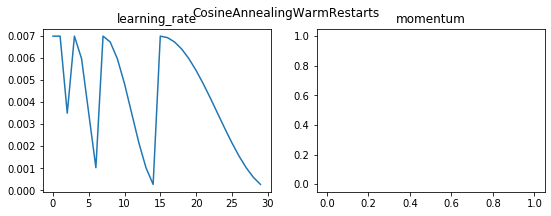

In [15]:
# show_learning_rate_scheduler
#%%capture --no-display
optim_param = {'lr': CFG.lr, 'weight_decay': CFG.wd}
CFG.optimizer = torch_optimizer.Yogi
CFG.optim_param = optim_param

scheduler_param = {
    'T_0': 1, 
    'T_mult': 2, 
    'eta_min': 1e-5, 
}

CFG.scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts
CFG.scheduler_param = scheduler_param


cfg = CFG
model = MLP(cfg).to(device)
optimizer = cfg.optimizer(model.parameters(), **cfg.optim_param)
scheduler = cfg.scheduler(optimizer, **cfg.scheduler_param)

def show_learning_rate_scheduler():
    lrs = []
    moms = []
    if scheduler.__class__.__name__ == 'OneCycleLR':
        step = cfg.epochs* len(trn_loader)
    else:
        step = cfg.epochs
    
    for i in range(step):
        optimizer.step()
        lrs.append(scheduler.optimizer.param_groups[0]['lr'])
        #moms.append(scheduler.optimizer.param_groups[0]['betas'][0])
        scheduler.step()

    plt.figure(figsize=(9, 3))
    plt.suptitle(scheduler.__class__.__name__)
    plt.subplot(121)
    plt.title('learning_rate')
    plt.plot(lrs)
    plt.subplot(122)
    plt.title('momentum')
    plt.plot(moms)


show_learning_rate_scheduler()

# optimizer

In [16]:
from tabulate import tabulate
from colorama import Fore, Back, Style

version_higher = (torch.__version__ >= "1.5.0")

class AdaBelief(Optimizer):
    r"""Implements AdaBelief algorithm. Modified from Adam in PyTorch
    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): learning rate (default: 1e-3)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-16)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        amsgrad (boolean, optional): whether to use the AMSGrad variant of this
            algorithm from the paper `On the Convergence of Adam and Beyond`_
            (default: False)
        weight_decouple (boolean, optional): ( default: True) If set as True, then
            the optimizer uses decoupled weight decay as in AdamW
        fixed_decay (boolean, optional): (default: False) This is used when weight_decouple
            is set as True.
            When fixed_decay == True, the weight decay is performed as
            $W_{new} = W_{old} - W_{old} \times decay$.
            When fixed_decay == False, the weight decay is performed as
            $W_{new} = W_{old} - W_{old} \times decay \times lr$. Note that in this case, the
            weight decay ratio decreases with learning rate (lr).
        rectify (boolean, optional): (default: True) If set as True, then perform the rectified
            update similar to RAdam
        degenerated_to_sgd (boolean, optional) (default:True) If set as True, then perform SGD update
            when variance of gradient is high
    reference: AdaBelief Optimizer, adapting stepsizes by the belief in observed gradients, NeurIPS 2020
    """
    def __init__(self,
                 params,
                 lr=1e-3,
                 betas=(0.9, 0.999),
                 eps=1e-16,
                 weight_decay=0,
                 amsgrad=False,
                 weight_decouple=True,
                 fixed_decay=False,
                 rectify=True,
                 degenerated_to_sgd=True):

        # ------------------------------------------------------------------------------
        # Print modifications to default arguments
        print(
            Fore.RED +
            'Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.'
        )
        print(Fore.RED + 'Modifications to default arguments:')
        default_table = tabulate(
            [['adabelief-pytorch=0.0.5', '1e-8', 'False', 'False'],
             ['Current version (0.1.0)', '1e-16', 'True', 'True']],
            headers=['eps', 'weight_decouple', 'rectify'])
        print(Fore.RED + default_table)

        print(Fore.RED +
              'For a complete table of recommended hyperparameters, see')
        print(Fore.RED +
              'https://github.com/juntang-zhuang/Adabelief-Optimizer')

        print(Style.RESET_ALL)
        # ------------------------------------------------------------------------------

        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(
                betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(
                betas[1]))

        self.degenerated_to_sgd = degenerated_to_sgd
        if isinstance(params,
                      (list, tuple)) and len(params) > 0 and isinstance(
                          params[0], dict):
            for param in params:
                if 'betas' in param and (param['betas'][0] != betas[0]
                                         or param['betas'][1] != betas[1]):
                    param['buffer'] = [[None, None, None] for _ in range(10)]

        defaults = dict(lr=lr,
                        betas=betas,
                        eps=eps,
                        weight_decay=weight_decay,
                        amsgrad=amsgrad,
                        buffer=[[None, None, None] for _ in range(10)])
        super(AdaBelief, self).__init__(params, defaults)

        self.degenerated_to_sgd = degenerated_to_sgd
        self.weight_decouple = weight_decouple
        self.rectify = rectify
        self.fixed_decay = fixed_decay
        if self.weight_decouple:
            print('Weight decoupling enabled in AdaBelief')
            if self.fixed_decay:
                print('Weight decay fixed')
        if self.rectify:
            print('Rectification enabled in AdaBelief')
        if amsgrad:
            print('AMSGrad enabled in AdaBelief')

    def __setstate__(self, state):
        super(AdaBelief, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('amsgrad', False)

    def reset(self):
        for group in self.param_groups:
            for p in group['params']:
                state = self.state[p]
                amsgrad = group['amsgrad']

                # State initialization
                state['step'] = 0
                # Exponential moving average of gradient values
                state['exp_avg'] = torch.zeros_like(p.data,memory_format=torch.preserve_format) \
                    if version_higher else torch.zeros_like(p.data)

                # Exponential moving average of squared gradient values
                state['exp_avg_var'] = torch.zeros_like(p.data,memory_format=torch.preserve_format) \
                    if version_higher else torch.zeros_like(p.data)

                if amsgrad:
                    # Maintains max of all exp. moving avg. of sq. grad. values
                    state['max_exp_avg_var'] = torch.zeros_like(p.data,memory_format=torch.preserve_format) \
                        if version_higher else torch.zeros_like(p.data)

    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError(
                        'AdaBelief does not support sparse gradients, please consider SparseAdam instead'
                    )
                amsgrad = group['amsgrad']

                state = self.state[p]

                beta1, beta2 = group['betas']

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p.data,memory_format=torch.preserve_format) \
                        if version_higher else torch.zeros_like(p.data)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_var'] = torch.zeros_like(p.data,memory_format=torch.preserve_format) \
                        if version_higher else torch.zeros_like(p.data)
                    if amsgrad:
                        # Maintains max of all exp. moving avg. of sq. grad. values
                        state['max_exp_avg_var'] = torch.zeros_like(p.data,memory_format=torch.preserve_format) \
                            if version_higher else torch.zeros_like(p.data)

                # get current state variable
                exp_avg, exp_avg_var = state['exp_avg'], state['exp_avg_var']

                state['step'] += 1
                bias_correction1 = 1 - beta1**state['step']
                bias_correction2 = 1 - beta2**state['step']

                # Update first and second moment running average
                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
                grad_residual = grad - exp_avg
                exp_avg_var.mul_(beta2).addcmul_(grad_residual,
                                                 grad_residual,
                                                 value=1 - beta2)

                if amsgrad:
                    max_exp_avg_var = state['max_exp_avg_var']
                    # Maintains the maximum of all 2nd moment running avg. till now
                    torch.max(max_exp_avg_var,
                              exp_avg_var,
                              out=max_exp_avg_var)

                    # Use the max. for normalizing running avg. of gradient
                    denom = (max_exp_avg_var.add_(group['eps']).sqrt() /
                             math.sqrt(bias_correction2)).add_(group['eps'])
                else:
                    denom = (exp_avg_var.add_(group['eps']).sqrt() /
                             math.sqrt(bias_correction2)).add_(group['eps'])

                # perform weight decay, check if decoupled weight decay
                if self.weight_decouple:
                    if not self.fixed_decay:
                        p.data.mul_(1.0 - group['lr'] * group['weight_decay'])
                    else:
                        p.data.mul_(1.0 - group['weight_decay'])
                else:
                    if group['weight_decay'] != 0:
                        grad.add_(p.data, alpha=group['weight_decay'])

                # update
                if not self.rectify:
                    # Default update
                    step_size = group['lr'] / bias_correction1
                    p.data.addcdiv_(exp_avg, denom, value=-step_size)

                else:  # Rectified update, forked from RAdam
                    buffered = group['buffer'][int(state['step'] % 10)]
                    if state['step'] == buffered[0]:
                        N_sma, step_size = buffered[1], buffered[2]
                    else:
                        buffered[0] = state['step']
                        beta2_t = beta2**state['step']
                        N_sma_max = 2 / (1 - beta2) - 1
                        N_sma = N_sma_max - 2 * state['step'] * beta2_t / (
                            1 - beta2_t)
                        buffered[1] = N_sma

                        # more conservative since it's an approximated value
                        if N_sma >= 5:
                            step_size = math.sqrt(
                                (1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) *
                                (N_sma - 2) / N_sma * N_sma_max /
                                (N_sma_max - 2)) / (1 - beta1**state['step'])
                        elif self.degenerated_to_sgd:
                            step_size = 1.0 / (1 - beta1**state['step'])
                        else:
                            step_size = -1
                        buffered[2] = step_size

                    if N_sma >= 5:
                        denom = exp_avg_var.sqrt().add_(group['eps'])
                        p.data.addcdiv_(exp_avg,
                                        denom,
                                        value=-step_size * group['lr'])
                    elif step_size > 0:
                        p.data.add_(exp_avg, alpha=-step_size * group['lr'])

        return loss

In [17]:
class PlainRAdam(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)

        super(PlainRAdam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(PlainRAdam, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('RAdam does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                state['step'] += 1
                beta2_t = beta2 ** state['step']
                N_sma_max = 2 / (1 - beta2) - 1
                N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)

                if group['weight_decay'] != 0:
                    p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)

                # more conservative since it's an approximated value
                if N_sma >= 5:                    
                    step_size = group['lr'] * math.sqrt((1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    p_data_fp32.addcdiv_(-step_size, exp_avg, denom)
                else:
                    step_size = group['lr'] / (1 - beta1 ** state['step'])
                    p_data_fp32.add_(-step_size, exp_avg)

                p.data.copy_(p_data_fp32)

        return loss


class AdamW(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0, warmup = 0):
        defaults = dict(lr=lr, betas=betas, eps=eps,
                        weight_decay=weight_decay, warmup = warmup)
        super(AdamW, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(AdamW, self).__setstate__(state)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('Adam does not support sparse gradients, please consider SparseAdam instead')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1

                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                denom = exp_avg_sq.sqrt().add_(group['eps'])
                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']
                
                if group['warmup'] > state['step']:
                    scheduled_lr = 1e-8 + state['step'] * group['lr'] / group['warmup']
                else:
                    scheduled_lr = group['lr']

                step_size = group['lr'] * math.sqrt(bias_correction2) / bias_correction1
                
                if group['weight_decay'] != 0:
                    p_data_fp32.add_(-group['weight_decay'] * scheduled_lr, p_data_fp32)

                p_data_fp32.addcdiv_(-step_size, exp_avg, denom)

                p.data.copy_(p_data_fp32)

        return loss


class RAdam(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        self.buffer = [[None, None, None] for ind in range(10)]
        super(RAdam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(RAdam, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('RAdam does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                state['step'] += 1
                buffered = self.buffer[int(state['step'] % 10)]
                if state['step'] == buffered[0]:
                    N_sma, step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2 ** state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)
                    buffered[1] = N_sma

                    # more conservative since it's an approximated value
                    if N_sma >= 5:
                        step_size = math.sqrt((1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    else:
                        step_size = 1.0 / (1 - beta1 ** state['step'])
                    buffered[2] = step_size

                if group['weight_decay'] != 0:
                    p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)

                # more conservative since it's an approximated value
                if N_sma >= 5:            
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    p_data_fp32.addcdiv_(-step_size * group['lr'], exp_avg, denom)
                else:
                    p_data_fp32.add_(-step_size * group['lr'], exp_avg)

                p.data.copy_(p_data_fp32)

        return loss

# RAdam + LARS
class Ralamb(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        self.buffer = [[None, None, None] for ind in range(10)]
        super(Ralamb, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(Ralamb, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('Ralamb does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                # Decay the first and second moment running average coefficient
                # m_t
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                # v_t
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)

                state['step'] += 1
                buffered = self.buffer[int(state['step'] % 10)]

                if state['step'] == buffered[0]:
                    N_sma, radam_step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2 ** state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)
                    buffered[1] = N_sma

                    # more conservative since it's an approximated value
                    if N_sma >= 5:
                        radam_step_size = math.sqrt((1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    else:
                        radam_step_size = 1.0 / (1 - beta1 ** state['step'])
                    buffered[2] = radam_step_size

                if group['weight_decay'] != 0:
                    p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)

                # more conservative since it's an approximated value
                radam_step = p_data_fp32.clone()
                if N_sma >= 5:
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    radam_step.addcdiv_(-radam_step_size * group['lr'], exp_avg, denom)
                else:
                    radam_step.add_(-radam_step_size * group['lr'], exp_avg)

                radam_norm = radam_step.pow(2).sum().sqrt()
                weight_norm = p.data.pow(2).sum().sqrt().clamp(0, 10)
                if weight_norm == 0 or radam_norm == 0:
                    trust_ratio = 1
                else:
                    trust_ratio = weight_norm / radam_norm

                state['weight_norm'] = weight_norm
                state['adam_norm'] = radam_norm
                state['trust_ratio'] = trust_ratio

                if N_sma >= 5:
                    p_data_fp32.addcdiv_(-radam_step_size * group['lr'] * trust_ratio, exp_avg, denom)
                else:
                    p_data_fp32.add_(-radam_step_size * group['lr'] * trust_ratio, exp_avg)

                p.data.copy_(p_data_fp32)

        return loss
    

def Ranger(params, alpha=0.5, k=6, *args, **kwargs):
    radam = RAdam(params, *args, **kwargs)
    return Lookahead(radam, alpha, k)


def RangerLars(params, alpha=0.5, k=6, *args, **kwargs):
    ralamb = Ralamb(params, *args, **kwargs)
    return Lookahead(ralamb, alpha, k)

In [18]:
# CG
# https://github.com/Yonghongwei/Gradient-Centralization
def centralized_gradient(x, use_gc=True, gc_conv_only=False):
    if use_gc:
        if gc_conv_only:
            if len(list(x.size())) > 3:
                x.add_(-x.mean(dim=tuple(range(1, len(list(x.size())))),
                               keepdim=True))
        else:
            if len(list(x.size())) > 1:
                x.add_(-x.mean(dim=tuple(range(1, len(list(x.size())))),
                               keepdim=True))
    return x

class Adam_CG(Optimizer):
    r"""Implements Adam algorithm.
    It has been proposed in `Adam: A Method for Stochastic Optimization`_.
    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): learning rate (default: 1e-3)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-8)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        amsgrad (boolean, optional): whether to use the AMSGrad variant of this
            algorithm from the paper `On the Convergence of Adam and Beyond`_
            (default: False)
    .. _Adam\: A Method for Stochastic Optimization:
        https://arxiv.org/abs/1412.6980
    .. _On the Convergence of Adam and Beyond:
        https://openreview.net/forum?id=ryQu7f-RZ
    """
    def __init__(self,
                 params,
                 lr=1e-3,
                 betas=(0.9, 0.999),
                 eps=1e-8,
                 weight_decay=0,
                 amsgrad=False,
                 use_gc=False,
                 gc_conv_only=False,
                 gc_loc=False):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(
                betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(
                betas[1]))
        if not 0.0 <= weight_decay:
            raise ValueError(
                "Invalid weight_decay value: {}".format(weight_decay))
        defaults = dict(lr=lr,
                        betas=betas,
                        eps=eps,
                        weight_decay=weight_decay,
                        amsgrad=amsgrad)
        super(Adam_CG, self).__init__(params, defaults)
        self.gc_loc = gc_loc
        self.use_gc = use_gc
        self.gc_conv_only = gc_conv_only

    def __setstate__(self, state):
        super(Adam_CG, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('amsgrad', False)

    @torch.no_grad()
    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad
                if grad.is_sparse:
                    raise RuntimeError(
                        'Adam does not support sparse gradients, please consider SparseAdam instead'
                    )
                amsgrad = group['amsgrad']

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(
                        p, memory_format=torch.preserve_format)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(
                        p, memory_format=torch.preserve_format)
                    if amsgrad:
                        # Maintains max of all exp. moving avg. of sq. grad. values
                        state['max_exp_avg_sq'] = torch.zeros_like(
                            p, memory_format=torch.preserve_format)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                if amsgrad:
                    max_exp_avg_sq = state['max_exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1
                bias_correction1 = 1 - beta1**state['step']
                bias_correction2 = 1 - beta2**state['step']

                if group['weight_decay'] != 0:
                    grad = grad.add(p, alpha=group['weight_decay'])
                if self.gc_loc:
                    grad = centralized_gradient(grad,
                                                use_gc=self.use_gc,
                                                gc_conv_only=self.gc_conv_only)

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)
                if amsgrad:
                    # Maintains the maximum of all 2nd moment running avg. till now
                    torch.max(max_exp_avg_sq, exp_avg_sq, out=max_exp_avg_sq)
                    # Use the max. for normalizing running avg. of gradient
                    denom = (max_exp_avg_sq.sqrt() /
                             math.sqrt(bias_correction2)).add_(group['eps'])
                else:
                    denom = (exp_avg_sq.sqrt() /
                             math.sqrt(bias_correction2)).add_(group['eps'])

                step_size = group['lr'] / bias_correction1
                #GC operation
                G_grad = exp_avg / denom
                if self.gc_loc == False:
                    G_grad = centralized_gradient(
                        G_grad,
                        use_gc=self.use_gc,
                        gc_conv_only=self.gc_conv_only)

                p.add_(G_grad, alpha=-step_size)

        return loss


class AdamW_CG(Optimizer):
    r"""Implements AdamW algorithm.
    The original Adam algorithm was proposed in `Adam: A Method for Stochastic Optimization`_.
    The AdamW variant was proposed in `Decoupled Weight Decay Regularization`_.
    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): learning rate (default: 1e-3)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-8)
        weight_decay (float, optional): weight decay coefficient (default: 1e-2)
        amsgrad (boolean, optional): whether to use the AMSGrad variant of this
            algorithm from the paper `On the Convergence of Adam and Beyond`_
            (default: False)
    .. _Adam\: A Method for Stochastic Optimization:
        https://arxiv.org/abs/1412.6980
    .. _Decoupled Weight Decay Regularization:
        https://arxiv.org/abs/1711.05101
    .. _On the Convergence of Adam and Beyond:
        https://openreview.net/forum?id=ryQu7f-RZ
    """
    def __init__(self,
                 params,
                 lr=1e-3,
                 betas=(0.9, 0.999),
                 eps=1e-8,
                 weight_decay=1e-2,
                 amsgrad=False,
                 use_gc=True,
                 gc_conv_only=False,
                 gc_loc=True):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(
                betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(
                betas[1]))
        if not 0.0 <= weight_decay:
            raise ValueError(
                "Invalid weight_decay value: {}".format(weight_decay))
        defaults = dict(lr=lr,
                        betas=betas,
                        eps=eps,
                        weight_decay=weight_decay,
                        amsgrad=amsgrad)
        super(AdamW_CG, self).__init__(params, defaults)
        self.gc_loc = gc_loc
        self.use_gc = use_gc
        self.gc_conv_only = gc_conv_only

    def __setstate__(self, state):
        super(AdamW_CG, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('amsgrad', False)

    @torch.no_grad()
    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue

                # Perform optimization step
                grad = p.grad
                if grad.is_sparse:
                    raise RuntimeError(
                        'AdamW does not support sparse gradients')
                amsgrad = group['amsgrad']

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(
                        p, memory_format=torch.preserve_format)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(
                        p, memory_format=torch.preserve_format)
                    if amsgrad:
                        # Maintains max of all exp. moving avg. of sq. grad. values
                        state['max_exp_avg_sq'] = torch.zeros_like(
                            p, memory_format=torch.preserve_format)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                if amsgrad:
                    max_exp_avg_sq = state['max_exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1
                bias_correction1 = 1 - beta1**state['step']
                bias_correction2 = 1 - beta2**state['step']
                if self.gc_loc:
                    grad = centralized_gradient(grad,
                                                use_gc=self.use_gc,
                                                gc_conv_only=self.gc_conv_only)

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)
                if amsgrad:
                    # Maintains the maximum of all 2nd moment running avg. till now
                    torch.max(max_exp_avg_sq, exp_avg_sq, out=max_exp_avg_sq)
                    # Use the max. for normalizing running avg. of gradient
                    denom = (max_exp_avg_sq.sqrt() /
                             math.sqrt(bias_correction2)).add_(group['eps'])
                else:
                    denom = (exp_avg_sq.sqrt() /
                             math.sqrt(bias_correction2)).add_(group['eps'])

                step_size = group['lr'] / bias_correction1

                #GC operation and stepweight decay
                G_grad = (exp_avg / denom).add(p.data,
                                               alpha=group['weight_decay'])
                if self.gc_loc == False:
                    G_grad = centralized_gradient(
                        G_grad,
                        use_gc=self.use_gc,
                        gc_conv_only=self.gc_conv_only)

                p.add_(G_grad, alpha=-step_size)

        return loss


class PlainRAdam_CG(Optimizer):
    def __init__(self,
                 params,
                 lr=1e-3,
                 betas=(0.9, 0.999),
                 eps=1e-8,
                 weight_decay=0,
                 degenerated_to_sgd=True,
                 use_gc=True,
                 gc_conv_only=False,
                 gc_loc=False):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(
                betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(
                betas[1]))

        self.degenerated_to_sgd = degenerated_to_sgd
        self.gc_loc = gc_loc
        self.use_gc = use_gc
        self.gc_conv_only = gc_conv_only
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)

        super(PlainRAdam_CG, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(PlainRAdam_CG, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError(
                        'RAdam does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(
                        p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']
                if self.gc_loc:
                    grad = centralized_gradient(grad,
                                                use_gc=self.use_gc,
                                                gc_conv_only=self.gc_conv_only)

                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)

                state['step'] += 1
                beta2_t = beta2**state['step']
                N_sma_max = 2 / (1 - beta2) - 1
                N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)

                # more conservative since it's an approximated value
                if N_sma >= 5:
                    #if group['weight_decay'] != 0:
                    #    p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)
                    step_size = group['lr'] * math.sqrt(
                        (1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) *
                        (N_sma - 2) / N_sma * N_sma_max /
                        (N_sma_max - 2)) / (1 - beta1**state['step'])
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    G_grad = exp_avg / denom

                elif self.degenerated_to_sgd:
                    #if group['weight_decay'] != 0:
                    #    p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)
                    step_size = group['lr'] / (1 - beta1**state['step'])
                    G_grad = exp_avg

                if group['weight_decay'] != 0:
                    G_grad.add_(p.data, alpha=group['weight_decay'])

                if self.gc_loc == False:
                    G_grad = centralized_gradient(
                        G_grad,
                        use_gc=self.use_gc,
                        gc_conv_only=self.gc_conv_only)

                p_data_fp32.add_(G_grad, alpha=-step_size * group['lr'])
                #p_data_fp32.addcdiv_(-step_size, exp_avg, denom)
                p.data.copy_(p_data_fp32)
        return loss


class RAdam_CG(Optimizer):
    def __init__(self,
                 params,
                 lr=1e-3,
                 betas=(0.9, 0.999),
                 eps=1e-8,
                 weight_decay=0,
                 degenerated_to_sgd=True,
                 use_gc=True,
                 gc_conv_only=False,
                 gc_loc=False):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(
                betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(
                betas[1]))

        self.degenerated_to_sgd = degenerated_to_sgd
        self.gc_loc = gc_loc
        self.use_gc = use_gc
        self.gc_conv_only = gc_conv_only

        if isinstance(params,
                      (list, tuple)) and len(params) > 0 and isinstance(
                          params[0], dict):
            for param in params:
                if 'betas' in param and (param['betas'][0] != betas[0]
                                         or param['betas'][1] != betas[1]):
                    param['buffer'] = [[None, None, None] for _ in range(10)]
        defaults = dict(lr=lr,
                        betas=betas,
                        eps=eps,
                        weight_decay=weight_decay,
                        buffer=[[None, None, None] for _ in range(10)])
        super(RAdam_CG, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(RAdam_CG, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError(
                        'RAdam does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(
                        p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']
                if self.gc_loc:
                    grad = centralized_gradient(grad,
                                                use_gc=self.use_gc,
                                                gc_conv_only=self.gc_conv_only)

                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)

                state['step'] += 1
                buffered = group['buffer'][int(state['step'] % 10)]
                if state['step'] == buffered[0]:
                    N_sma, step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2**state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 -
                                                                       beta2_t)
                    buffered[1] = N_sma

                    # more conservative since it's an approximated value
                    if N_sma >= 5:
                        step_size = math.sqrt(
                            (1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) *
                            (N_sma - 2) / N_sma * N_sma_max /
                            (N_sma_max - 2)) / (1 - beta1**state['step'])
                    elif self.degenerated_to_sgd:
                        step_size = 1.0 / (1 - beta1**state['step'])
                    else:
                        step_size = -1
                    buffered[2] = step_size

                # more conservative since it's an approximated value
                if N_sma >= 5:
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    G_grad = exp_avg / denom
                elif step_size > 0:
                    G_grad = exp_avg

                if group['weight_decay'] != 0:
                    G_grad.add_(p_data_fp32, alpha=group['weight_decay'])
                #GC operation
                if self.gc_loc == False:
                    G_grad = centralized_gradient(
                        G_grad,
                        use_gc=self.use_gc,
                        gc_conv_only=self.gc_conv_only)
                p_data_fp32.add_(G_grad, alpha=-step_size * group['lr'])
                #p_data_fp32.addcdiv_(-step_size * group['lr'], exp_avg, denom)
                p.data.copy_(p_data_fp32)
        return loss


class Ranger_CG(Optimizer):
    def __init__(
            self,
            params,
            lr=1e-3,  # lr
            alpha=0.5,
            k=6,
            N_sma_threshhold=5,  # Ranger options
            betas=(.95, 0.999),
            eps=1e-5,
            weight_decay=0,  # Adam options
            # Gradient centralization on or off, applied to conv layers only or conv + fc layers
            use_gc=True,
            gc_conv_only=False,
            gc_loc=False):

        # parameter checks
        if not 0.0 <= alpha <= 1.0:
            raise ValueError(f'Invalid slow update rate: {alpha}')
        if not 1 <= k:
            raise ValueError(f'Invalid lookahead steps: {k}')
        if not lr > 0:
            raise ValueError(f'Invalid Learning Rate: {lr}')
        if not eps > 0:
            raise ValueError(f'Invalid eps: {eps}')

        # parameter comments:
        # beta1 (momentum) of .95 seems to work better than .90...
        # N_sma_threshold of 5 seems better in testing than 4.
        # In both cases, worth testing on your dataset (.90 vs .95, 4 vs 5) to make sure which works best for you.

        # prep defaults and init torch.optim base
        defaults = dict(lr=lr,
                        alpha=alpha,
                        k=k,
                        step_counter=0,
                        betas=betas,
                        N_sma_threshhold=N_sma_threshhold,
                        eps=eps,
                        weight_decay=weight_decay)
        super().__init__(params, defaults)

        # adjustable threshold
        self.N_sma_threshhold = N_sma_threshhold

        # look ahead params

        self.alpha = alpha
        self.k = k

        # radam buffer for state
        self.radam_buffer = [[None, None, None] for ind in range(10)]

        # gc on or off
        self.gc_loc = gc_loc
        self.use_gc = use_gc
        self.gc_conv_only = gc_conv_only
        # level of gradient centralization
        #self.gc_gradient_threshold = 3 if gc_conv_only else 1

        print(
            f"Ranger optimizer loaded. \nGradient Centralization usage = {self.use_gc}"
        )
        if (self.use_gc and self.gc_conv_only == False):
            print(f"GC applied to both conv and fc layers")
        elif (self.use_gc and self.gc_conv_only == True):
            print(f"GC applied to conv layers only")

    def __setstate__(self, state):
        print("set state called")
        super(Ranger, self).__setstate__(state)

    def step(self, closure=None):
        loss = None
        # note - below is commented out b/c I have other work that passes back the loss as a float, and thus not a callable closure.
        # Uncomment if you need to use the actual closure...

        # if closure is not None:
        #loss = closure()

        # Evaluate averages and grad, update param tensors
        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()

                if grad.is_sparse:
                    raise RuntimeError(
                        'Ranger optimizer does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]  # get state dict for this param

                if len(
                        state
                ) == 0:  # if first time to run...init dictionary with our desired entries
                    # if self.first_run_check==0:
                    # self.first_run_check=1
                    #print("Initializing slow buffer...should not see this at load from saved model!")
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)

                    # look ahead weight storage now in state dict
                    state['slow_buffer'] = torch.empty_like(p.data)
                    state['slow_buffer'].copy_(p.data)

                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(
                        p_data_fp32)

                # begin computations
                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                # GC operation for Conv layers and FC layers
                #if grad.dim() > self.gc_gradient_threshold:
                #    grad.add_(-grad.mean(dim=tuple(range(1, grad.dim())), keepdim=True))
                if self.gc_loc:
                    grad = centralized_gradient(grad,
                                                use_gc=self.use_gc,
                                                gc_conv_only=self.gc_conv_only)

                state['step'] += 1

                # compute variance mov avg
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)

                # compute mean moving avg
                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)

                buffered = self.radam_buffer[int(state['step'] % 10)]

                if state['step'] == buffered[0]:
                    N_sma, step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2**state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * \
                        state['step'] * beta2_t / (1 - beta2_t)
                    buffered[1] = N_sma
                    if N_sma > self.N_sma_threshhold:
                        step_size = math.sqrt(
                            (1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) *
                            (N_sma - 2) / N_sma * N_sma_max /
                            (N_sma_max - 2)) / (1 - beta1**state['step'])
                    else:
                        step_size = 1.0 / (1 - beta1**state['step'])
                    buffered[2] = step_size

                #if group['weight_decay'] != 0:
                #    p_data_fp32.add_(-group['weight_decay']
                #                     * group['lr'], p_data_fp32)

                # apply lr
                if N_sma > self.N_sma_threshhold:
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    G_grad = exp_avg / denom
                else:
                    G_grad = exp_avg

                if group['weight_decay'] != 0:
                    G_grad.add_(p_data_fp32, alpha=group['weight_decay'])
                #GC operation
                if self.gc_loc == False:
                    G_grad = centralized_gradient(
                        G_grad,
                        use_gc=self.use_gc,
                        gc_conv_only=self.gc_conv_only)

                p_data_fp32.add_(G_grad, alpha=-step_size * group['lr'])
                p.data.copy_(p_data_fp32)

                # integrated look ahead...
                # we do it at the param level instead of group level
                if state['step'] % group['k'] == 0:
                    # get access to slow param tensor
                    slow_p = state['slow_buffer']
                    # (fast weights - slow weights) * alpha
                    slow_p.add_(p.data - slow_p, alpha=self.alpha)
                    # copy interpolated weights to RAdam param tensor
                    p.data.copy_(slow_p)

        return loss

In [19]:
from collections import defaultdict

class Lookahead(Optimizer):
    def __init__(self, base_optimizer, alpha=0.5, k=6):
        if not 0.0 <= alpha <= 1.0:
            raise ValueError(f'Invalid slow update rate: {alpha}')
        if not 1 <= k:
            raise ValueError(f'Invalid lookahead steps: {k}')
        defaults = dict(lookahead_alpha=alpha, lookahead_k=k, lookahead_step=0)
        self.base_optimizer = base_optimizer
        self.param_groups = self.base_optimizer.param_groups
        self.defaults = base_optimizer.defaults
        self.defaults.update(defaults)
        self.state = defaultdict(dict)
        # manually add our defaults to the param groups
        for name, default in defaults.items():
            for group in self.param_groups:
                group.setdefault(name, default)

    def update_slow(self, group):
        for fast_p in group["params"]:
            if fast_p.grad is None:
                continue
            param_state = self.state[fast_p]
            if 'slow_buffer' not in param_state:
                param_state['slow_buffer'] = torch.empty_like(fast_p.data)
                param_state['slow_buffer'].copy_(fast_p.data)
            slow = param_state['slow_buffer']
            slow.add_(group['lookahead_alpha'], fast_p.data - slow)
            fast_p.data.copy_(slow)

    def sync_lookahead(self):
        for group in self.param_groups:
            self.update_slow(group)

    def step(self, closure=None):
        # print(self.k)
        #assert id(self.param_groups) == id(self.base_optimizer.param_groups)
        loss = self.base_optimizer.step(closure)
        for group in self.param_groups:
            group['lookahead_step'] += 1
            if group['lookahead_step'] % group['lookahead_k'] == 0:
                self.update_slow(group)
        return loss

    def state_dict(self):
        fast_state_dict = self.base_optimizer.state_dict()
        slow_state = {(id(k) if isinstance(k, torch.Tensor) else k): v
                      for k, v in self.state.items()}
        fast_state = fast_state_dict['state']
        param_groups = fast_state_dict['param_groups']
        return {
            'state': fast_state,
            'slow_state': slow_state,
            'param_groups': param_groups,
        }

    def load_state_dict(self, state_dict):
        fast_state_dict = {
            'state': state_dict['state'],
            'param_groups': state_dict['param_groups'],
        }
        self.base_optimizer.load_state_dict(fast_state_dict)

        # We want to restore the slow state, but share param_groups reference
        # with base_optimizer. This is a bit redundant but least code
        slow_state_new = False
        if 'slow_state' not in state_dict:
            print(
                'Loading state_dict from optimizer without Lookahead applied.')
            state_dict['slow_state'] = defaultdict(dict)
            slow_state_new = True
        slow_state_dict = {
            'state': state_dict['slow_state'],
            'param_groups':
            state_dict['param_groups'],  # this is pointless but saves code
        }
        super(Lookahead, self).load_state_dict(slow_state_dict)
        self.param_groups = self.base_optimizer.param_groups  # make both ref same container
        if slow_state_new:
            # reapply defaults to catch missing lookahead specific ones
            for name, default in self.defaults.items():
                for group in self.param_groups:
                    group.setdefault(name, default)


def LookaheadAdam(params, alpha=0.5, k=6, *args, **kwargs):
    adam = optim.Adam(params, *args, **kwargs)
    return Lookahead(adam, alpha, k)  

def LookaheadAdam_CG(params, alpha=0.5, k=6, *args, **kwargs):
    adam = Adam_CG(params, *args, **kwargs)
    return Lookahead(adam, alpha, k) 


def LookaheadAdamW(params, alpha=0.5, k=6, *args, **kwargs):
    adam = AdamW(params, *args, **kwargs)
    return Lookahead(adam, alpha, k) 


def LookaheadDiffGrad(params, alpha=0.5, k=6, *args, **kwargs):
    diffgrad = torch_optimizer.DiffGrad(params, *args, **kwargs)
    return Lookahead(diffgrad, alpha, k)


def LookaheadYogi(params, alpha=0.5, k=6, *args, **kwargs):
    yogi = torch_optimizer.Yogi(params, *args, **kwargs)
    return Lookahead(yogi, alpha, k)

In [21]:
class Apollo(Optimizer):
    r"""Implements Atom algorithm.
        Arguments:
            params (iterable): iterable of parameters to optimize or dicts defining
                parameter groups
            lr (float): learning rate (default: 1.0)
            beta (float, optional): coefficient used for computing
                running averages of gradient (default: 0.9)
            eps (float, optional): term added to the denominator to improve
                numerical stability (default: 1e-4)
            warmup (int, optional): number of warmup steps (default: 100)
            init_lr (float, optional): initial learning rate for warmup (default: 0.01)
            weight_decay (float, optional): weight decay coefficient (default: 0)
            weight_decay_type (str, optional): type of weight decay:
                ``'L2'`` | ``'decoupled'`` | ``'stable'`` (default: 'L2')
        """
    def __init__(self,
                 params,
                 lr=1.0,
                 beta=0.9,
                 eps=1e-4,
                 warmup=100,
                 init_lr=0.01,
                 weight_decay=0,
                 weight_decay_type='L2'):
        if not 0.0 < lr:
            raise ValueError("Invalid learning rate value: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= beta < 1.0:
            raise ValueError(
                "Invalid beta parameter at index 0: {}".format(beta))
        if not 0.0 <= weight_decay:
            raise ValueError(
                "Invalid weight_decay value: {}".format(weight_decay))
        if not 0.0 <= warmup:
            raise ValueError("Invalid warmup updates: {}".format(warmup))
        if not 0.0 <= init_lr <= 1.0:
            raise ValueError(
                "Invalid initial learning rate: {}".format(init_lr))
        if weight_decay_type not in ['L2', 'decoupled', 'stable']:
            raise ValueError(
                "Invalid weight decay type: {}".format(weight_decay_type))

        defaults = dict(lr=lr,
                        beta=beta,
                        eps=eps,
                        warmup=warmup,
                        init_lr=init_lr,
                        base_lr=lr,
                        weight_decay=weight_decay,
                        weight_decay_type=weight_decay_type)
        super(Apollo, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(Apollo, self).__setstate__(state)

    @torch.no_grad()
    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg_grad'] = torch.zeros_like(
                        p, memory_format=torch.preserve_format)
                    # Exponential moving average of squared gradient values
                    state['approx_hessian'] = torch.zeros_like(
                        p, memory_format=torch.preserve_format)
                    # Previous update direction
                    state['update'] = torch.zeros_like(
                        p, memory_format=torch.preserve_format)

                # Calculate current lr
                if state['step'] < group['warmup']:
                    curr_lr = (group['base_lr'] - group['init_lr']) * state[
                        'step'] / group['warmup'] + group['init_lr']
                else:
                    curr_lr = group['lr']

                # Perform optimization step
                grad = p.grad
                if grad.is_sparse:
                    raise RuntimeError(
                        'Atom does not support sparse gradients.')

                # Perform step weight decay
                if group['weight_decay'] != 0 and group[
                        'weight_decay_type'] == 'L2':
                    grad = grad.add(p, alpha=group['weight_decay'])

                beta = group['beta']
                exp_avg_grad = state['exp_avg_grad']
                B = state['approx_hessian']
                d_p = state['update']

                state['step'] += 1
                bias_correction = 1 - beta**state['step']
                alpha = (1 - beta) / bias_correction

                # Update the running average grad
                delta_grad = grad - exp_avg_grad
                exp_avg_grad.add_(delta_grad, alpha=alpha)

                denom = d_p.norm(p=4).add(group['eps'])
                d_p.div_(denom)
                v_sq = d_p.mul(d_p)
                delta = delta_grad.div_(denom).mul_(d_p).sum().mul(
                    -alpha) - B.mul(v_sq).sum()

                # Update B
                B.addcmul_(v_sq, delta)

                # calc direction of parameter updates
                denom = B.abs().clamp_(min=1)
                d_p.copy_(exp_avg_grad.div(denom))

                # Perform step weight decay
                if group['weight_decay'] != 0 and group[
                        'weight_decay_type'] != 'L2':
                    if group['weight_decay_type'] == 'stable':
                        weight_decay = group['weight_decay'] / denom.mean(
                        ).item()
                    else:
                        weight_decay = group['weight_decay']
                    d_p.add_(p, alpha=weight_decay)

                p.add_(d_p, alpha=-curr_lr)

        return loss

In [22]:
optim_list = [
    Adam_CG, AdamW_CG, PlainRAdam_CG, RAdam_CG, Ranger_CG,
    #
    torch_optimizer.AggMo, Apollo, 
    torch_optimizer.PID, torch_optimizer.QHM, 
    torch_optimizer.SGDP, torch_optimizer.SGDW, 
    torch.optim.SGD,
    #
    AdaBelief, torch_optimizer.AdaBound, torch_optimizer.AdaMod, AdamW,
    torch_optimizer.AdamP, torch_optimizer.DiffGrad, torch_optimizer.Lamb,
    torch_optimizer.NovoGrad, PlainRAdam, torch_optimizer.QHAdam, RAdam,
    Ranger, torch_optimizer.RangerQH, torch_optimizer.RangerVA,
    torch_optimizer.SWATS, torch_optimizer.Yogi, torch.optim.Adam, 
    LookaheadAdam,
     LookaheadDiffGrad, LookaheadYogi
]

# train

In [23]:
def trn_fn(trn_loader, model, optimizer, scheduler, mb, history):

    running_loss = 0.0
    running_metric = 0.0
    m = 0

    model.train()

    trn_tqdm = progress_bar(trn_loader, total=int(len(trn_loader)), parent=mb)
    for i, (xs, ys) in enumerate(trn_tqdm):
        batch_size = len(xs)
        m += batch_size

        # forward, backward
        optimizer.zero_grad()
        preds = model(xs)
        loss = criterion(preds, ys)
        loss.backward()

        # clip grad
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(),
                                                   CFG.max_grad_norm)
        optimizer.step()
        if scheduler.__class__.__name__ == 'OneCycleLR':
            history['lrs'].append(scheduler.optimizer.param_groups[0]['lr'])
            scheduler.step() 

        # metric
        metric = compute_metric(preds.sigmoid().detach().cpu().numpy(), 
                                ys.detach().cpu().numpy())
        

        # to record
        running_loss += loss.item() * batch_size
        running_metric += metric * batch_size

        # set commet on child progressbar
        mb.child.comment = (f'loss={loss.item():.4f}, ' f'metric={metric:.4f}')
    
    # step if lr scheduler not onecycle
    if scheduler.__class__.__name__ != 'OneCycleLR':
        history['lrs'].append(scheduler.optimizer.param_groups[0]['lr'])
        scheduler.step()    
        
    return running_loss / m, running_metric / m


def val_fn(val_loader, model, mb):

    running_loss = 0.0
    running_metric = 0.0
    m = 0
    val_preds = []

    model.eval()
    
    val_tqdm = progress_bar(val_loader, total=int(len(val_loader)), parent=mb)
    for i, (xs, ys) in enumerate(val_tqdm):

        batch_size = len(xs)
        m += batch_size

        model.eval()

        # loss
        with torch.no_grad():
            preds = model(xs)
        loss = criterion(preds, ys)
        
        # metric
        preds = preds.sigmoid()
        metric = compute_metric(preds.detach().cpu().numpy(),
                                ys.detach().cpu().numpy())

        # to record
        running_loss += loss.item() * batch_size
        running_metric += metric * batch_size
        val_preds.append(preds.detach().cpu().numpy())

        # set commet on child progressbar
        mb.child.comment = (f'val_loss={loss.item():.4f}, '
                            f'val_metric={metric:.4f}')
        
    val_preds = np.concatenate(val_preds)
    return running_loss / m, running_metric / m, val_preds


def infer_fn(test_loader, model):

    model.eval()
    preds = []

    for i, xs in enumerate(test_loader):

        with torch.no_grad():
            pred = model(xs)
        
        pred = pred.sigmoid()
        preds.append(pred.detach().cpu().numpy())

    preds = np.concatenate(preds)

    return preds


def plot_history(history, fold_num=0):
    
    fig = plt.figure(figsize=(16, 3))
    fig.subplots_adjust(top=0.8)
    plt.suptitle(f'fold{fold_num}')
    
    # metrics
    plt.subplot(131)
    plt.ylim(0.01, 0.03)
    plt.plot(history['trn_metrics'], 'C0', label='train')
    plt.plot(history['val_metrics'], 'C1', label='val')
    plt.title(f'Metric')
    plt.legend()
    plt.ylabel("Metric") 
    plt.xlabel("Epoch")
    
    # loss
    plt.subplot(132)
    plt.ylim(0.01, 0.03)
    plt.plot(history['trn_losses'], 'C0', label='train')
    plt.plot(history['val_losses'], 'C1', label='val')
    plt.title(f'Loss')
    plt.legend()
    plt.ylabel("Loss") 
    plt.xlabel("Epoch")
    
    # lr
    plt.subplot(133)
    plt.plot(history['lrs'][1:], 'C0', label='lr')
    plt.title(f'Learning rate')
    plt.ylabel("Loss") 
    if history['lrs'] == 'OneCycleLR':
        plt.xlabel("Iteration")    
    else:
        plt.xlabel("Epoch")
    
    plt.show()

In [24]:
def run_single_nn(cfg,
                  trn_df,
                  test_df,
                  fold_idx,
                  feature_cols,
                  target_cols,
                  fold_num=0):
    
    # init
    best_loss = np.inf
    history = {
        'losses': [],
        'trn_losses': [],
        'trn_metrics': [],
        'val_losses': [],
        'val_metrics': [],
        'lrs': [],
    }
    mb = master_bar(range(1, cfg.epochs + 1))
    mb.write(('epoch', 'train loss', 'train metric', 'val loss', 'val metric',
              'time'),
             table=True)

    # loader
    trn_idx, val_idx = fold_idx
    trn_dataset = TrainDataset(trn_df.iloc[trn_idx], feature_cols, target_cols)
    val_dataset = TrainDataset(trn_df.iloc[val_idx], feature_cols, target_cols)
    trn_loader = DataLoader(trn_dataset,
                            batch_size=cfg.bs,
                            shuffle=True,
                            drop_last=True)
    val_loader = DataLoader(val_dataset,
                            batch_size=cfg.bs,
                            shuffle=False,
                            drop_last=False)

    # model
    model = MLP(cfg).to(device)
    optimizer = cfg.optimizer(model.parameters(), **cfg.optim_param)
    scheduler = cfg.scheduler(optimizer, **cfg.scheduler_param)
    history['lrs'].append(scheduler.__class__.__name__)

    # train & validate
    for epoch in mb:
        start_time = time.time()
        trn_loss, trn_metric = trn_fn(trn_loader, 
                                      model, 
                                      optimizer, 
                                      scheduler,
                                      mb, 
                                      history)
        val_loss, val_metric, val_preds = val_fn(val_loader, model, mb)

        # checkpoint
        if val_metric < best_loss:
            logger.info(f'epoch{epoch} save best model... {val_metric}')
            best_loss = val_metric
            oof = np.zeros((len(trn_df), len(cfg.target_cols)))
            oof[val_idx] = val_preds
            torch.save(model.state_dict(), f"fold{fold_num}_.pth")

        # calculate time
        end_time = time.time()
        m, s = divmod(end_time - start_time, 60)

        # record
        history['trn_losses'].append(trn_loss)
        history['trn_metrics'].append(trn_metric)
        history['val_losses'].append(val_loss)
        history['val_metrics'].append(val_metric)
        mb.write((f'{epoch}', f'{trn_loss:.6f}', f'{trn_metric:.10f}',
                  f'{val_loss:.6f}', f'{val_metric:.10f}', f'{m:.0f}:{s:.0f}'),
                 table=True)

    score = compute_metric(oof[val_idx],
                           trn_df.iloc[val_idx][target_cols].values)
    logger.info(f"fold{fold_num} score: {score}")
    plot_history(history, fold_num)

    # predictions
    test_dataset = TestDataset(test_df, feature_cols)
    test_loader = DataLoader(test_dataset,
                             batch_size=cfg.bs,
                             shuffle=False,
                             drop_last=False)

    model = MLP(cfg)
    model.load_state_dict(torch.load(f"fold{fold_num}_.pth"))
    model.to(device)
    predictions = infer_fn(test_loader, model)

    # del
    torch.cuda.empty_cache()

    return oof, predictions


def run_kfold_nn(cfg, trn_df, test_df, feature_cols, target_cols, n_fold=5):

    oof = np.zeros((len(trn_df), len(cfg.target_cols)))
    predictions = np.zeros((len(test_df), len(cfg.target_cols)))

    folds = MultilabelStratifiedKFold(n_splits=5,
                                      shuffle=True,
                                      random_state=SEED)
    for fold_num, (fold_idx) in enumerate(folds.split(trn_df, trn_df[y_keys])):

        logger.info(f'fold {fold_num}')
        _oof, _predictions = run_single_nn(cfg,
                                           trn_df,
                                           test_df,
                                           fold_idx,
                                           cfg.feature_cols,
                                           cfg.target_cols,
                                           fold_num=fold_num)
        oof += _oof
        predictions += _predictions / n_fold

    score = compute_metric(oof, trn_df[y_keys].values)
    logger.info(f"CV score: {score}")

    return oof, predictions


optimizer: Adam_CG
fold 0


epoch1 save best model... 0.031818741125506526
epoch21 save best model... 0.031510590508172884
fold0 score: 0.03151059149167915


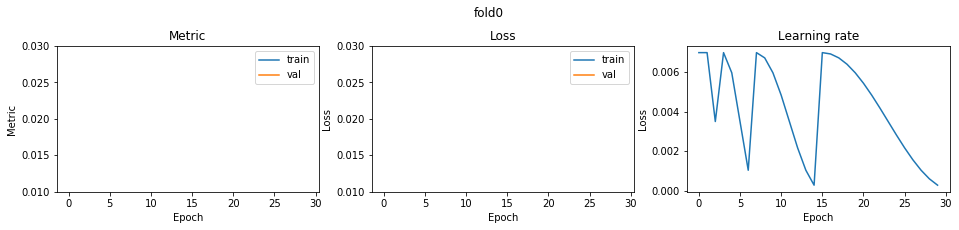

fold 1


epoch1 save best model... 0.032236802622787934
epoch2 save best model... 0.03199238209259703
epoch7 save best model... 0.03197335753327596
epoch15 save best model... 0.031922615653739536
epoch27 save best model... 0.03190138937315954
fold1 score: 0.03190139037544298


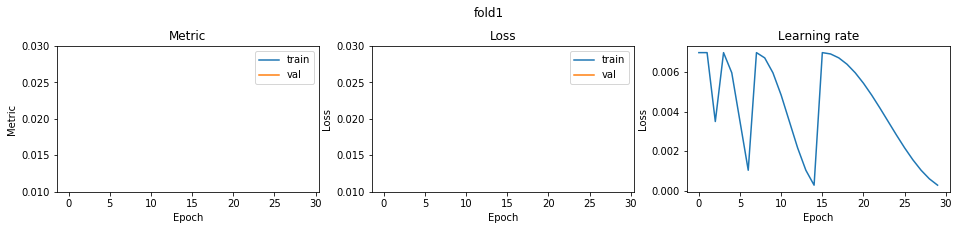

fold 2


epoch1 save best model... 0.032130808691502866
epoch2 save best model... 0.032049231775279845
epoch6 save best model... 0.03170036561074154
epoch27 save best model... 0.03166238923966002
fold2 score: 0.03166239047054556


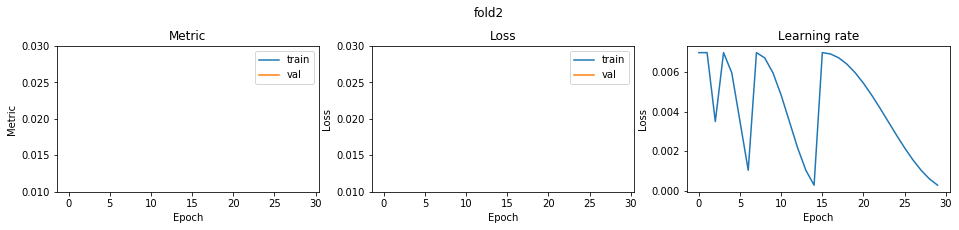

fold 3


epoch1 save best model... 0.03186764321915788
fold3 score: 0.03186764297516871


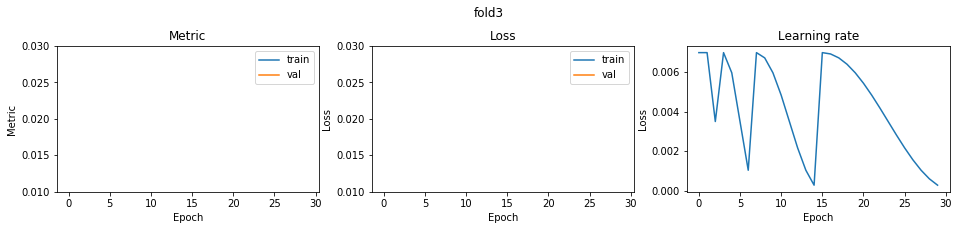

fold 4


epoch1 save best model... 0.031974516376208066
epoch2 save best model... 0.03178346663509795
epoch24 save best model... 0.031750700415742156
fold4 score: 0.031750702480131954


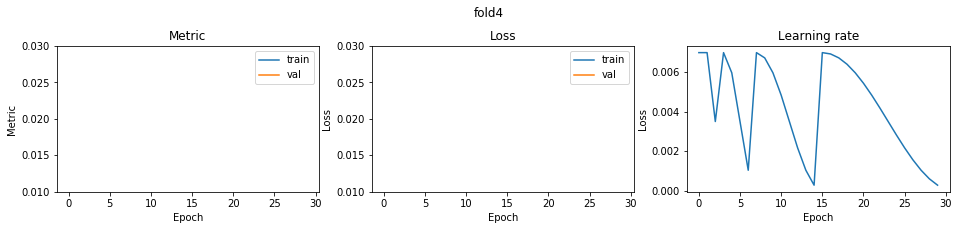

CV score: 0.03173853960863336

optimizer: AdamW_CG
fold 0


epoch1 save best model... 0.020075621694360345
epoch2 save best model... 0.01925598338399091
epoch3 save best model... 0.01806935167411058
epoch4 save best model... 0.017896854327588526
epoch5 save best model... 0.0175887042533496
epoch6 save best model... 0.017146755407876198
epoch7 save best model... 0.01693096758377715
epoch11 save best model... 0.01680112598985773
epoch12 save best model... 0.016559492640944033
epoch13 save best model... 0.01642330147767257
epoch14 save best model... 0.01631720463887434
epoch15 save best model... 0.016258198308391425
epoch23 save best model... 0.016225396348311986
epoch24 save best model... 0.016192891384667986
fold0 score: 0.016192891244759092


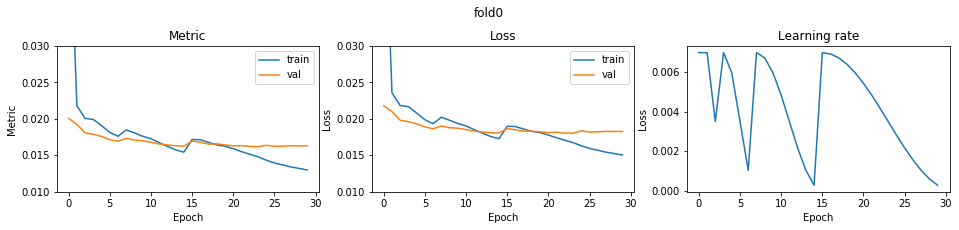

fold 1


epoch1 save best model... 0.020172999607342663
epoch2 save best model... 0.019012077456676733
epoch3 save best model... 0.018286590867795306
epoch5 save best model... 0.017623141050630724
epoch6 save best model... 0.017306544956547248
epoch7 save best model... 0.01703636186088332
epoch11 save best model... 0.01695672954407415
epoch12 save best model... 0.016853677668865693
epoch13 save best model... 0.016653538002755843
epoch14 save best model... 0.016549984846195374
epoch15 save best model... 0.01653874634072697
epoch24 save best model... 0.016491048654219263
fold1 score: 0.01649104856622161


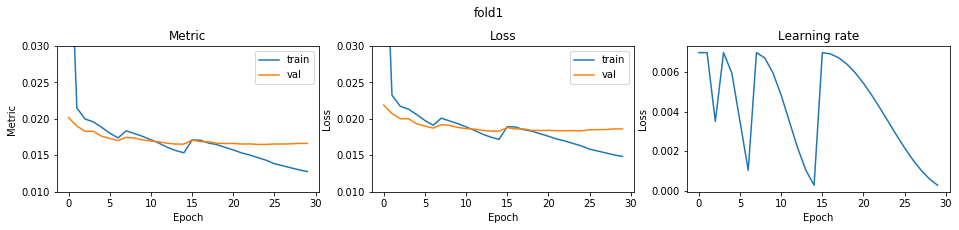

fold 2


epoch1 save best model... 0.020294935696928723
epoch2 save best model... 0.01897259499651916
epoch3 save best model... 0.018041067582288385
epoch4 save best model... 0.01787050782562178
epoch5 save best model... 0.017429084882248803
epoch6 save best model... 0.017145192403601784
epoch7 save best model... 0.016830184743085043
epoch11 save best model... 0.01667404274345225
epoch12 save best model... 0.01663727323168379
epoch13 save best model... 0.016409568364463965
epoch14 save best model... 0.01630593913843472
epoch15 save best model... 0.016242547427115447
fold2 score: 0.01624254732278606


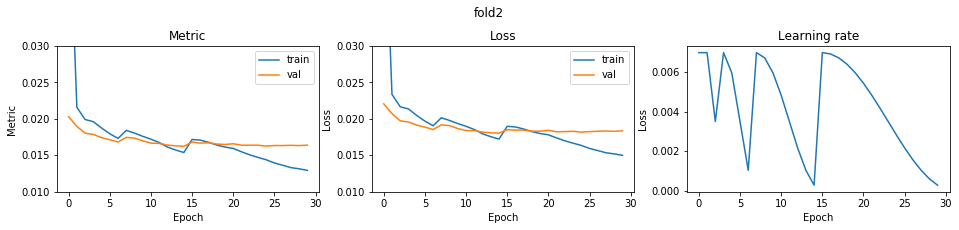

fold 3


epoch1 save best model... 0.020376752598682133
epoch2 save best model... 0.019471339697701377
epoch3 save best model... 0.018616189646846477
epoch4 save best model... 0.01840671003543706
epoch5 save best model... 0.01804858971735068
epoch6 save best model... 0.017558405287394083
epoch7 save best model... 0.017302729536891662
epoch10 save best model... 0.017291817058446332
epoch11 save best model... 0.01698138713369948
epoch12 save best model... 0.01687962667197668
epoch13 save best model... 0.016706366009229544
epoch14 save best model... 0.016599795403879705
epoch15 save best model... 0.016542417127087476
epoch25 save best model... 0.016536582656340473
epoch26 save best model... 0.016513627194343367
fold3 score: 0.01651362722747768


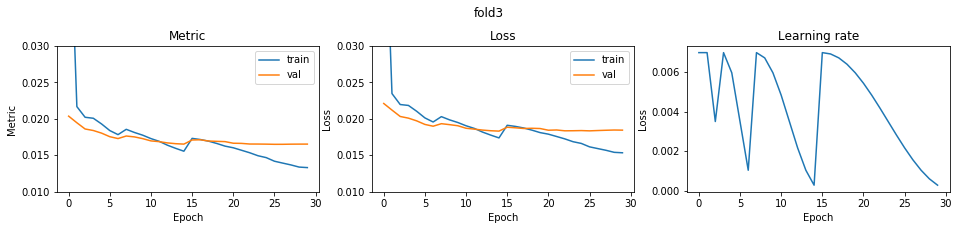

fold 4


epoch1 save best model... 0.020201584860546715
epoch2 save best model... 0.01902086885735087
epoch3 save best model... 0.01807395773929181
epoch5 save best model... 0.017674277017236707
epoch6 save best model... 0.01733332615142056
epoch7 save best model... 0.017076328698893615
epoch11 save best model... 0.01690508018975445
epoch12 save best model... 0.01671269439916065
epoch13 save best model... 0.016551710686864913
epoch14 save best model... 0.016418197175279974
epoch15 save best model... 0.01637660284146904
fold4 score: 0.01637660286393421


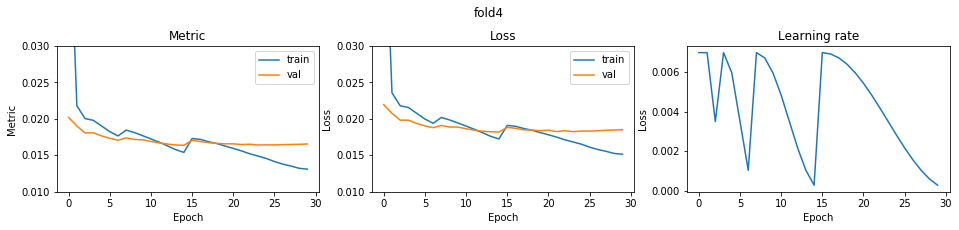

CV score: 0.016363343130246278

optimizer: PlainRAdam_CG
fold 0


epoch1 save best model... 0.698643378163253
epoch2 save best model... 0.6745778785751186
epoch3 save best model... 0.6667442945521622
epoch4 save best model... 0.6029001929222315
epoch5 save best model... 0.5174156161538561
epoch6 save best model... 0.47829244489821865
epoch7 save best model... 0.47643963910452597
epoch8 save best model... 0.3231339647042181
epoch9 save best model... 0.1998940050669846
epoch10 save best model... 0.13877270123953156
epoch11 save best model... 0.10828280128487694
epoch12 save best model... 0.09473234407926204
epoch13 save best model... 0.09073251334776368
epoch14 save best model... 0.09071357112063905
epoch15 save best model... 0.0887010900740743
epoch16 save best model... 0.05412767802901854
epoch17 save best model... 0.03757944678832567
epoch18 save best model... 0.03051751223403392
epoch19 save best model... 0.026590125294134938
epoch20 save best model... 0.02450551641235183
epoch21 save best model... 0.02324342670975622
epoch22 save best model... 0.0

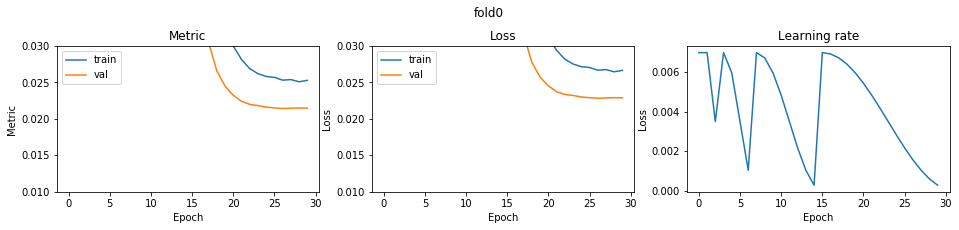

fold 1


epoch1 save best model... 0.6987565298046765
epoch2 save best model... 0.6749243182184268
epoch3 save best model... 0.667339888187225
epoch4 save best model... 0.6043714246056732
epoch5 save best model... 0.5155270241012495
epoch6 save best model... 0.4743108483348411
epoch8 save best model... 0.31800859721789576
epoch9 save best model... 0.20112287313744212
epoch10 save best model... 0.1379960052147898
epoch11 save best model... 0.10789627972442813
epoch12 save best model... 0.09500780966965532
epoch13 save best model... 0.08946356923576367
epoch15 save best model... 0.08764320134770276
epoch16 save best model... 0.053158460179414696
epoch17 save best model... 0.037153964756554476
epoch18 save best model... 0.030364216993038543
epoch19 save best model... 0.02645509699000927
epoch20 save best model... 0.024505823035379643
epoch21 save best model... 0.02310980204301832
epoch22 save best model... 0.022501289891195774
epoch23 save best model... 0.02205629820989962
epoch24 save best model.

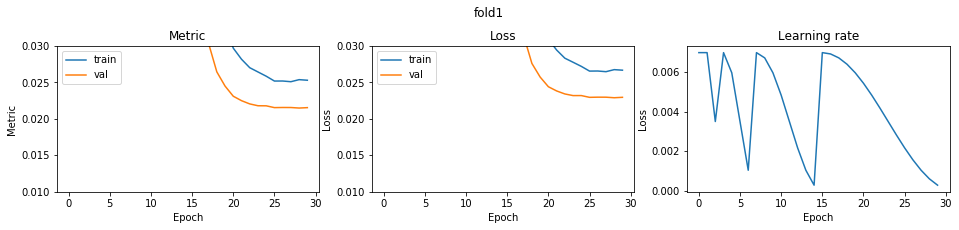

fold 2


epoch1 save best model... 0.7053184251655993
epoch2 save best model... 0.6793910208474153
epoch3 save best model... 0.6714654171974737
epoch4 save best model... 0.608301022963199
epoch5 save best model... 0.5194143444727483
epoch6 save best model... 0.4845384485929641
epoch7 save best model... 0.4788738788735978
epoch8 save best model... 0.321395382987907
epoch9 save best model... 0.20267812408613817
epoch10 save best model... 0.13721887708239905
epoch11 save best model... 0.105455094194271
epoch12 save best model... 0.09373685834714182
epoch13 save best model... 0.0899199558794159
epoch14 save best model... 0.08690358066197598
epoch15 save best model... 0.08642774478439645
epoch16 save best model... 0.0510718672067151
epoch17 save best model... 0.03726569133159049
epoch18 save best model... 0.03019113776626905
epoch19 save best model... 0.02643785991859371
epoch20 save best model... 0.024185423339691838
epoch21 save best model... 0.023275079332949034
epoch22 save best model... 0.02257

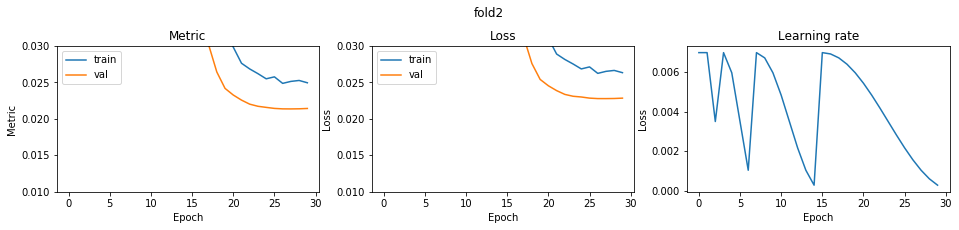

fold 3


epoch1 save best model... 0.6899540141937673
epoch2 save best model... 0.669046392228989
epoch3 save best model... 0.6599714165939558
epoch4 save best model... 0.5981757516741482
epoch5 save best model... 0.5121936094244954
epoch6 save best model... 0.47568902039310657
epoch7 save best model... 0.47211766362461793
epoch8 save best model... 0.31687441276797945
epoch9 save best model... 0.19870552816396422
epoch10 save best model... 0.13965375140343278
epoch11 save best model... 0.10610619647627811
epoch12 save best model... 0.09548192968876323
epoch13 save best model... 0.08869550565177053
epoch15 save best model... 0.0878306289638365
epoch16 save best model... 0.053563655054107616
epoch17 save best model... 0.038095967724478055
epoch18 save best model... 0.030098934740608808
epoch19 save best model... 0.026953820917322586
epoch20 save best model... 0.02437309688275387
epoch21 save best model... 0.023391397351691826
epoch22 save best model... 0.02266339121433081
epoch23 save best model.

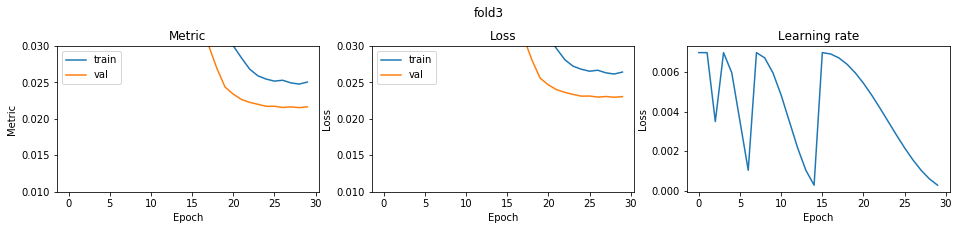

fold 4


epoch1 save best model... 0.6979989603874623
epoch2 save best model... 0.6760534681057333
epoch3 save best model... 0.6686405480315311
epoch4 save best model... 0.6062168492543127
epoch5 save best model... 0.5183351098269157
epoch6 save best model... 0.4835383298592578
epoch7 save best model... 0.47981333169144214
epoch8 save best model... 0.3249929782334113
epoch9 save best model... 0.2028323137407151
epoch10 save best model... 0.13821293984567387
epoch11 save best model... 0.10900450466977166
epoch12 save best model... 0.09434193448420267
epoch13 save best model... 0.09031638297716958
epoch14 save best model... 0.08888272935002703
epoch15 save best model... 0.08811902110560337
epoch16 save best model... 0.05248021826759015
epoch17 save best model... 0.0364510814131053
epoch18 save best model... 0.029866444049636433
epoch19 save best model... 0.02673635827653229
epoch20 save best model... 0.023958093146867795
epoch21 save best model... 0.02303223762754563
epoch22 save best model... 0.

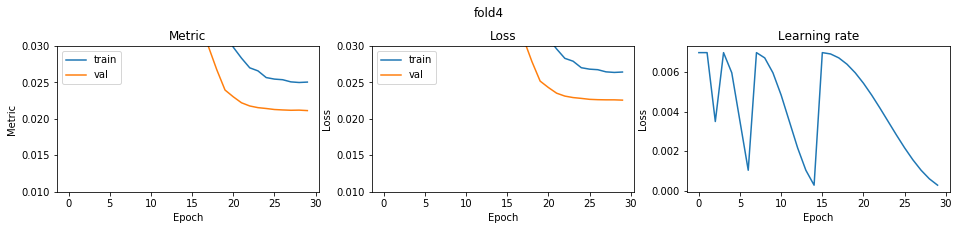

CV score: 0.02139542159003806

optimizer: RAdam_CG
fold 0


epoch1 save best model... 0.020177580875287295
epoch2 save best model... 0.01879244197609756
epoch3 save best model... 0.017899899394304444
epoch5 save best model... 0.017674157414627783
epoch6 save best model... 0.01714647337539728
epoch7 save best model... 0.016795841208181783
epoch11 save best model... 0.016697953757246562
epoch12 save best model... 0.0165264606187311
epoch13 save best model... 0.016346135557308825
epoch14 save best model... 0.016185176823551264
epoch15 save best model... 0.016151684661796804
fold0 score: 0.01615168469402119


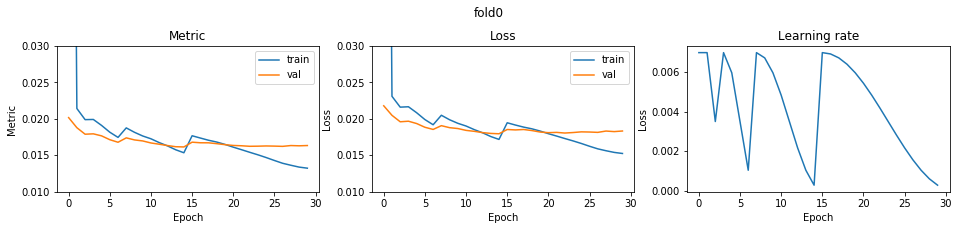

fold 1


epoch1 save best model... 0.020392500042769355
epoch2 save best model... 0.019028632994762422
epoch3 save best model... 0.01837172583390624
epoch4 save best model... 0.01801282226594577
epoch5 save best model... 0.01767378676861803
epoch6 save best model... 0.017288751491084678
epoch7 save best model... 0.017020798390351387
epoch11 save best model... 0.016997913760170222
epoch12 save best model... 0.01688340927269857
epoch13 save best model... 0.016686686409069073
epoch14 save best model... 0.01665381991127699
epoch15 save best model... 0.01652608983520835
fold1 score: 0.016526089816568546


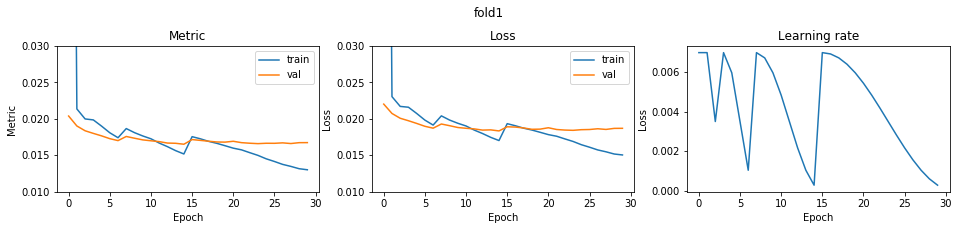

fold 2


epoch1 save best model... 0.02042323971406138
epoch2 save best model... 0.019031831870518844
epoch3 save best model... 0.018131797081192686
epoch4 save best model... 0.01804969485956937
epoch5 save best model... 0.017722851201878317
epoch6 save best model... 0.017109795586191377
epoch7 save best model... 0.01684400992199361
epoch11 save best model... 0.016729592645486086
epoch13 save best model... 0.016366918687788248
epoch14 save best model... 0.01627362764672406
epoch15 save best model... 0.01620690603875257
fold2 score: 0.016206906096519376


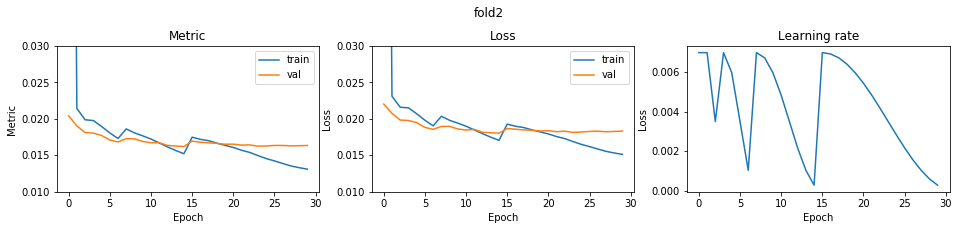

fold 3


epoch1 save best model... 0.020493153701186317
epoch2 save best model... 0.01907858771392927
epoch3 save best model... 0.018334992711935064
epoch4 save best model... 0.018152839342951095
epoch5 save best model... 0.01760115356636414
epoch6 save best model... 0.01729998410062054
epoch7 save best model... 0.017046982014301427
epoch11 save best model... 0.01695868011759191
epoch12 save best model... 0.016736919053136488
epoch13 save best model... 0.016571730312494592
epoch14 save best model... 0.016457747976488704
epoch15 save best model... 0.01644510016362936
fold3 score: 0.0164451002247167


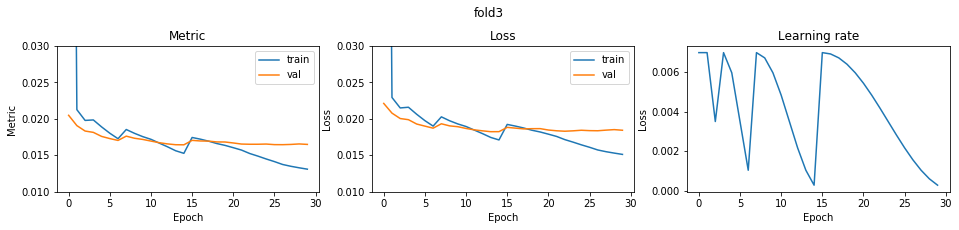

fold 4


epoch1 save best model... 0.020376052725253994
epoch2 save best model... 0.01864986987890578
epoch3 save best model... 0.0180666706806944
epoch5 save best model... 0.01765854764042384
epoch6 save best model... 0.01731964668814848
epoch7 save best model... 0.01704139118135858
epoch10 save best model... 0.017001812723900164
epoch11 save best model... 0.016846524662251217
epoch12 save best model... 0.016719980884114267
epoch13 save best model... 0.016582792675322037
epoch14 save best model... 0.016411590939790756
epoch15 save best model... 0.016398301888214836
fold4 score: 0.016398301901664036


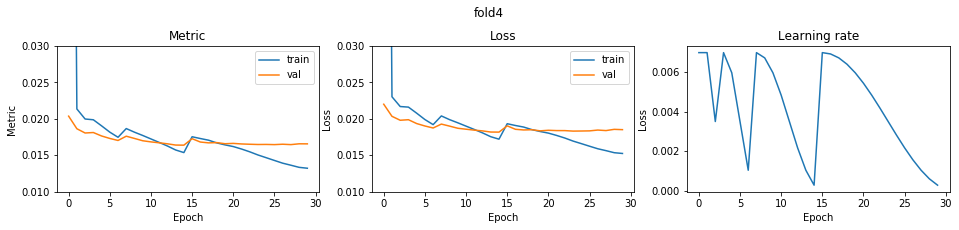

CV score: 0.01634561464389044

optimizer: Ranger_CG
fold 0


Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers


epoch1 save best model... 0.02089450257853658
epoch2 save best model... 0.019281971858547055
epoch3 save best model... 0.018730475432780447
epoch4 save best model... 0.018118620855661623
epoch5 save best model... 0.01768869562307903
epoch6 save best model... 0.017248613660590797
epoch7 save best model... 0.017058264236719026
epoch9 save best model... 0.017016924107298763
epoch10 save best model... 0.01680484995806
epoch11 save best model... 0.016666069754944574
epoch12 save best model... 0.016478548175177975
epoch13 save best model... 0.016357758570810385
epoch14 save best model... 0.01625848103204322
epoch15 save best model... 0.016238813305905847
fold0 score: 0.01623881319302602


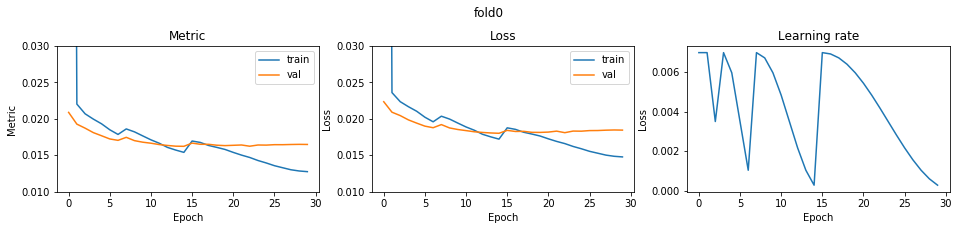

fold 1


Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers


epoch1 save best model... 0.021185859612565455
epoch2 save best model... 0.01948674635502887
epoch3 save best model... 0.018724412429635576
epoch4 save best model... 0.01826368769986004
epoch5 save best model... 0.01781997341479309
epoch6 save best model... 0.017438449765523518
epoch7 save best model... 0.017280765558941185
epoch9 save best model... 0.017234987684322477
epoch10 save best model... 0.017193101944457456
epoch11 save best model... 0.016959053319941474
epoch12 save best model... 0.016797229879777425
epoch13 save best model... 0.016651355819961265
epoch14 save best model... 0.01661141833774686
epoch15 save best model... 0.01654035239154717
fold1 score: 0.016540352366719017


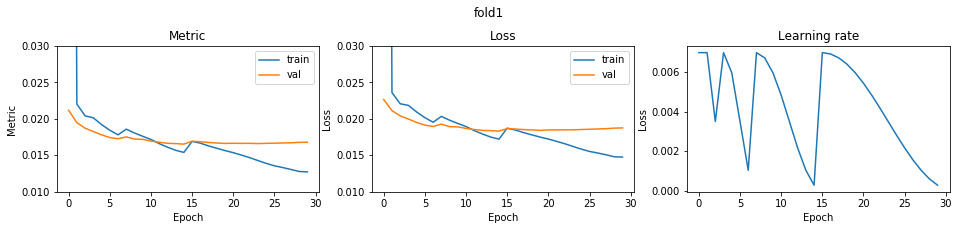

fold 2


Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers


epoch1 save best model... 0.021253576462735724
epoch2 save best model... 0.019426852129408263
epoch3 save best model... 0.018798349413313743
epoch4 save best model... 0.018158141996369434
epoch5 save best model... 0.017688041777827658
epoch6 save best model... 0.017314260025965134
epoch7 save best model... 0.017082854542023136
epoch10 save best model... 0.016924358814603364
epoch11 save best model... 0.0167403446090713
epoch12 save best model... 0.016565062235094442
epoch13 save best model... 0.016396962932726262
epoch14 save best model... 0.016297319426743867
epoch15 save best model... 0.016268795225230306
fold2 score: 0.01626879518936988


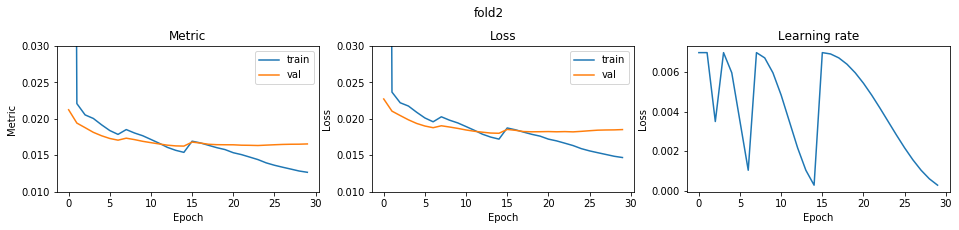

fold 3


Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers


epoch1 save best model... 0.02126112760623794
epoch2 save best model... 0.019538933939485043
epoch3 save best model... 0.019072736378818546
epoch4 save best model... 0.01829953815295851
epoch5 save best model... 0.01788150273424686
epoch6 save best model... 0.017591095741643043
epoch7 save best model... 0.01733409785676179
epoch10 save best model... 0.017042612220353717
epoch11 save best model... 0.016949802309970514
epoch12 save best model... 0.016737537304520742
epoch13 save best model... 0.016542023631207357
epoch14 save best model... 0.016502188438027757
epoch15 save best model... 0.016458602397700514
fold3 score: 0.016458602349876016


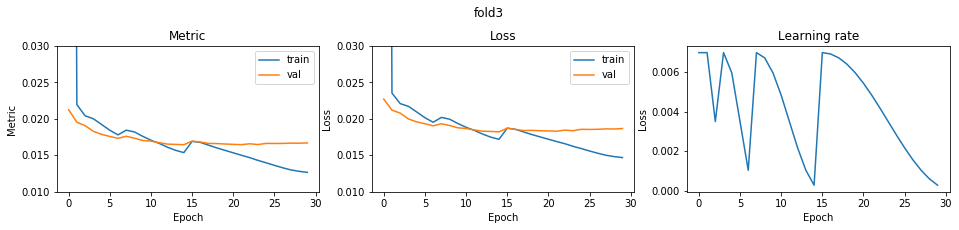

fold 4


Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers


epoch1 save best model... 0.020898884868329914
epoch2 save best model... 0.01926429775503203
epoch3 save best model... 0.018449961306667272
epoch4 save best model... 0.018005830079639556
epoch5 save best model... 0.01754064857747601
epoch6 save best model... 0.01726718093851976
epoch7 save best model... 0.01707951638652415
epoch10 save best model... 0.01693779046653615
epoch11 save best model... 0.016900896918715946
epoch12 save best model... 0.016695764113073334
epoch13 save best model... 0.01658046619801152
epoch14 save best model... 0.0165093055448934
epoch15 save best model... 0.016473559468373623
fold4 score: 0.01647355948521203


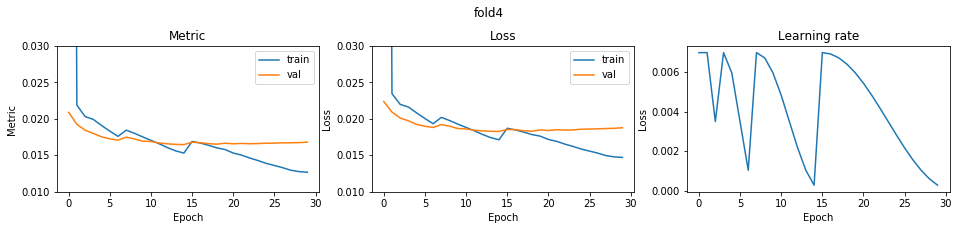

CV score: 0.016396023737793645

optimizer: AggMo
fold 0


epoch1 save best model... 0.27544877525071076
epoch2 save best model... 0.03225111349195174
epoch3 save best model... 0.030756135919642612
epoch4 save best model... 0.030447305573451763
epoch5 save best model... 0.030263713073486076
fold0 score: 0.030263713175410073


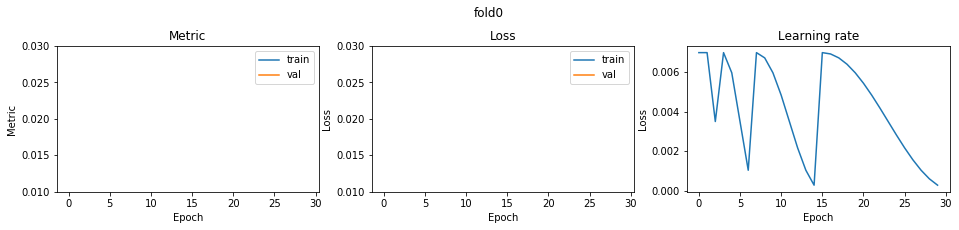

fold 1


epoch1 save best model... 0.2719704919182975
epoch2 save best model... 0.032212706628612246
epoch3 save best model... 0.03080225385357128
epoch4 save best model... 0.03029186438067162
fold1 score: 0.0302918643842965


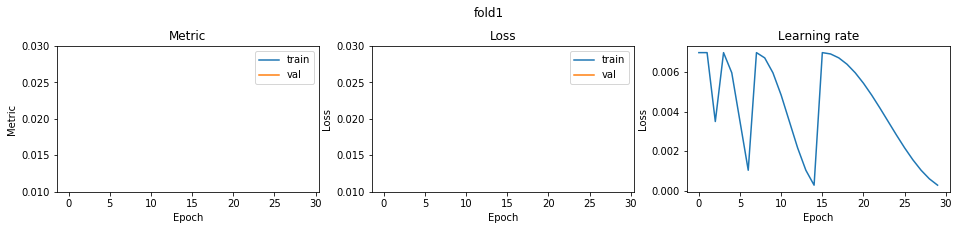

fold 2


epoch1 save best model... 0.2539221891294337
epoch2 save best model... 0.03145313647181631
epoch3 save best model... 0.030341828459231696
epoch4 save best model... 0.029912794462947728
fold2 score: 0.029912794291145288


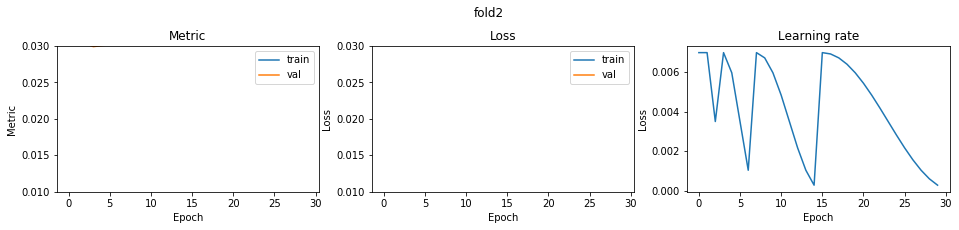

fold 3


epoch1 save best model... 0.2958872773109645
epoch2 save best model... 0.03253689149314016
epoch3 save best model... 0.031099767316820136
epoch4 save best model... 0.030391902180392814
fold3 score: 0.030391902258924585


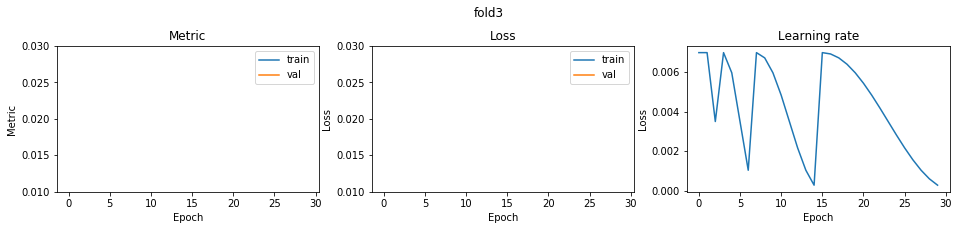

fold 4


epoch1 save best model... 0.26753783588528907
epoch2 save best model... 0.031667602853955604
epoch3 save best model... 0.030194255007019347
epoch4 save best model... 0.03004463508742138
fold4 score: 0.030044635228273404


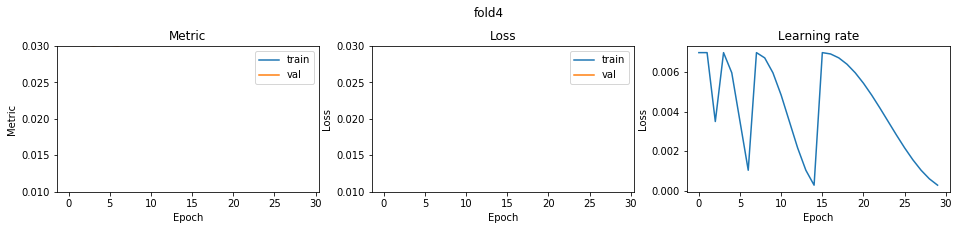

CV score: 0.030180989034780545

optimizer: Apollo
fold 0


epoch1 save best model... 0.7042104169285107
epoch2 save best model... 0.6954855916711898
epoch3 save best model... 0.6911407714009556
epoch4 save best model... 0.681694551453775
epoch5 save best model... 0.677833570516191
epoch6 save best model... 0.6713818406461312
epoch7 save best model... 0.6693322155904661
epoch8 save best model... 0.6635686002451087
epoch9 save best model... 0.6528236943116764
epoch10 save best model... 0.645029980310818
epoch11 save best model... 0.6393704303576354
epoch12 save best model... 0.6347945524782689
epoch13 save best model... 0.6309920458424336
epoch14 save best model... 0.6297041504149556
epoch16 save best model... 0.6179049901104191
epoch17 save best model... 0.6048489606733474
epoch18 save best model... 0.5925482931061051
epoch19 save best model... 0.576858799875733
epoch20 save best model... 0.5599323912742198
epoch21 save best model... 0.5461243421721839
epoch22 save best model... 0.5294365464147511
epoch23 save best model... 0.5154598722696847
e

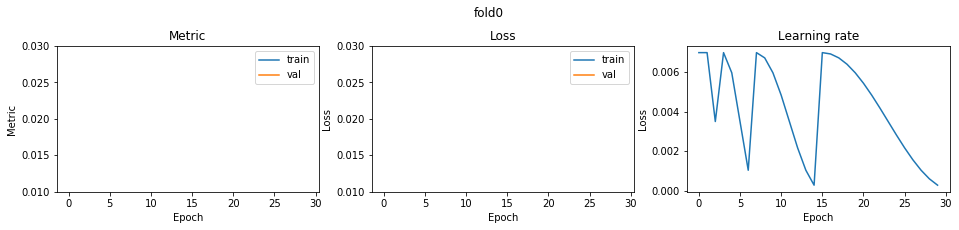

fold 1


epoch1 save best model... 0.7036611590034518
epoch2 save best model... 0.6963703317695448
epoch3 save best model... 0.6938912386800793
epoch4 save best model... 0.6858457726018796
epoch5 save best model... 0.6776556809797567
epoch6 save best model... 0.6744414229522291
epoch7 save best model... 0.6721207164881522
epoch8 save best model... 0.664594708447251
epoch9 save best model... 0.657098196149823
epoch10 save best model... 0.6490650596909817
epoch11 save best model... 0.6426274650703668
epoch12 save best model... 0.637247645031974
epoch13 save best model... 0.6342643171406248
epoch14 save best model... 0.6329575853783439
epoch16 save best model... 0.6207603336765761
epoch17 save best model... 0.6075211703763733
epoch18 save best model... 0.5934895359456716
epoch19 save best model... 0.5814014182978379
epoch20 save best model... 0.5641294307115545
epoch21 save best model... 0.5487875304072178
epoch22 save best model... 0.5348642295301572
epoch23 save best model... 0.5171401051867658


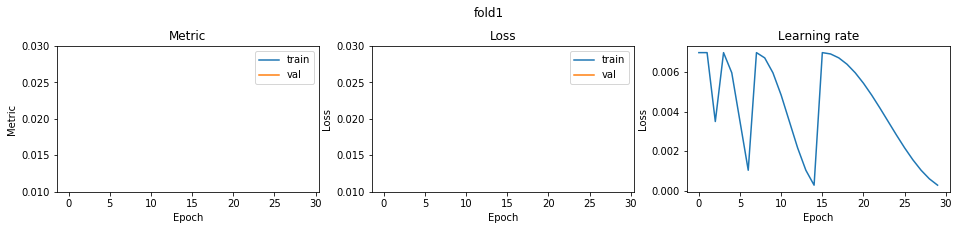

fold 2


epoch1 save best model... 0.7005595368061339
epoch2 save best model... 0.6926021417443751
epoch3 save best model... 0.6871834907805521
epoch4 save best model... 0.6812841201540168
epoch5 save best model... 0.6721521514400205
epoch6 save best model... 0.6668327392763689
epoch8 save best model... 0.6611654516856962
epoch9 save best model... 0.6501646842438312
epoch10 save best model... 0.6433319761911159
epoch11 save best model... 0.6364076786960385
epoch12 save best model... 0.6325861418076109
epoch13 save best model... 0.628417773843219
epoch14 save best model... 0.6261438554499572
epoch15 save best model... 0.6258414498247897
epoch16 save best model... 0.6143818199023431
epoch17 save best model... 0.600247401994517
epoch18 save best model... 0.5861754367307531
epoch19 save best model... 0.5706499567822786
epoch20 save best model... 0.5552766334225578
epoch21 save best model... 0.5383271565196128
epoch22 save best model... 0.525047182941741
epoch23 save best model... 0.5089808847508199

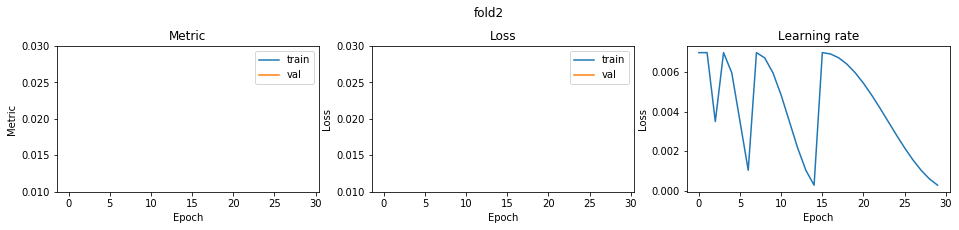

fold 3


epoch1 save best model... 0.7065570272997463
epoch2 save best model... 0.6971668872583429
epoch3 save best model... 0.6925097056021723
epoch4 save best model... 0.6846776689646727
epoch5 save best model... 0.6802378924126505
epoch6 save best model... 0.6749795289137369
epoch8 save best model... 0.6663917729414677
epoch9 save best model... 0.6573236015771678
epoch10 save best model... 0.6508169821834782
epoch11 save best model... 0.6440286535336922
epoch12 save best model... 0.6411803255863233
epoch13 save best model... 0.6374011012579152
epoch14 save best model... 0.6348697584962519
epoch16 save best model... 0.6256573359895676
epoch17 save best model... 0.6136806633314945
epoch18 save best model... 0.6007612039125048
epoch19 save best model... 0.5874217760318504
epoch20 save best model... 0.5749200851336156
epoch21 save best model... 0.5616576953466498
epoch22 save best model... 0.5480743985241258
epoch23 save best model... 0.533769363287098
epoch24 save best model... 0.52500313069662

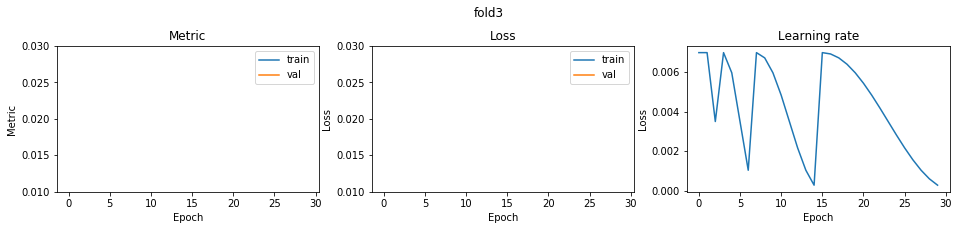

fold 4


epoch1 save best model... 0.7056871978731525
epoch2 save best model... 0.6988878646309664
epoch3 save best model... 0.6959778252386558
epoch4 save best model... 0.6871681088195575
epoch5 save best model... 0.6799751389271035
epoch6 save best model... 0.6759719690049156
epoch7 save best model... 0.675300668339523
epoch8 save best model... 0.6678995110450954
epoch9 save best model... 0.6593276122436437
epoch10 save best model... 0.6521281625523926
epoch11 save best model... 0.6443320735168891
epoch12 save best model... 0.6400729796066371
epoch13 save best model... 0.636589677621672
epoch14 save best model... 0.6355318485740106
epoch15 save best model... 0.6338817714830194
epoch16 save best model... 0.623420593108566
epoch17 save best model... 0.6130032034018045
epoch18 save best model... 0.5994454890285917
epoch19 save best model... 0.5831027906413502
epoch20 save best model... 0.5679251390328983
epoch21 save best model... 0.5531161288465617
epoch22 save best model... 0.5387645638070508


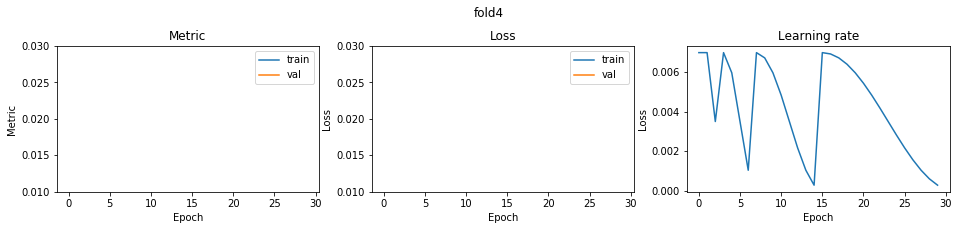

CV score: 0.47692246340813554

optimizer: PID
fold 0


epoch1 save best model... 0.7019045250562438
epoch2 save best model... 0.6926811619065617
epoch3 save best model... 0.6894110910713266
epoch4 save best model... 0.6820943132076829
epoch5 save best model... 0.675855901192424
epoch6 save best model... 0.6726483495740522
epoch8 save best model... 0.6620859984656401
epoch9 save best model... 0.6550824002144277
epoch10 save best model... 0.6469477452286827
epoch11 save best model... 0.6428333354430753
epoch12 save best model... 0.6371256032945898
epoch13 save best model... 0.6329053095913151
epoch14 save best model... 0.6328059218739052
epoch15 save best model... 0.6312891034439104
epoch16 save best model... 0.6204759292015997
epoch17 save best model... 0.6077554254162556
epoch18 save best model... 0.5954957380110147
epoch19 save best model... 0.5791829847529157
epoch20 save best model... 0.566926043940568
epoch21 save best model... 0.5513182517336278
epoch22 save best model... 0.5371572677801302
epoch23 save best model... 0.523213358864968

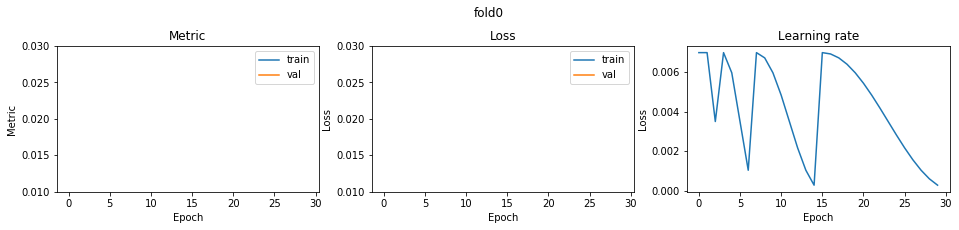

fold 1


epoch1 save best model... 0.7035828147344096
epoch2 save best model... 0.6938038376692787
epoch3 save best model... 0.69258047106272
epoch4 save best model... 0.6836205017976811
epoch5 save best model... 0.6779814078286884
epoch6 save best model... 0.6751312928553946
epoch7 save best model... 0.6729534022708666
epoch8 save best model... 0.6644790814525311
epoch9 save best model... 0.6569478416203854
epoch10 save best model... 0.6491529930694468
epoch11 save best model... 0.6441083774802407
epoch12 save best model... 0.6403231546910865
epoch13 save best model... 0.6353201072779352
epoch14 save best model... 0.6339806200133068
epoch16 save best model... 0.6233125163743425
epoch17 save best model... 0.6124249661422367
epoch18 save best model... 0.5994915789068357
epoch19 save best model... 0.5868071361673424
epoch20 save best model... 0.5719590779995696
epoch21 save best model... 0.5580006272354439
epoch22 save best model... 0.5454356917272426
epoch23 save best model... 0.5303260926288796

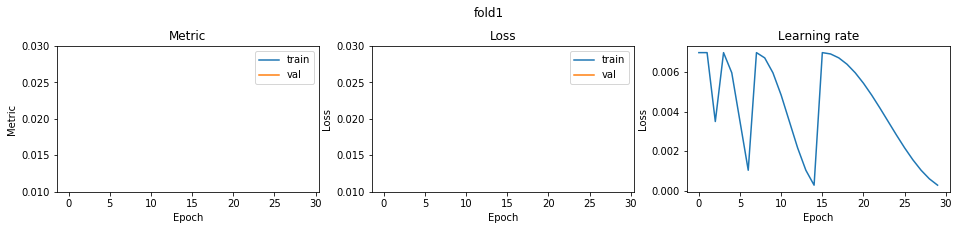

fold 2


epoch1 save best model... 0.7053740136062238
epoch2 save best model... 0.6976944285417966
epoch3 save best model... 0.6934476962771821
epoch4 save best model... 0.6863484255108863
epoch5 save best model... 0.6792536699356319
epoch6 save best model... 0.67464460286879
epoch7 save best model... 0.6724033312798633
epoch8 save best model... 0.6646926507071989
epoch9 save best model... 0.6557226964894501
epoch10 save best model... 0.650040519729131
epoch11 save best model... 0.6423927957035463
epoch12 save best model... 0.6371407239549549
epoch13 save best model... 0.6337008808299603
epoch14 save best model... 0.6314287898643165
epoch16 save best model... 0.6207508913311988
epoch17 save best model... 0.6074342845267928
epoch18 save best model... 0.5935854055963526
epoch19 save best model... 0.580349287836827
epoch20 save best model... 0.5662381275690452
epoch21 save best model... 0.5493267203930924
epoch22 save best model... 0.5315273285971386
epoch23 save best model... 0.5218216853849055
e

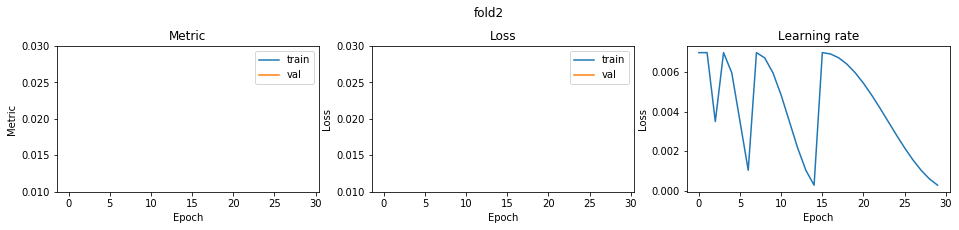

fold 3


epoch1 save best model... 0.704989501528425
epoch2 save best model... 0.6972657499389388
epoch3 save best model... 0.6933667676052363
epoch4 save best model... 0.683419032384703
epoch5 save best model... 0.6770278383224592
epoch6 save best model... 0.6728139242984711
epoch7 save best model... 0.6722841596277537
epoch8 save best model... 0.665753099967244
epoch9 save best model... 0.6569129556349579
epoch10 save best model... 0.6499624257478736
epoch11 save best model... 0.6427042758003183
epoch12 save best model... 0.6374894838669849
epoch13 save best model... 0.6356400630197112
epoch14 save best model... 0.6350542317761919
epoch15 save best model... 0.6326812220054226
epoch16 save best model... 0.6233142666501716
epoch17 save best model... 0.6104819824320852
epoch18 save best model... 0.5979792756751893
epoch19 save best model... 0.5837906958301953
epoch20 save best model... 0.5687309939931899
epoch21 save best model... 0.5527929287021959
epoch22 save best model... 0.5377141624213895


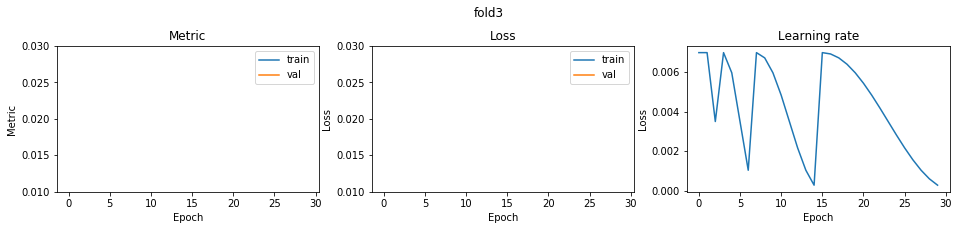

fold 4


epoch1 save best model... 0.710611275279712
epoch2 save best model... 0.6989515733338706
epoch3 save best model... 0.6946859770049266
epoch4 save best model... 0.686300864279406
epoch5 save best model... 0.6811010568451501
epoch6 save best model... 0.6762559908397648
epoch7 save best model... 0.6754202834022887
epoch8 save best model... 0.6666197512578855
epoch9 save best model... 0.6582587931042109
epoch10 save best model... 0.6487908861088589
epoch11 save best model... 0.6416025651343048
epoch12 save best model... 0.6364256309213834
epoch13 save best model... 0.6326104592082169
epoch14 save best model... 0.6313659187058381
epoch15 save best model... 0.6297462164948361
epoch16 save best model... 0.6188772014441957
epoch17 save best model... 0.6071159319888486
epoch18 save best model... 0.5912362924469359
epoch19 save best model... 0.5750035177330765
epoch20 save best model... 0.5584059440736618
epoch21 save best model... 0.541600322478996
epoch22 save best model... 0.5219211535736206


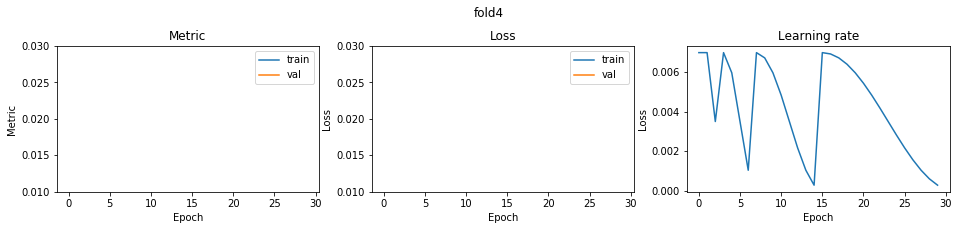

CV score: 0.47744556011928696

optimizer: QHM
fold 0


epoch1 save best model... 0.7020350388079406
epoch2 save best model... 0.6938981267205675
epoch3 save best model... 0.690619595745973
epoch4 save best model... 0.6853664401723475
epoch5 save best model... 0.6753085768847368
epoch6 save best model... 0.673483151917034
epoch7 save best model... 0.6707301798876978
epoch8 save best model... 0.6610939712079077
epoch9 save best model... 0.652772391331223
epoch10 save best model... 0.6453571124880624
epoch11 save best model... 0.6378078863941183
epoch12 save best model... 0.6343811374590446
epoch13 save best model... 0.6296576541214163
epoch14 save best model... 0.6275649034080854
epoch16 save best model... 0.6152358143910732
epoch17 save best model... 0.603036511813318
epoch18 save best model... 0.5882311989886343
epoch19 save best model... 0.5721764653310146
epoch20 save best model... 0.5567999450112258
epoch21 save best model... 0.5428670161677385
epoch22 save best model... 0.524454299789898
epoch23 save best model... 0.5115102951510349
ep

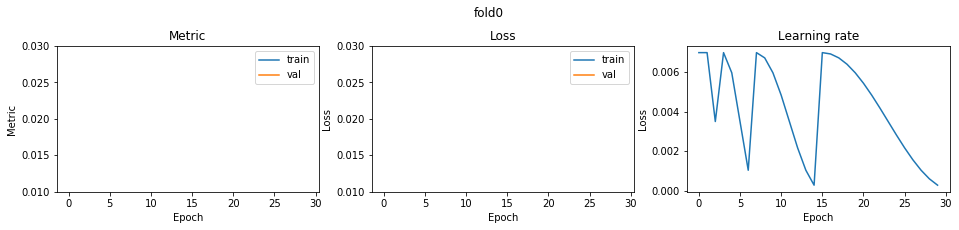

fold 1


epoch1 save best model... 0.7012455336975328
epoch2 save best model... 0.6957405613152632
epoch3 save best model... 0.6901480196738574
epoch4 save best model... 0.6835444775060088
epoch5 save best model... 0.6759019105791312
epoch6 save best model... 0.6727740191658257
epoch7 save best model... 0.6709732335068473
epoch8 save best model... 0.662497472453427
epoch9 save best model... 0.6548633214199182
epoch10 save best model... 0.647978298238753
epoch11 save best model... 0.6424476450818849
epoch12 save best model... 0.6355531061665293
epoch13 save best model... 0.6313316087484848
epoch14 save best model... 0.630311931828264
epoch15 save best model... 0.6298002948737085
epoch16 save best model... 0.6184886431308345
epoch17 save best model... 0.6080523542049779
epoch18 save best model... 0.591767492952149
epoch19 save best model... 0.5766821298981669
epoch20 save best model... 0.562047543436608
epoch21 save best model... 0.5478083676427067
epoch22 save best model... 0.531499989946982
epo

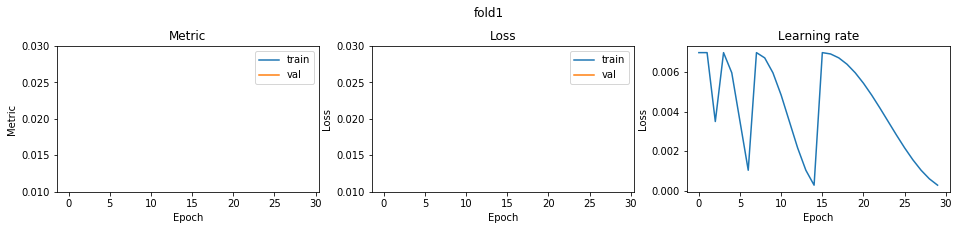

fold 2


epoch1 save best model... 0.7066734108601107
epoch2 save best model... 0.6975201980403302
epoch3 save best model... 0.6936922017820171
epoch4 save best model... 0.6871025485692575
epoch5 save best model... 0.6804940405291776
epoch6 save best model... 0.6772742734109657
epoch7 save best model... 0.6768183624806885
epoch8 save best model... 0.6668846282499421
epoch9 save best model... 0.6579934662799135
epoch10 save best model... 0.6519715961439785
epoch11 save best model... 0.6466848800409951
epoch12 save best model... 0.6423178488449345
epoch13 save best model... 0.6389305101328598
epoch14 save best model... 0.6372850007254705
epoch15 save best model... 0.6370795517175283
epoch16 save best model... 0.6256243391796407
epoch17 save best model... 0.6149837039657213
epoch18 save best model... 0.6029443248960418
epoch19 save best model... 0.5900552544949076
epoch20 save best model... 0.5783864689541449
epoch21 save best model... 0.5610721509612538
epoch22 save best model... 0.54883886021887

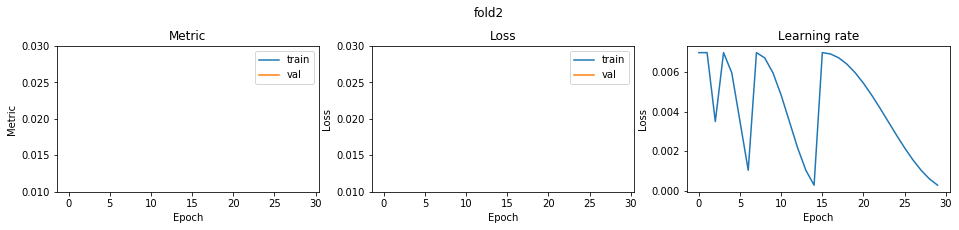

fold 3


epoch1 save best model... 0.7032699420946334
epoch2 save best model... 0.6962734067358569
epoch3 save best model... 0.69146608581304
epoch4 save best model... 0.6864102982442851
epoch5 save best model... 0.6779996660955946
epoch6 save best model... 0.674038579333616
epoch7 save best model... 0.6734406344168279
epoch8 save best model... 0.6655641624487614
epoch9 save best model... 0.6564643501692318
epoch10 save best model... 0.6509826681065396
epoch11 save best model... 0.6448308441524897
epoch12 save best model... 0.6395576605764228
epoch13 save best model... 0.6363275892099107
epoch15 save best model... 0.6345019654423881
epoch16 save best model... 0.625410986082429
epoch17 save best model... 0.6133149788700095
epoch18 save best model... 0.6004173392315388
epoch19 save best model... 0.5907853471119474
epoch20 save best model... 0.5752338191914396
epoch21 save best model... 0.5607119547750521
epoch22 save best model... 0.5478039527808344
epoch23 save best model... 0.533758675997784
ep

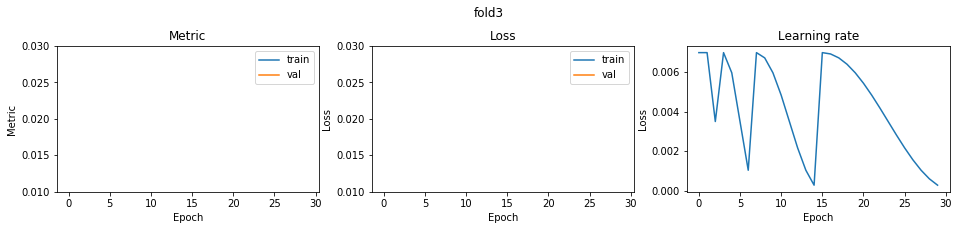

fold 4


epoch1 save best model... 0.7052615848923598
epoch2 save best model... 0.6991408583786601
epoch3 save best model... 0.6957881894089909
epoch4 save best model... 0.6875675981571571
epoch5 save best model... 0.6797838871191194
epoch6 save best model... 0.6758647013633833
epoch8 save best model... 0.6650576572754932
epoch9 save best model... 0.657674282775653
epoch10 save best model... 0.6513469744380351
epoch11 save best model... 0.6447443088800869
epoch12 save best model... 0.6414514618473879
epoch13 save best model... 0.6380808500874287
epoch14 save best model... 0.6369136197148804
epoch15 save best model... 0.6342686447847405
epoch16 save best model... 0.6242733723481858
epoch17 save best model... 0.6116010202905312
epoch18 save best model... 0.5993855322412044
epoch19 save best model... 0.586030315348119
epoch20 save best model... 0.5706154644896609
epoch21 save best model... 0.5541498885610924
epoch22 save best model... 0.5397712395511618
epoch23 save best model... 0.528194912093647

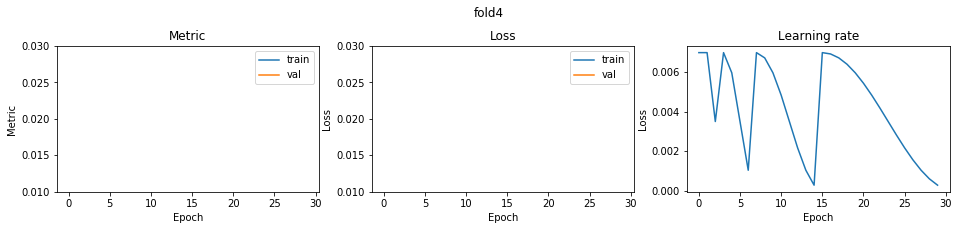

CV score: 0.4825835447645954

optimizer: SGDP
fold 0


epoch1 save best model... 0.7037449880178535
epoch2 save best model... 0.6983357699965562
epoch3 save best model... 0.6922448077886143
epoch4 save best model... 0.6849490146973681
epoch5 save best model... 0.6774729037067613
epoch6 save best model... 0.6746635338440028
epoch8 save best model... 0.6669157922946782
epoch9 save best model... 0.6577871860024055
epoch10 save best model... 0.6497844192324576
epoch11 save best model... 0.6443407791622136
epoch12 save best model... 0.6402490975644974
epoch13 save best model... 0.6363986756915655
epoch14 save best model... 0.6350549939824671
epoch15 save best model... 0.6330465338767797
epoch16 save best model... 0.6240810643024488
epoch17 save best model... 0.6115723975698606
epoch18 save best model... 0.5989489078793276
epoch19 save best model... 0.5858888404244442
epoch20 save best model... 0.5702788112646898
epoch21 save best model... 0.5570751099760277
epoch22 save best model... 0.5429359298360646
epoch23 save best model... 0.5311280329569

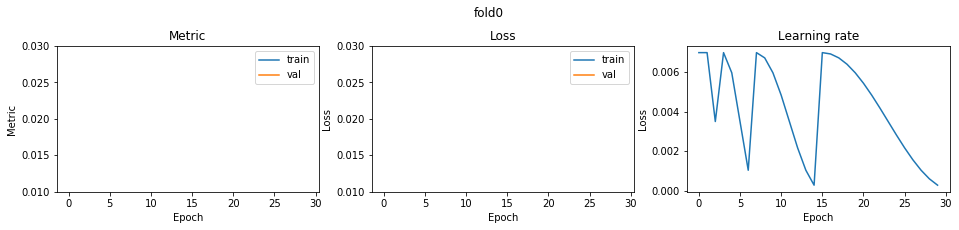

fold 1


epoch1 save best model... 0.7021881237500457
epoch2 save best model... 0.6955879302116103
epoch3 save best model... 0.6900055000249116
epoch4 save best model... 0.6831558437873247
epoch5 save best model... 0.676450282056882
epoch6 save best model... 0.6740569616401622
epoch7 save best model... 0.6725586280651097
epoch8 save best model... 0.6650961002067163
epoch9 save best model... 0.6565688704270984
epoch10 save best model... 0.6510625001400417
epoch11 save best model... 0.6445283906881889
epoch12 save best model... 0.639564680154135
epoch13 save best model... 0.6376802158888067
epoch14 save best model... 0.6354672328218237
epoch15 save best model... 0.634922888208886
epoch16 save best model... 0.6260104975468967
epoch17 save best model... 0.61152556336912
epoch18 save best model... 0.6025269858982167
epoch19 save best model... 0.5886825694123062
epoch20 save best model... 0.5725228304905348
epoch21 save best model... 0.5581431034269135
epoch22 save best model... 0.5459772613087122
ep

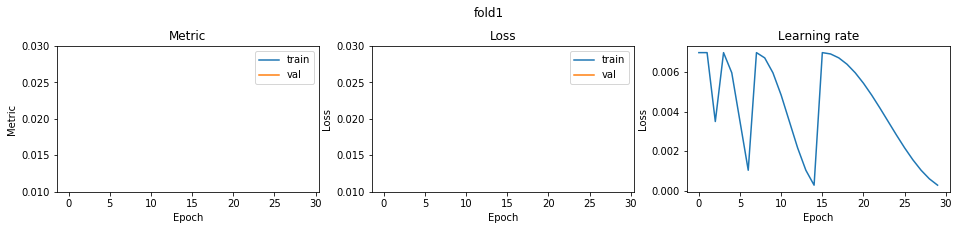

fold 2


epoch1 save best model... 0.7093491080573763
epoch2 save best model... 0.6976468515955633
epoch3 save best model... 0.6939638921111232
epoch4 save best model... 0.6882119902882171
epoch5 save best model... 0.6803805488582949
epoch6 save best model... 0.6746855753107477
epoch7 save best model... 0.6744256043358092
epoch8 save best model... 0.6669318552820089
epoch9 save best model... 0.6594578897553768
epoch10 save best model... 0.6494034155541223
epoch11 save best model... 0.6432965675283603
epoch12 save best model... 0.6394464167029745
epoch13 save best model... 0.6368643839610794
epoch14 save best model... 0.6337778785826813
epoch16 save best model... 0.6222711567944996
epoch17 save best model... 0.6090359676261784
epoch18 save best model... 0.5971324454409899
epoch19 save best model... 0.5832228565384462
epoch20 save best model... 0.565888098769754
epoch21 save best model... 0.5524396562826175
epoch22 save best model... 0.533871906633175
epoch23 save best model... 0.5196681644085953

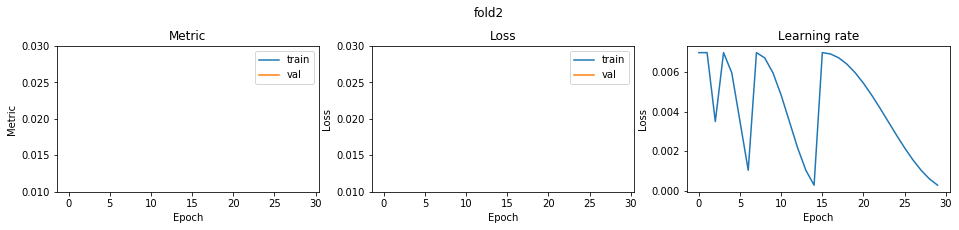

fold 3


epoch1 save best model... 0.70011426666603
epoch2 save best model... 0.6932119504465872
epoch3 save best model... 0.6889814411860664
epoch4 save best model... 0.681403574476481
epoch5 save best model... 0.6762673480907171
epoch6 save best model... 0.6695052582745128
epoch7 save best model... 0.6685794176164683
epoch8 save best model... 0.6615149695672315
epoch9 save best model... 0.6530792150790707
epoch10 save best model... 0.6449625409274004
epoch11 save best model... 0.6374018509187025
epoch12 save best model... 0.631002850711753
epoch13 save best model... 0.6284083122816064
epoch14 save best model... 0.6276274012813264
epoch16 save best model... 0.6157133529560984
epoch17 save best model... 0.6019161225722971
epoch18 save best model... 0.5867335799343222
epoch19 save best model... 0.570462501130506
epoch20 save best model... 0.5548073878049308
epoch21 save best model... 0.5390207666199408
epoch22 save best model... 0.523997755582892
epoch23 save best model... 0.5108938913682055
epo

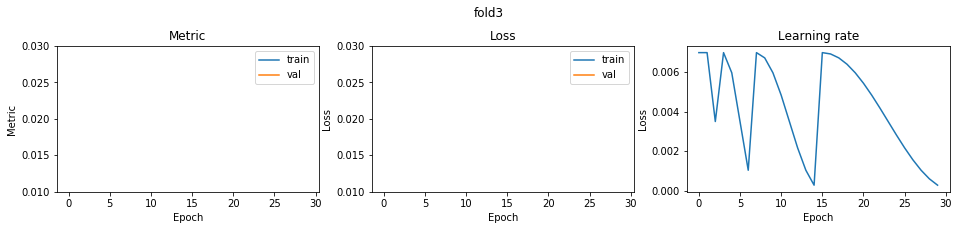

fold 4


epoch1 save best model... 0.7070377155697156
epoch2 save best model... 0.698286622206008
epoch3 save best model... 0.6940933734789525
epoch4 save best model... 0.6861707843517659
epoch5 save best model... 0.6772436697282118
epoch6 save best model... 0.675042771858615
epoch7 save best model... 0.6734659942244614
epoch8 save best model... 0.6659781906490717
epoch9 save best model... 0.6574409172855369
epoch10 save best model... 0.6471929709026102
epoch11 save best model... 0.6410910348957384
epoch12 save best model... 0.6378864153642589
epoch13 save best model... 0.635714357561837
epoch14 save best model... 0.6347179655333587
epoch15 save best model... 0.6341183992616136
epoch16 save best model... 0.6222519472139572
epoch17 save best model... 0.6094229616445398
epoch18 save best model... 0.5984098058626701
epoch19 save best model... 0.583290530554526
epoch20 save best model... 0.5679262435246165
epoch21 save best model... 0.5536211105305404
epoch22 save best model... 0.5361218650683184
e

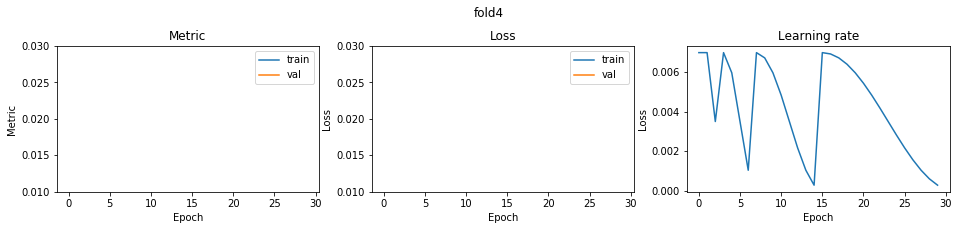

CV score: 0.479691480061556

optimizer: SGDW
fold 0


epoch1 save best model... 0.7656186022085046
epoch10 save best model... 0.6863920921073687
epoch11 save best model... 0.6314361384626401
epoch12 save best model... 0.6231222334918237
epoch14 save best model... 0.59247772028343
epoch17 save best model... 0.44812996392912635
epoch18 save best model... 0.44359500055161044
epoch19 save best model... 0.33623267523520084
epoch20 save best model... 0.2911430047625561
epoch21 save best model... 0.23731536762725247
epoch23 save best model... 0.23197931155121138
epoch24 save best model... 0.21005081490938105
epoch25 save best model... 0.18394211707530642
epoch27 save best model... 0.1754260884975518
fold0 score: 0.1754260892093679


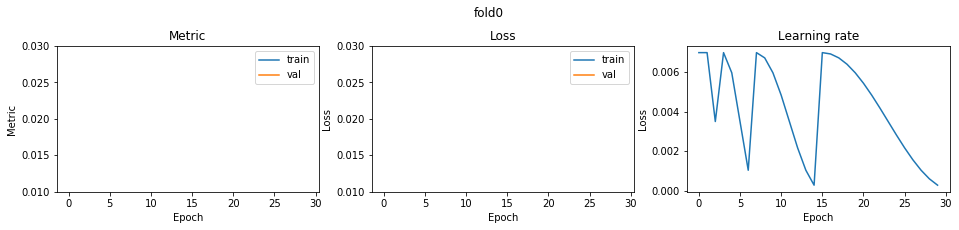

fold 1


epoch1 save best model... 0.7591103945350994
epoch6 save best model... 0.7092506393101037
epoch11 save best model... 0.6004438250136555
epoch16 save best model... 0.4905364439247898
epoch17 save best model... 0.44943572866683074
epoch18 save best model... 0.44430737395334363
epoch19 save best model... 0.30362553717973806
epoch21 save best model... 0.25761412252330596
epoch22 save best model... 0.21685101063852025
epoch23 save best model... 0.20115056012133906
epoch26 save best model... 0.18252886959586498
epoch29 save best model... 0.1816558986138336
epoch30 save best model... 0.14384420435832365
fold1 score: 0.14384420410461263


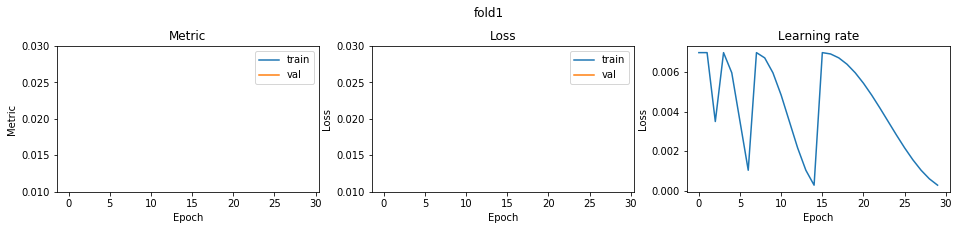

fold 2


epoch1 save best model... 0.7460889251065379
epoch11 save best model... 0.6291739995236765
epoch12 save best model... 0.6133286505224602
epoch15 save best model... 0.5706170600906649
epoch16 save best model... 0.49582004660855505
epoch17 save best model... 0.4810849837016668
epoch18 save best model... 0.402036926857864
epoch19 save best model... 0.34579198179381615
epoch20 save best model... 0.28030381969620355
epoch21 save best model... 0.26536885190795023
epoch22 save best model... 0.2419872430214091
epoch23 save best model... 0.22493302005333166
epoch24 save best model... 0.22210682033440007
epoch25 save best model... 0.2204410215913163
epoch26 save best model... 0.20254896921193744
epoch27 save best model... 0.1611448778257565
fold2 score: 0.16114487833644764


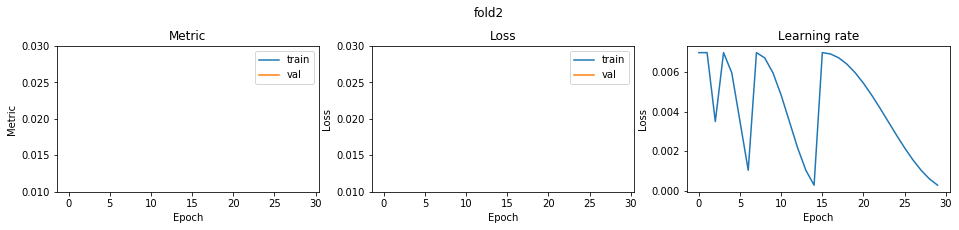

fold 3


epoch1 save best model... 0.7569117704665199
epoch8 save best model... 0.73277053249181
epoch10 save best model... 0.6977596861626402
epoch11 save best model... 0.5656346982052223
epoch13 save best model... 0.5024995052868794
epoch15 save best model... 0.4938593881819949
epoch16 save best model... 0.465877998812052
epoch17 save best model... 0.38978927922954865
epoch18 save best model... 0.3568613173070964
epoch19 save best model... 0.29688755979842096
epoch20 save best model... 0.27024350391026236
epoch21 save best model... 0.23824718902757336
epoch22 save best model... 0.16308481072103245
epoch25 save best model... 0.1573463456505795
epoch27 save best model... 0.13950157106465794
epoch28 save best model... 0.13468873707199966
fold3 score: 0.1346887364328409


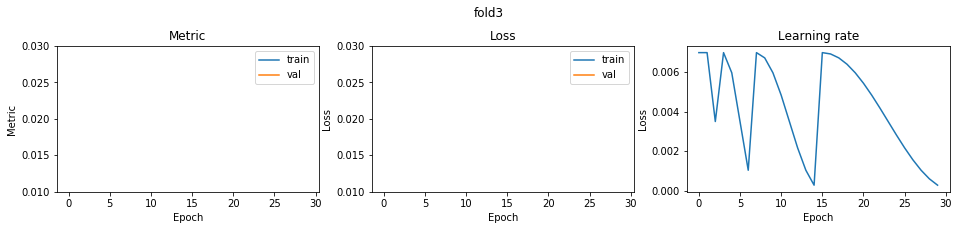

fold 4


epoch1 save best model... 0.7745815195363855
epoch9 save best model... 0.7742012275107086
epoch10 save best model... 0.7482598055060741
epoch11 save best model... 0.705973471500879
epoch12 save best model... 0.5825292781708181
epoch15 save best model... 0.5616406953959368
epoch17 save best model... 0.5009898913273235
epoch18 save best model... 0.407636715128916
epoch19 save best model... 0.35483978630334206
epoch20 save best model... 0.31460799300928594
epoch21 save best model... 0.24373549001295639
epoch25 save best model... 0.19663449299600239
epoch26 save best model... 0.19291232966548488
epoch28 save best model... 0.1417571393055905
fold4 score: 0.14175713904167725


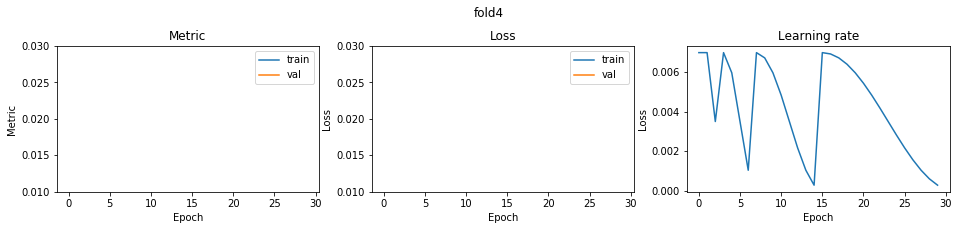

CV score: 0.15137210715309243

optimizer: SGD
fold 0


epoch1 save best model... 0.7107278088502298
epoch2 save best model... 0.7020923751361821
epoch3 save best model... 0.6983832016078106
epoch4 save best model... 0.690551260310588
epoch5 save best model... 0.6843603999033604
epoch6 save best model... 0.6788770866013877
epoch8 save best model... 0.6703576577551544
epoch9 save best model... 0.6613656748128643
epoch10 save best model... 0.6556062964752215
epoch11 save best model... 0.6488048650952298
epoch12 save best model... 0.6436117437542979
epoch13 save best model... 0.6411653513517358
epoch14 save best model... 0.6371638200006072
epoch16 save best model... 0.6281661818673779
epoch17 save best model... 0.6160063229552163
epoch18 save best model... 0.6042717432649912
epoch19 save best model... 0.5885664952643097
epoch20 save best model... 0.5728363803687563
epoch21 save best model... 0.5592560105823439
epoch22 save best model... 0.546893320105342
epoch23 save best model... 0.5310838799270248
epoch24 save best model... 0.517993995676279

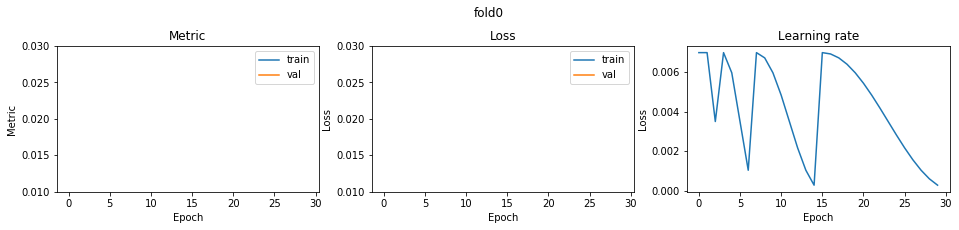

fold 1


epoch1 save best model... 0.705069327495668
epoch2 save best model... 0.6986902958169617
epoch3 save best model... 0.6934568137507635
epoch4 save best model... 0.6858527912830649
epoch5 save best model... 0.6786273756312955
epoch6 save best model... 0.6764636343121393
epoch7 save best model... 0.6744569938746149
epoch8 save best model... 0.6658211418886504
epoch9 save best model... 0.6581880930182221
epoch10 save best model... 0.6511391322388413
epoch11 save best model... 0.6447624379883977
epoch12 save best model... 0.6406533283805977
epoch13 save best model... 0.6365219794093245
epoch14 save best model... 0.6363762660840292
epoch15 save best model... 0.6355048382735844
epoch16 save best model... 0.624293515203645
epoch17 save best model... 0.6122993367167534
epoch18 save best model... 0.6006444492978913
epoch19 save best model... 0.5871869455331223
epoch20 save best model... 0.571743916612357
epoch21 save best model... 0.5580424931631134
epoch22 save best model... 0.5391880930977494


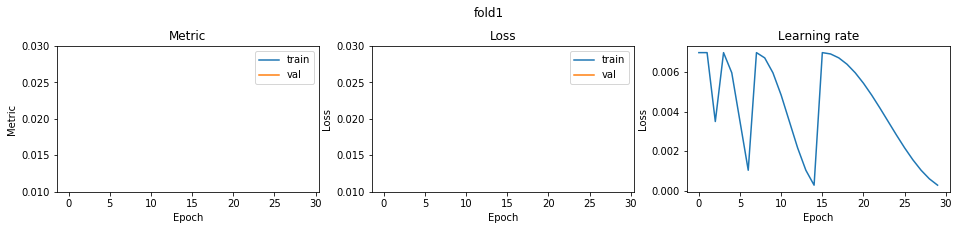

fold 2


epoch1 save best model... 0.7070577286674429
epoch2 save best model... 0.6962058093830837
epoch3 save best model... 0.6924490091414461
epoch4 save best model... 0.6847910858227305
epoch5 save best model... 0.6790644319787007
epoch6 save best model... 0.6759366454337175
epoch7 save best model... 0.6728072999739978
epoch8 save best model... 0.6664878406457299
epoch9 save best model... 0.6557807736175156
epoch10 save best model... 0.6511203306469294
epoch11 save best model... 0.6433018478290126
epoch12 save best model... 0.6367536364396956
epoch13 save best model... 0.6333945125484011
epoch14 save best model... 0.6323172353780142
epoch16 save best model... 0.6212652318975762
epoch17 save best model... 0.6091352723051676
epoch18 save best model... 0.596824024336896
epoch19 save best model... 0.5795751782098102
epoch20 save best model... 0.564793264711058
epoch21 save best model... 0.5488429580959217
epoch22 save best model... 0.5358139214170199
epoch23 save best model... 0.521682415132942


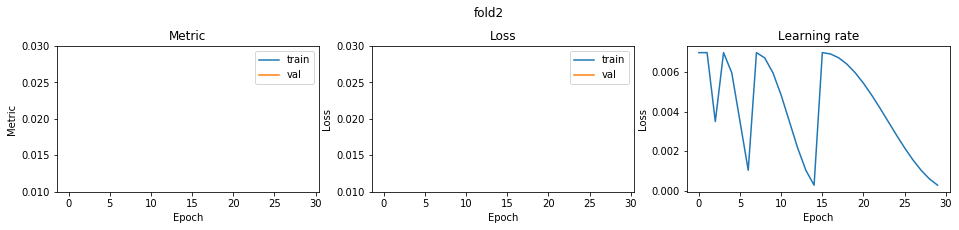

fold 3


epoch1 save best model... 0.7021457812237577
epoch2 save best model... 0.6958866923436489
epoch3 save best model... 0.6914933078381358
epoch4 save best model... 0.6845237346607894
epoch5 save best model... 0.677996737104342
epoch6 save best model... 0.6743650583851581
epoch7 save best model... 0.6713162547363507
epoch8 save best model... 0.6627503682106123
epoch9 save best model... 0.654694242276472
epoch10 save best model... 0.6508391531561937
epoch11 save best model... 0.6414771070512932
epoch12 save best model... 0.6375653925952173
epoch13 save best model... 0.6373870917224667
epoch14 save best model... 0.6329568795571294
epoch15 save best model... 0.6325984023155004
epoch16 save best model... 0.6211766991637019
epoch17 save best model... 0.6097054017703463
epoch18 save best model... 0.5971360698376267
epoch19 save best model... 0.5820659442751717
epoch20 save best model... 0.568452336847918
epoch21 save best model... 0.5532180260688677
epoch22 save best model... 0.5393704858347604


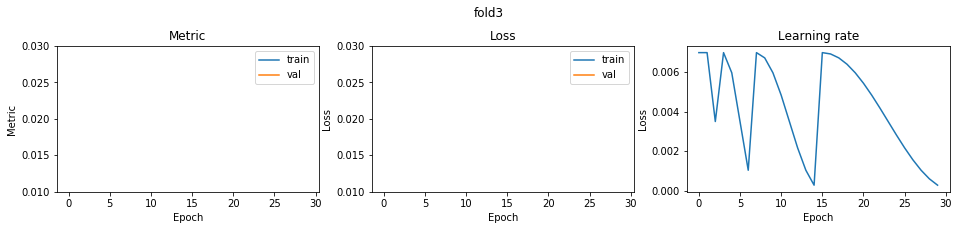

fold 4


epoch1 save best model... 0.7069279157762376
epoch2 save best model... 0.696875861158132
epoch3 save best model... 0.6946135987724965
epoch4 save best model... 0.6859012816652893
epoch5 save best model... 0.6773723354372185
epoch6 save best model... 0.6752322461176027
epoch7 save best model... 0.674053393979822
epoch8 save best model... 0.6654626301317932
epoch9 save best model... 0.6571660427134781
epoch10 save best model... 0.6492602287229482
epoch11 save best model... 0.6452272789896485
epoch12 save best model... 0.6399977743761415
epoch13 save best model... 0.6365173808534488
epoch14 save best model... 0.6338856091803462
epoch16 save best model... 0.6244235323610501
epoch17 save best model... 0.6144949469316522
epoch18 save best model... 0.6004017388630565
epoch19 save best model... 0.5871031110270419
epoch20 save best model... 0.5737380992035659
epoch21 save best model... 0.5599816432846434
epoch22 save best model... 0.5432486162641869
epoch23 save best model... 0.5325435505097982

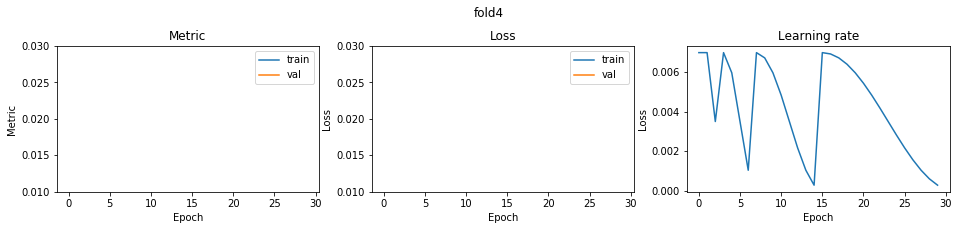

CV score: 0.48468538983668596

optimizer: AdaBelief
fold 0


Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  ---------
adabelief-pytorch=0.0.5  1e-08  False              False
Current version (0.1.0)  1e-16  True               True
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer

Weight decoupling enabled in AdaBelief
Rectification enabled in AdaBelief


epoch1 save best model... 0.01938778491847743
epoch2 save best model... 0.018284793331336594
epoch3 save best model... 0.01756991297600617
epoch5 save best model... 0.01726294667343344
epoch6 save best model... 0.01687475145541997
epoch7 save best model... 0.016526738766385645
epoch12 save best model... 0.016494104663304695
epoch13 save best model... 0.016227422286766945
epoch14 save best model... 0.01617373452226977
epoch15 save best model... 0.016127944066865976
fold0 score: 0.016127943917312423


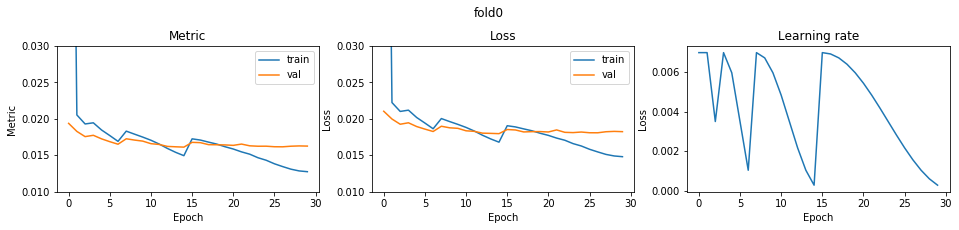

fold 1


Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  ---------
adabelief-pytorch=0.0.5  1e-08  False              False
Current version (0.1.0)  1e-16  True               True
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer

Weight decoupling enabled in AdaBelief
Rectification enabled in AdaBelief


epoch1 save best model... 0.01940356201423711
epoch2 save best model... 0.01859381781306604
epoch3 save best model... 0.0177435028956858
epoch5 save best model... 0.017409483074809187
epoch6 save best model... 0.017067181049595936
epoch7 save best model... 0.016780262271451175
epoch12 save best model... 0.016709345446143695
epoch13 save best model... 0.016569129107309913
epoch14 save best model... 0.016525123746016147
epoch15 save best model... 0.016457943838216173
fold1 score: 0.016457943782619153


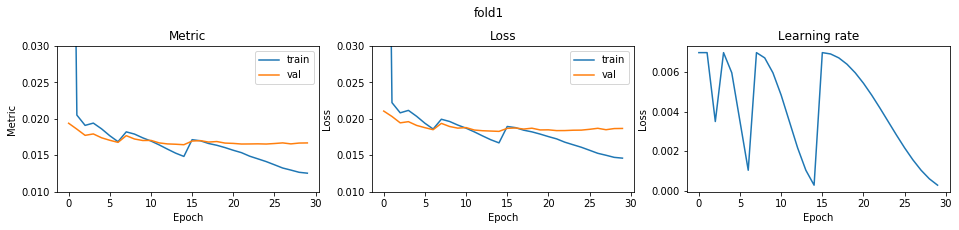

fold 2


Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  ---------
adabelief-pytorch=0.0.5  1e-08  False              False
Current version (0.1.0)  1e-16  True               True
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer

Weight decoupling enabled in AdaBelief
Rectification enabled in AdaBelief


epoch1 save best model... 0.01941170100051393
epoch2 save best model... 0.018378905415972945
epoch3 save best model... 0.01765913100954333
epoch5 save best model... 0.017428967867052537
epoch6 save best model... 0.01695605481667735
epoch7 save best model... 0.01659096814339777
epoch12 save best model... 0.0164781922230904
epoch13 save best model... 0.01632963934088689
epoch14 save best model... 0.01621083869272238
epoch15 save best model... 0.016168056845479943
fold2 score: 0.016168056763409107


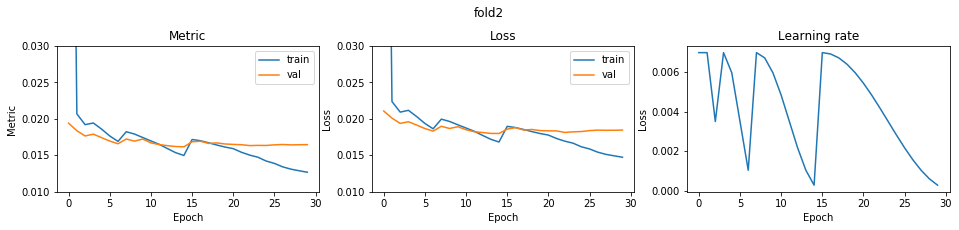

fold 3


Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  ---------
adabelief-pytorch=0.0.5  1e-08  False              False
Current version (0.1.0)  1e-16  True               True
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer

Weight decoupling enabled in AdaBelief
Rectification enabled in AdaBelief


epoch1 save best model... 0.01962241274909305
epoch2 save best model... 0.01855870462393978
epoch3 save best model... 0.017929183795267464
epoch4 save best model... 0.01789422040139081
epoch5 save best model... 0.017455965692521093
epoch6 save best model... 0.01713803220065077
epoch7 save best model... 0.016939210005376088
epoch12 save best model... 0.0166473956808346
epoch13 save best model... 0.016536567242633644
epoch14 save best model... 0.01641896447773539
epoch15 save best model... 0.016387409091861347
fold3 score: 0.01638740896885739


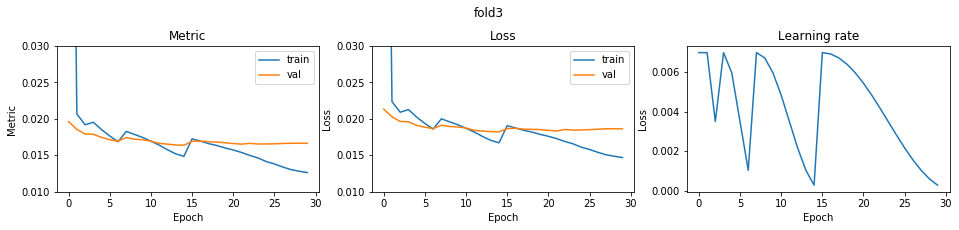

fold 4


Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  ---------
adabelief-pytorch=0.0.5  1e-08  False              False
Current version (0.1.0)  1e-16  True               True
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer

Weight decoupling enabled in AdaBelief
Rectification enabled in AdaBelief


epoch1 save best model... 0.018980976896347788
epoch2 save best model... 0.01833115101607351
epoch3 save best model... 0.017577621814686643
epoch5 save best model... 0.017485233710692657
epoch6 save best model... 0.017009340409944704
epoch7 save best model... 0.016776174684914342
epoch11 save best model... 0.016708955845895282
epoch13 save best model... 0.016497805059074947
epoch14 save best model... 0.016434376388533647
epoch15 save best model... 0.016390111253242558
epoch26 save best model... 0.016373186344641487
fold4 score: 0.016373186292887542


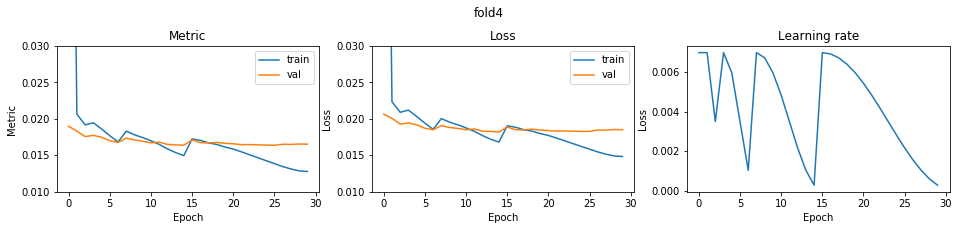

CV score: 0.016302907025359022

optimizer: AdaBound
fold 0


epoch1 save best model... 0.030823903085328723
epoch2 save best model... 0.03043631702271165
fold0 score: 0.030436316966583946


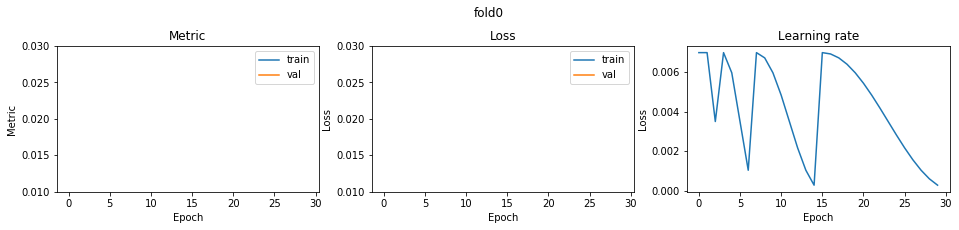

fold 1


epoch1 save best model... 0.031154330809659854
epoch2 save best model... 0.03067467953626972
epoch3 save best model... 0.030647374147209337
epoch4 save best model... 0.030629606911983433
fold1 score: 0.03062960695484086


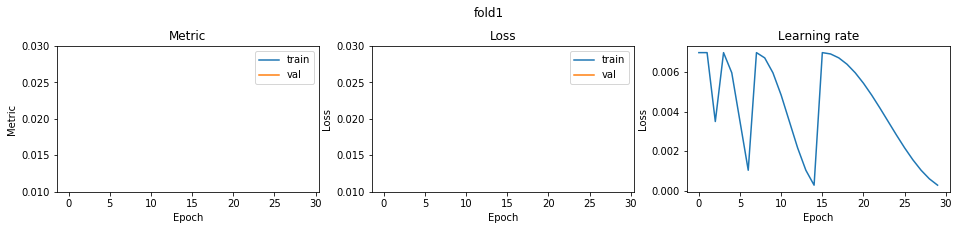

fold 2


epoch1 save best model... 0.030901679942309246
epoch2 save best model... 0.03052460687312661
epoch3 save best model... 0.030415888230650973
fold2 score: 0.030415888345467865


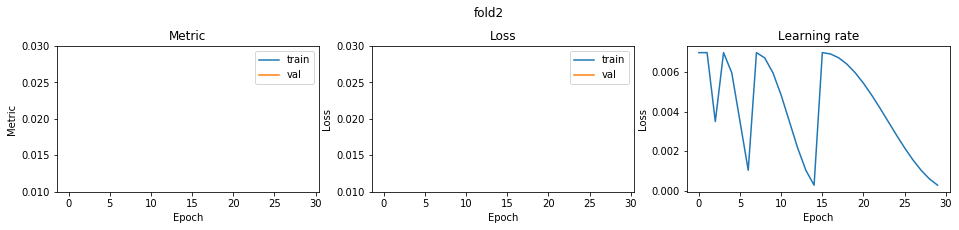

fold 3


epoch1 save best model... 0.03084314563194956
epoch2 save best model... 0.030577150790831224
fold3 score: 0.030577150775724017


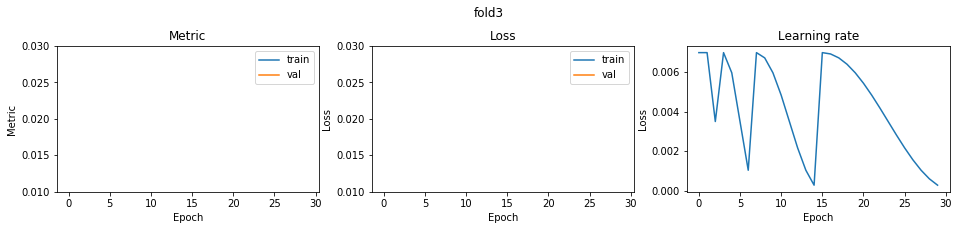

fold 4


epoch1 save best model... 0.03065144387678432
epoch2 save best model... 0.0301996983460454
fold4 score: 0.030199698514568867


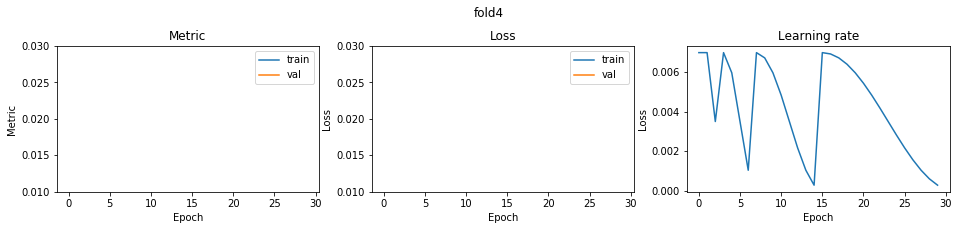

CV score: 0.03045172584020158

optimizer: AdaMod
fold 0


epoch1 save best model... 0.019865779697487727
epoch2 save best model... 0.018414769093410572
epoch3 save best model... 0.01767528591113237
epoch4 save best model... 0.01743826883545905
epoch5 save best model... 0.017296205659594242
epoch6 save best model... 0.01684936495722698
epoch7 save best model... 0.01653978696733645
epoch12 save best model... 0.01642552095556585
epoch13 save best model... 0.016224678157741767
epoch14 save best model... 0.01614837839834579
epoch15 save best model... 0.016072650709887438
fold0 score: 0.016072650598126452


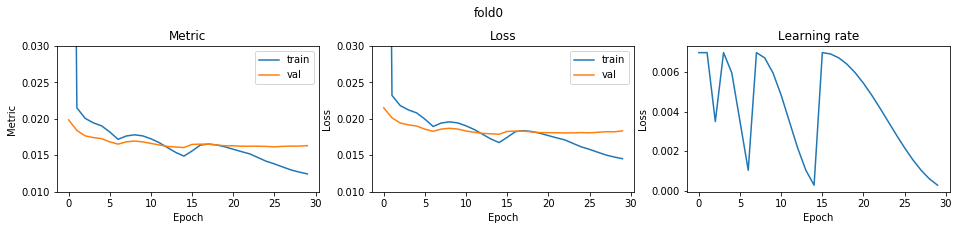

fold 1


epoch1 save best model... 0.020416530580818992
epoch2 save best model... 0.018680696049524784
epoch3 save best model... 0.017729644112562257
epoch5 save best model... 0.017446427258259074
epoch6 save best model... 0.017197391797026024
epoch7 save best model... 0.016803366858210846
epoch12 save best model... 0.01675747628273868
epoch13 save best model... 0.016597947211862696
epoch14 save best model... 0.016461590822513635
epoch15 save best model... 0.01640599057537551
fold1 score: 0.016405990595470616


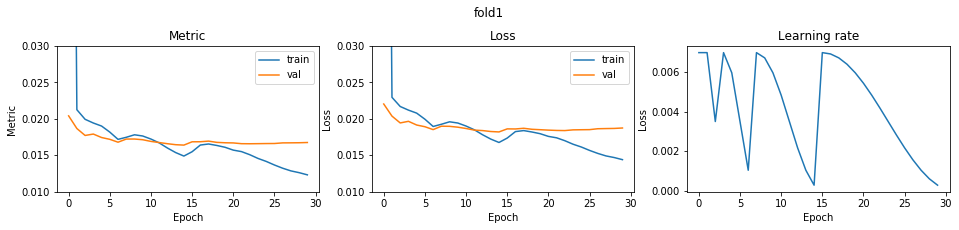

fold 2


epoch1 save best model... 0.020000373051724828
epoch2 save best model... 0.018690331176340946
epoch3 save best model... 0.017805013723296275
epoch4 save best model... 0.01759511408709901
epoch6 save best model... 0.017074966866851504
epoch7 save best model... 0.016645330198552213
epoch12 save best model... 0.016535029910618556
epoch13 save best model... 0.01626068595979311
epoch14 save best model... 0.01621608198746635
epoch15 save best model... 0.01612456856364642
fold2 score: 0.01612456854133872


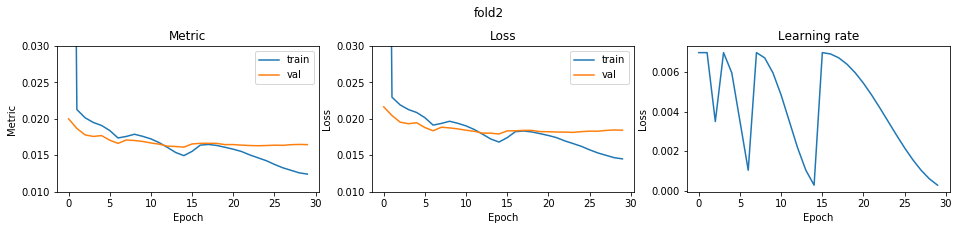

fold 3


epoch1 save best model... 0.02009069213478196
epoch2 save best model... 0.0185721350519797
epoch3 save best model... 0.01794338234295063
epoch4 save best model... 0.017818802036769298
epoch5 save best model... 0.017526332887233254
epoch6 save best model... 0.017148149235424393
epoch7 save best model... 0.016803264328127978
epoch12 save best model... 0.016721125732012652
epoch13 save best model... 0.016477558801294322
epoch14 save best model... 0.016401488389522857
epoch15 save best model... 0.01632370412358187
fold3 score: 0.01632370391299092


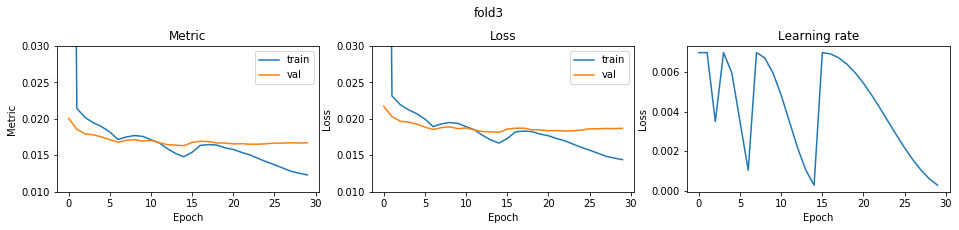

fold 4


epoch1 save best model... 0.019737190327231598
epoch2 save best model... 0.018498935873762352
epoch3 save best model... 0.01780505484152492
epoch4 save best model... 0.017605939918199812
epoch6 save best model... 0.017169816406329155
epoch7 save best model... 0.01669950923905761
epoch12 save best model... 0.01666062553296532
epoch13 save best model... 0.016484321863867835
epoch14 save best model... 0.01641673462970314
epoch15 save best model... 0.0163802985759592
fold4 score: 0.01637953242892464


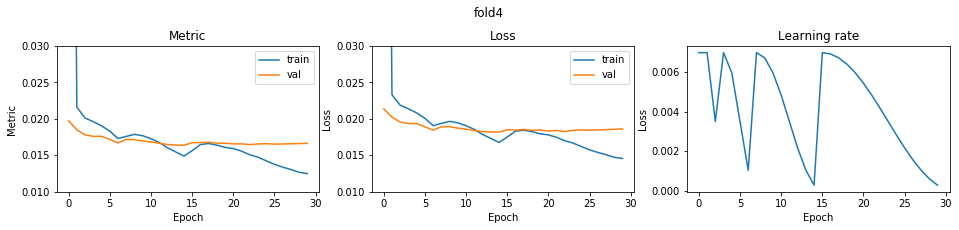

CV score: 0.016261288851751442

optimizer: AdamW
fold 0


epoch1 save best model... 0.0200601369923231
epoch2 save best model... 0.018771440244718943
epoch3 save best model... 0.017843573083061563
epoch4 save best model... 0.017661997339855837
epoch5 save best model... 0.017439619050380308
epoch6 save best model... 0.0169644850270148
epoch7 save best model... 0.01669943298813558
epoch11 save best model... 0.016575002781452786
epoch12 save best model... 0.016404703631997107
epoch13 save best model... 0.016236002686388945
epoch14 save best model... 0.01614496375313177
epoch15 save best model... 0.016135314632639935
fold0 score: 0.01613531446222208


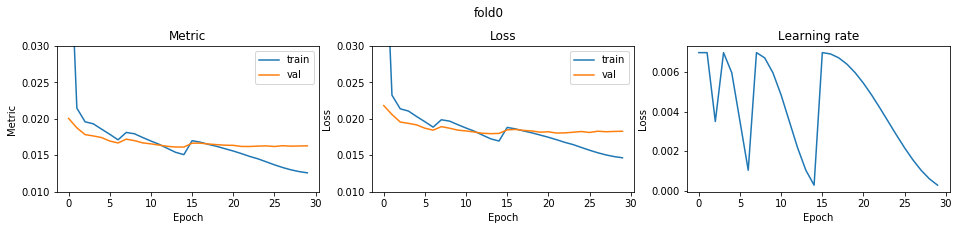

fold 1


epoch1 save best model... 0.020256583791715892
epoch2 save best model... 0.01909754989470537
epoch3 save best model... 0.017948009007529533
epoch5 save best model... 0.017473466923100908
epoch6 save best model... 0.017153070801620766
epoch7 save best model... 0.01692366139828738
epoch12 save best model... 0.016740328446836955
epoch13 save best model... 0.016554305806932564
epoch14 save best model... 0.01645213051888592
epoch15 save best model... 0.0164202817837292
fold1 score: 0.016420281649928887


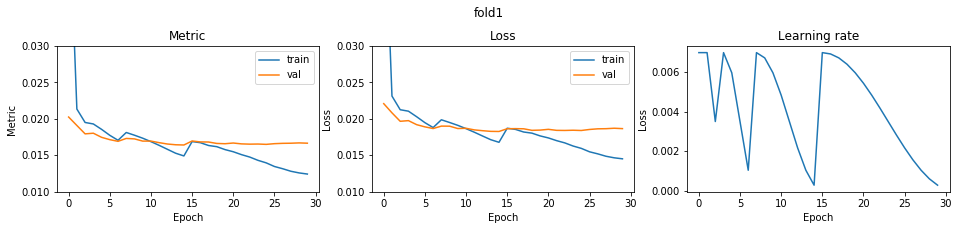

fold 2


epoch1 save best model... 0.019996878658127448
epoch2 save best model... 0.01840182141701978
epoch3 save best model... 0.017740708775181763
epoch4 save best model... 0.017730974915228813
epoch5 save best model... 0.017415381274569087
epoch6 save best model... 0.016874480789909673
epoch7 save best model... 0.016677985134825032
epoch11 save best model... 0.016657296963049642
epoch12 save best model... 0.016501951253342518
epoch13 save best model... 0.016303035564717235
epoch14 save best model... 0.016233798354528005
epoch15 save best model... 0.016153262554241165
fold2 score: 0.01615326242067126


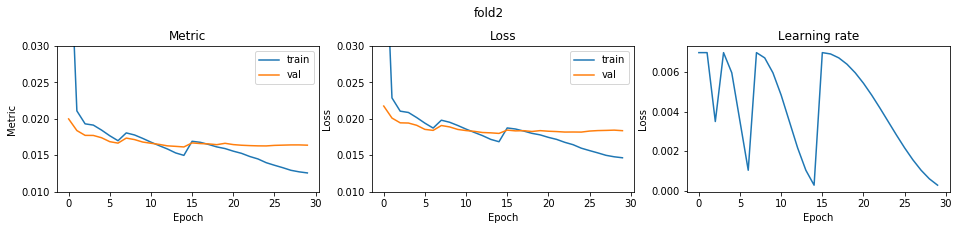

fold 3


epoch1 save best model... 0.020169399422858596
epoch2 save best model... 0.018620108772739598
epoch3 save best model... 0.017868401132235496
epoch4 save best model... 0.01784311645157245
epoch5 save best model... 0.017532418413694465
epoch6 save best model... 0.01712329367129026
epoch7 save best model... 0.016921603027519033
epoch11 save best model... 0.016862374880607822
epoch12 save best model... 0.016718354591662765
epoch13 save best model... 0.016596954475010584
epoch14 save best model... 0.01644977155716449
epoch15 save best model... 0.01643031746327266
fold3 score: 0.01643031732682864


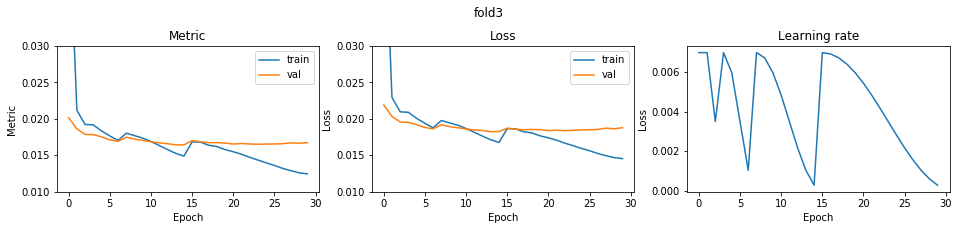

fold 4


epoch1 save best model... 0.019703618824855343
epoch2 save best model... 0.018498217371336962
epoch3 save best model... 0.017695701874979264
epoch5 save best model... 0.017269466611597017
epoch6 save best model... 0.016986574488851096
epoch7 save best model... 0.016744477761345057
epoch12 save best model... 0.01660192296893287
epoch13 save best model... 0.0164056763307516
epoch14 save best model... 0.01635343609314098
epoch15 save best model... 0.016339523360930842
fold4 score: 0.01633952320596457


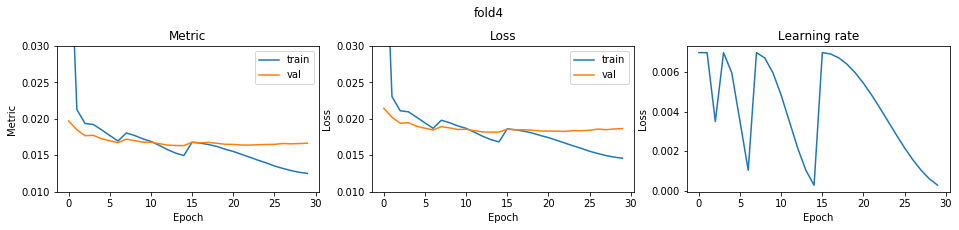

CV score: 0.016295740630307146

optimizer: AdamP
fold 0


epoch1 save best model... 0.019923176166679973
epoch2 save best model... 0.018357120825991814
epoch3 save best model... 0.01767824167355997
epoch4 save best model... 0.017665116930198017
epoch5 save best model... 0.017200631934275387
epoch6 save best model... 0.016947023544231415
epoch7 save best model... 0.016594922858245823
epoch12 save best model... 0.016435478343405592
epoch13 save best model... 0.016247947399498117
epoch14 save best model... 0.01613185935460693
epoch15 save best model... 0.016101321637002508
fold0 score: 0.016101321443665672


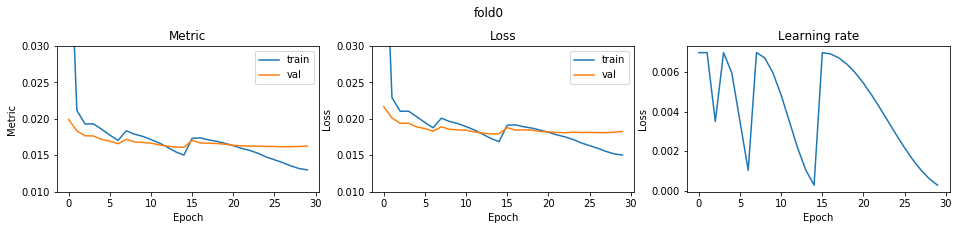

fold 1


epoch1 save best model... 0.020086190762373033
epoch2 save best model... 0.018555019837654542
epoch3 save best model... 0.01794262309863189
epoch4 save best model... 0.01789603278713119
epoch5 save best model... 0.017455233780017447
epoch6 save best model... 0.017120080739242743
epoch7 save best model... 0.01681057464371281
epoch12 save best model... 0.016719722955032087
epoch13 save best model... 0.0165916732891182
epoch14 save best model... 0.016493176853619083
epoch15 save best model... 0.016438196013019754
fold1 score: 0.016438196052602796


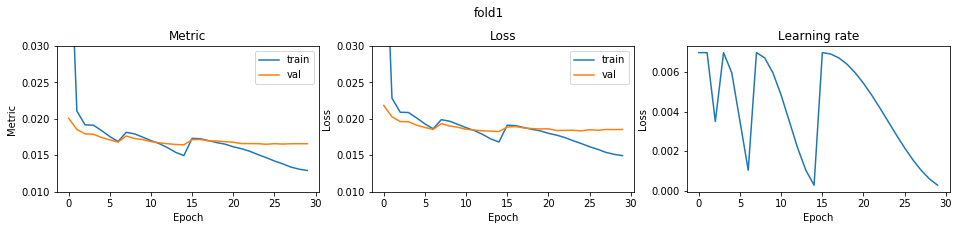

fold 2


epoch1 save best model... 0.020169258787362282
epoch2 save best model... 0.018576888553416247
epoch3 save best model... 0.017753447716859185
epoch4 save best model... 0.01761284530333416
epoch5 save best model... 0.017576543518356295
epoch6 save best model... 0.017007919055986687
epoch7 save best model... 0.016663654387170372
epoch12 save best model... 0.016513860757946697
epoch13 save best model... 0.01641844687688443
epoch14 save best model... 0.016258713802652498
epoch15 save best model... 0.016220408399909986
fold2 score: 0.016220408322659252


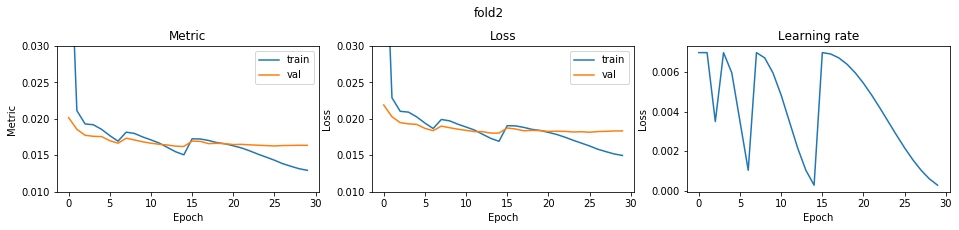

fold 3


epoch1 save best model... 0.0203348841441791
epoch2 save best model... 0.01860048785118348
epoch3 save best model... 0.01793714479961197
epoch4 save best model... 0.01770404126019915
epoch5 save best model... 0.01759276515963341
epoch6 save best model... 0.017216110759433825
epoch7 save best model... 0.016884878356272785
epoch11 save best model... 0.016878890850345746
epoch12 save best model... 0.01670614557811706
epoch13 save best model... 0.016557211942699206
epoch14 save best model... 0.016445273955210466
epoch15 save best model... 0.01641995993215837
fold3 score: 0.01641995985503964


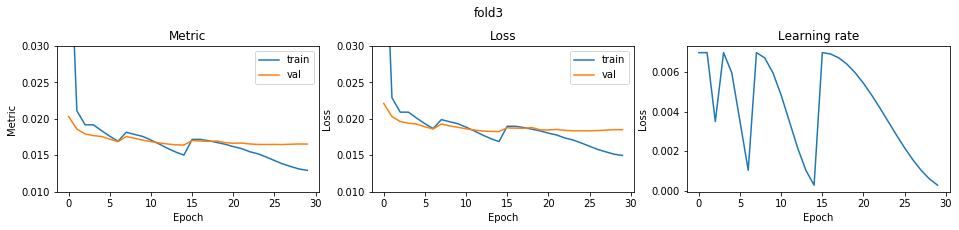

fold 4


epoch1 save best model... 0.01983701015116142
epoch2 save best model... 0.018291696519983386
epoch3 save best model... 0.017631026616655204
epoch5 save best model... 0.017324865205905024
epoch6 save best model... 0.016963798426736596
epoch7 save best model... 0.01675585188090394
epoch12 save best model... 0.016562552922797773
epoch13 save best model... 0.016484534353068722
epoch14 save best model... 0.016346692716477942
epoch15 save best model... 0.01632114485169258
fold4 score: 0.016320378693397065


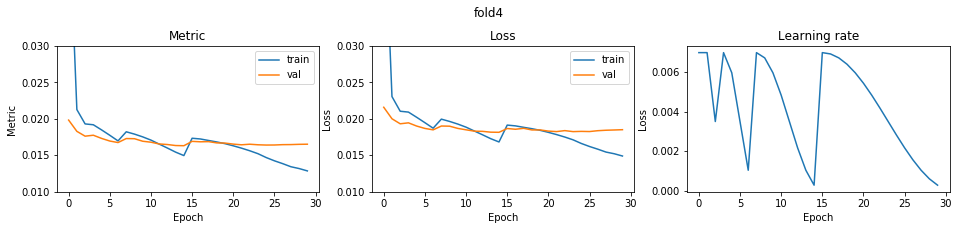

CV score: 0.016300050208144456

optimizer: DiffGrad
fold 0


epoch1 save best model... 0.03170954561654419
epoch21 save best model... 0.03154836298308095
fold0 score: 0.03154836349849423


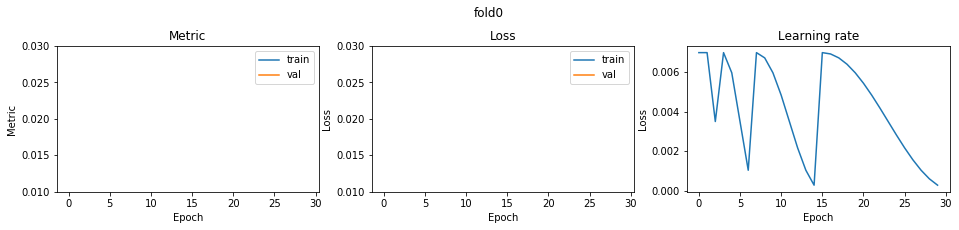

fold 1


epoch1 save best model... 0.03146685013285692
fold1 score: 0.03146685008488902


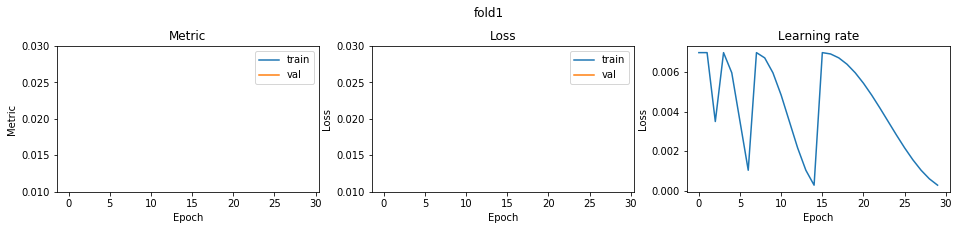

fold 2


epoch1 save best model... 0.03198097421182712
epoch11 save best model... 0.031815635927376296
epoch17 save best model... 0.03169051382761117
fold2 score: 0.03169051287427456


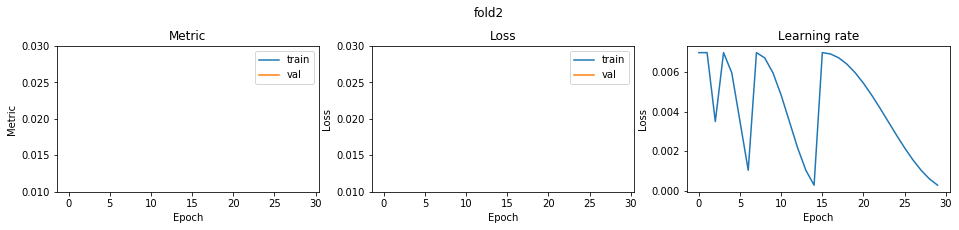

fold 3


epoch1 save best model... 0.03179613929284325
fold3 score: 0.03179613929250763


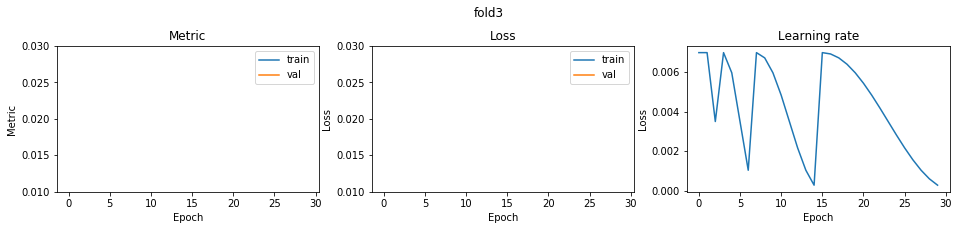

fold 4


epoch1 save best model... 0.03169519930551834
epoch26 save best model... 0.03159496414736083
fold4 score: 0.03159496349948401


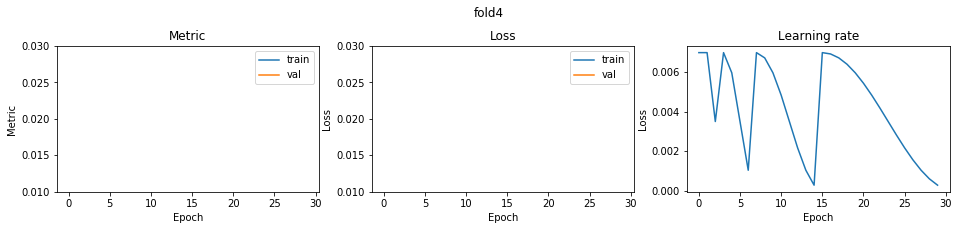

CV score: 0.03161936955727182

optimizer: Lamb
fold 0


epoch1 save best model... 0.02009652682022109
epoch2 save best model... 0.018278673276780406
epoch3 save best model... 0.017675556377391065
epoch4 save best model... 0.01751546364761295
epoch5 save best model... 0.017162517424257034
epoch6 save best model... 0.016912755713817198
epoch7 save best model... 0.016784127560658443
epoch9 save best model... 0.016748481470421125
epoch10 save best model... 0.016615045653626426
epoch11 save best model... 0.016535107402771643
epoch12 save best model... 0.01641921504169431
epoch13 save best model... 0.016296068843717183
epoch14 save best model... 0.016255309134891472
fold0 score: 0.016255309068090296


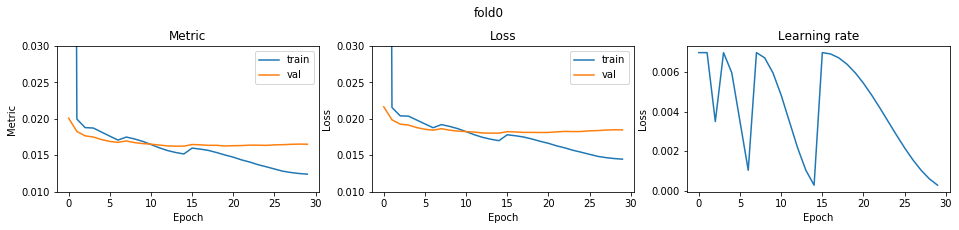

fold 1


epoch1 save best model... 0.020060280970694344
epoch2 save best model... 0.01854534381412786
epoch3 save best model... 0.01781561918001589
epoch4 save best model... 0.017763548901342373
epoch5 save best model... 0.017490437786918372
epoch6 save best model... 0.017176536097104064
epoch7 save best model... 0.01708241033383303
epoch10 save best model... 0.016857698191391032
epoch11 save best model... 0.016746989284351546
epoch12 save best model... 0.016682134482879713
epoch13 save best model... 0.01659884079178894
epoch14 save best model... 0.016515204733024157
fold1 score: 0.016515204664780726


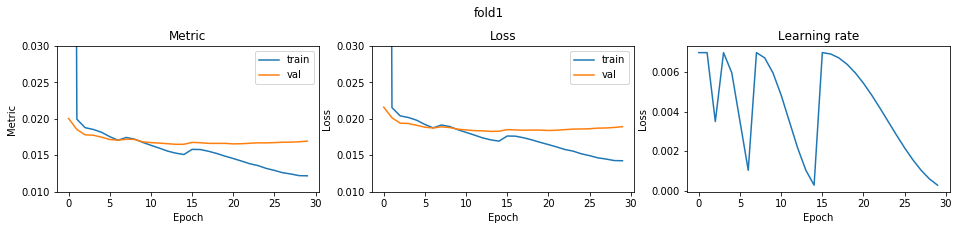

fold 2


epoch1 save best model... 0.019925812817388526
epoch2 save best model... 0.018501956215076103
epoch3 save best model... 0.0177599826454607
epoch4 save best model... 0.017622487701002002
epoch5 save best model... 0.017247701789882466
epoch6 save best model... 0.016943550125650568
epoch7 save best model... 0.01677463217715884
epoch10 save best model... 0.016670843168089877
epoch11 save best model... 0.016520063518225048
epoch12 save best model... 0.01649352955941928
epoch13 save best model... 0.01638187760074268
epoch14 save best model... 0.016345571282437067
epoch15 save best model... 0.01632964607446157
fold2 score: 0.016329646123679556


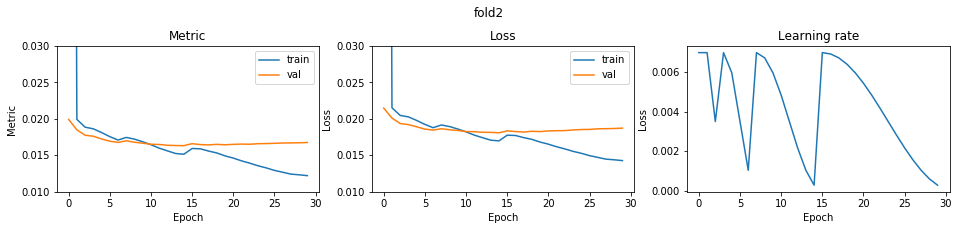

fold 3


epoch1 save best model... 0.020253482108388374
epoch2 save best model... 0.018428848316820852
epoch3 save best model... 0.017853151122214174
epoch4 save best model... 0.017807561302120568
epoch5 save best model... 0.017466216296772207
epoch6 save best model... 0.017216538317111195
epoch7 save best model... 0.01701878201818955
epoch9 save best model... 0.016994808922714825
epoch10 save best model... 0.016970782351504017
epoch11 save best model... 0.016768356231476152
epoch12 save best model... 0.016654544661844104
epoch13 save best model... 0.016593287353550246
epoch14 save best model... 0.016534051475600935
fold3 score: 0.016534051376674862


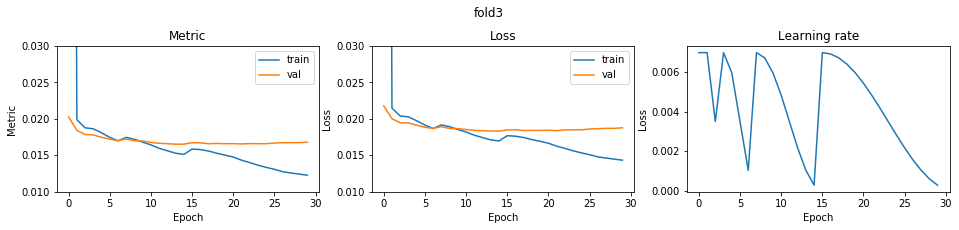

fold 4


epoch1 save best model... 0.019799647923211032
epoch2 save best model... 0.018387359032801996
epoch3 save best model... 0.017746917886027308
epoch4 save best model... 0.01769902192370156
epoch5 save best model... 0.01735779334046371
epoch6 save best model... 0.01710585312608095
epoch7 save best model... 0.016964750295263082
epoch9 save best model... 0.016936664214115885
epoch10 save best model... 0.016851941663729438
epoch11 save best model... 0.016682556519764295
epoch12 save best model... 0.016595839323361398
epoch13 save best model... 0.016546951180031196
epoch14 save best model... 0.01647172395122961
epoch15 save best model... 0.016461698906517382
fold4 score: 0.01646169886946749


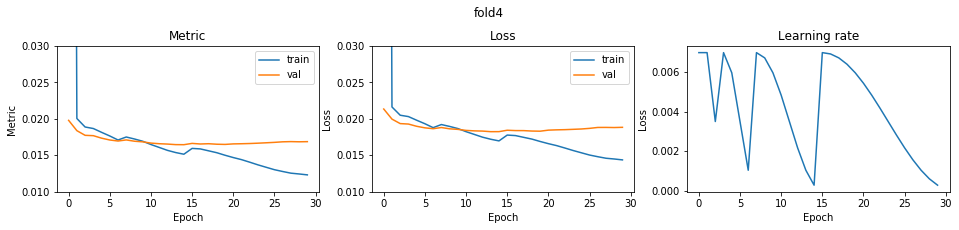

CV score: 0.01641918172498786

optimizer: NovoGrad
fold 0


epoch1 save best model... 0.018574860748879457
epoch2 save best model... 0.017657787730420912
epoch3 save best model... 0.01726780431705754
epoch4 save best model... 0.017192820070103525
epoch5 save best model... 0.01702456478759273
epoch6 save best model... 0.016706599759315575
epoch7 save best model... 0.01651649161715035
epoch11 save best model... 0.016499664104524532
epoch12 save best model... 0.016288725656705458
epoch13 save best model... 0.016240178096131475
epoch14 save best model... 0.01617362302068222
epoch15 save best model... 0.016115302096517726
fold0 score: 0.016115302199535046


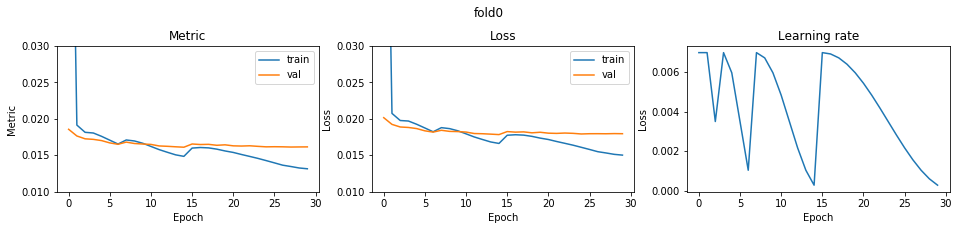

fold 1


epoch1 save best model... 0.018797861674440208
epoch2 save best model... 0.018021496681220224
epoch3 save best model... 0.01760402376264653
epoch4 save best model... 0.017476384200989237
epoch5 save best model... 0.01724649269637132
epoch6 save best model... 0.01697917896630376
epoch7 save best model... 0.016794138692623257
epoch11 save best model... 0.01670835747564537
epoch12 save best model... 0.01665943867118898
epoch13 save best model... 0.016558836480760918
epoch14 save best model... 0.01651817703109059
epoch15 save best model... 0.0164842313037976
fold1 score: 0.016484231319615475


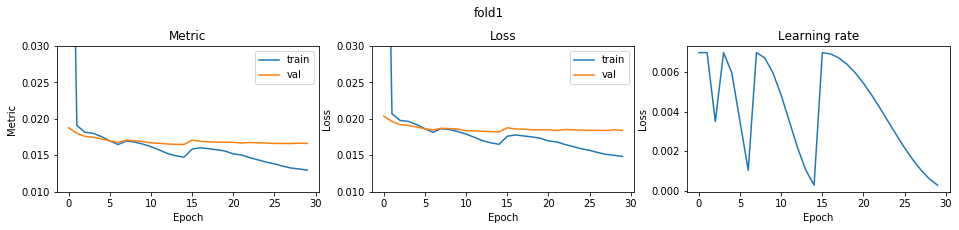

fold 2


epoch1 save best model... 0.018563468417496093
epoch2 save best model... 0.017840433417630374
epoch3 save best model... 0.017378843640477842
epoch4 save best model... 0.01723355842713079
epoch5 save best model... 0.01701341064357831
epoch6 save best model... 0.01673317346216864
epoch7 save best model... 0.016536739816319212
epoch11 save best model... 0.01647638774114729
epoch12 save best model... 0.016349043241536722
epoch13 save best model... 0.01626352043930627
epoch14 save best model... 0.016218911905854255
epoch15 save best model... 0.01619122539451492
fold2 score: 0.016191225453355988


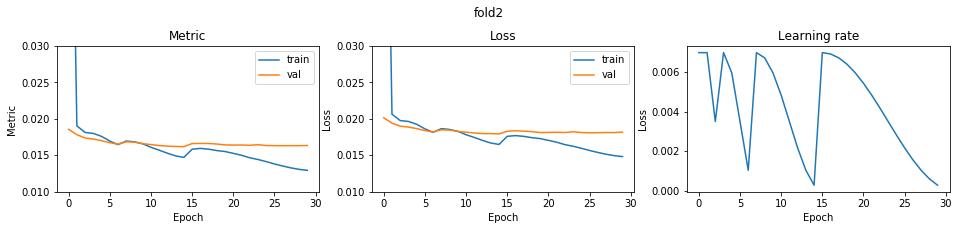

fold 3


epoch1 save best model... 0.01876856371726425
epoch2 save best model... 0.017953564684439222
epoch3 save best model... 0.01753459650819489
epoch4 save best model... 0.01746505508262978
epoch5 save best model... 0.017238325760158834
epoch6 save best model... 0.01691484627333005
epoch7 save best model... 0.016826317572631026
epoch11 save best model... 0.0166853967129098
epoch12 save best model... 0.016515922981286783
epoch13 save best model... 0.016472400598024316
epoch14 save best model... 0.016408415846441763
epoch15 save best model... 0.016367601952462507
fold3 score: 0.01636760195772082


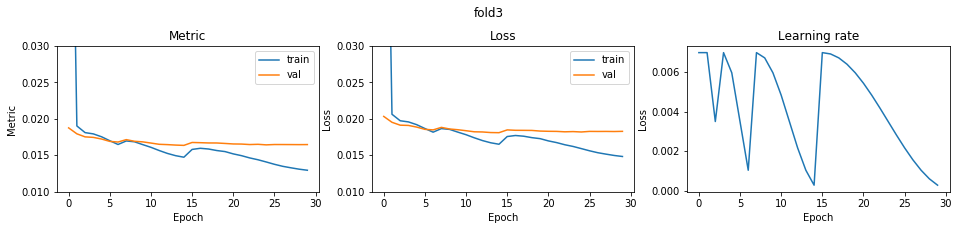

fold 4


epoch1 save best model... 0.0184251694827593
epoch2 save best model... 0.0178729159986613
epoch3 save best model... 0.017359139920044734
epoch4 save best model... 0.017275864062385297
epoch5 save best model... 0.01713462483884601
epoch6 save best model... 0.016846017113086982
epoch7 save best model... 0.01666896704049751
epoch10 save best model... 0.0166256450723373
epoch11 save best model... 0.016613966791735695
epoch12 save best model... 0.016500040749194003
epoch13 save best model... 0.016357878538311072
epoch15 save best model... 0.016342825187552628
fold4 score: 0.016342825100893073


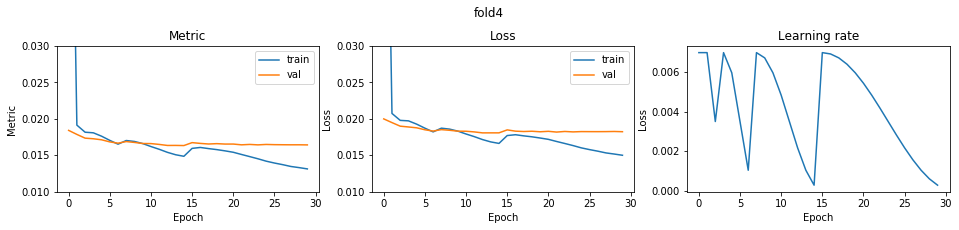

CV score: 0.016300233789859925

optimizer: PlainRAdam
fold 0


epoch1 save best model... 0.02033859429571243
epoch2 save best model... 0.018903836617267484
epoch3 save best model... 0.018050561199529025
epoch4 save best model... 0.01804654195412552
epoch5 save best model... 0.01751588638659762
epoch6 save best model... 0.017066986171490512
epoch7 save best model... 0.016764977537859275
epoch11 save best model... 0.016613046269108603
epoch12 save best model... 0.016468886551627537
epoch13 save best model... 0.016309485510670515
epoch14 save best model... 0.016187034599092664
epoch15 save best model... 0.01612287129706158
epoch25 save best model... 0.01602651860166112
fold0 score: 0.016026518397745555


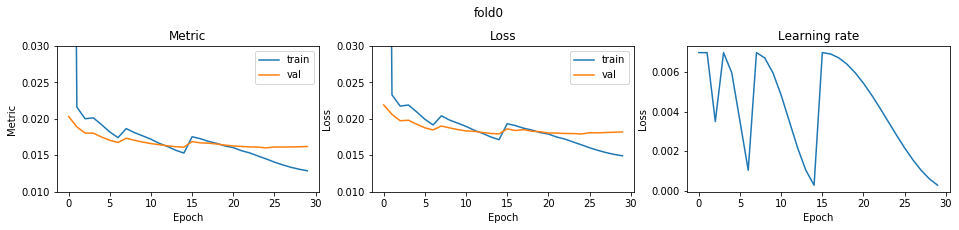

fold 1


epoch1 save best model... 0.020445931998227283
epoch2 save best model... 0.019165705906439002
epoch3 save best model... 0.018188173032399054
epoch4 save best model... 0.01800640067563062
epoch5 save best model... 0.0176942287834977
epoch6 save best model... 0.017281415897527
epoch7 save best model... 0.016962774077336578
epoch11 save best model... 0.01690635709934434
epoch12 save best model... 0.016747035848782718
epoch13 save best model... 0.01659830718915116
epoch14 save best model... 0.01648620514661298
epoch15 save best model... 0.016470445235768887
fold1 score: 0.016470445137684718


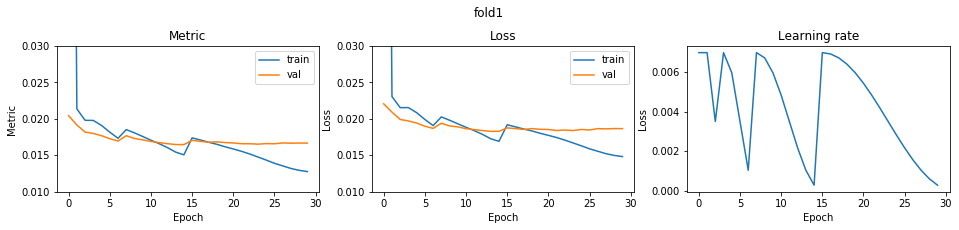

fold 2


epoch1 save best model... 0.02054939140546808
epoch2 save best model... 0.019136506039628028
epoch3 save best model... 0.01816660516183865
epoch4 save best model... 0.018095618247982444
epoch5 save best model... 0.017657491631634444
epoch6 save best model... 0.017205691790493836
epoch7 save best model... 0.016848603110504966
epoch11 save best model... 0.01676160660011095
epoch12 save best model... 0.016593035205894828
epoch13 save best model... 0.016450128610349647
epoch14 save best model... 0.01631359633301909
epoch15 save best model... 0.016263363345197894
fold2 score: 0.016263363370484347


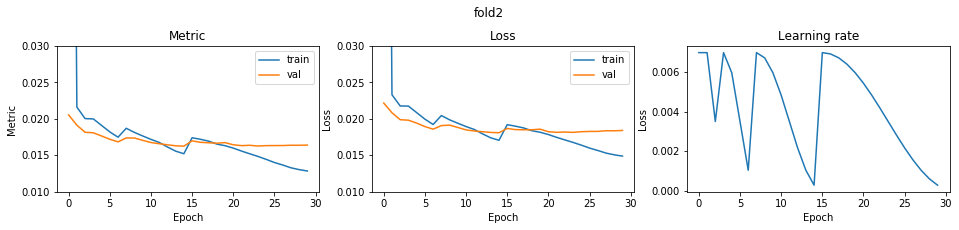

fold 3


epoch1 save best model... 0.02046349021120332
epoch2 save best model... 0.019012503025539914
epoch3 save best model... 0.018103179252008505
epoch5 save best model... 0.017816880099679043
epoch6 save best model... 0.017243325787942205
epoch7 save best model... 0.016980729985277852
epoch11 save best model... 0.016948423393766537
epoch12 save best model... 0.016697632408529044
epoch13 save best model... 0.016550520796897335
epoch14 save best model... 0.016426633821125726
epoch15 save best model... 0.01636830626526563
fold3 score: 0.016368306221103922


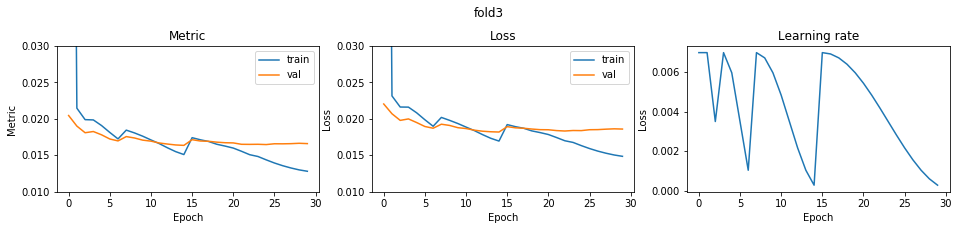

fold 4


epoch1 save best model... 0.020069285761352824
epoch2 save best model... 0.018831315552624864
epoch3 save best model... 0.01793585622891071
epoch5 save best model... 0.017752973463785134
epoch6 save best model... 0.017194569314955173
epoch7 save best model... 0.01690620298631031
epoch12 save best model... 0.016779784118684523
epoch13 save best model... 0.016503424815205614
epoch14 save best model... 0.01649769836260273
epoch15 save best model... 0.016497197995017494
epoch24 save best model... 0.016450130760856396
fold4 score: 0.016450130586043655


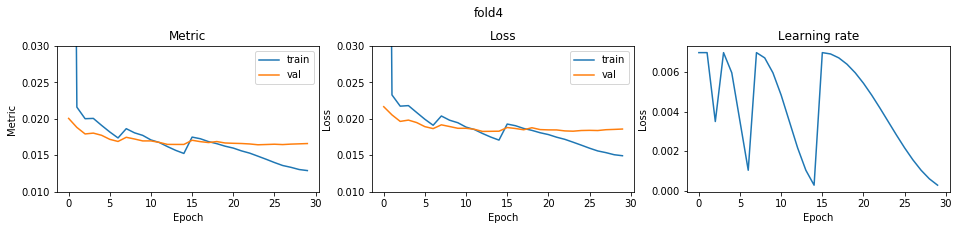

CV score: 0.01631574808145776

optimizer: QHAdam
fold 0


epoch1 save best model... 0.03179580162625106
fold0 score: 0.031795801639117535


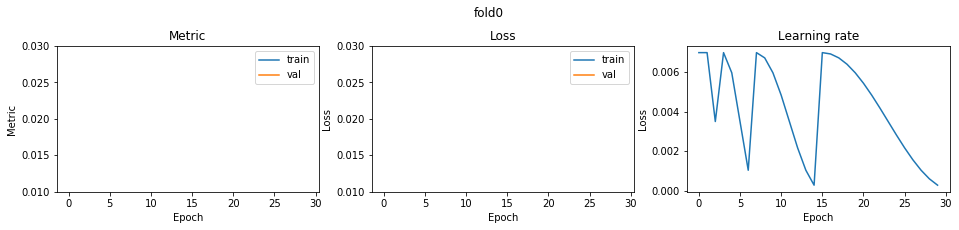

fold 1


epoch1 save best model... 0.031973484470696784
epoch2 save best model... 0.031887146458623894
epoch22 save best model... 0.03186627726863554
fold1 score: 0.03186627951203359


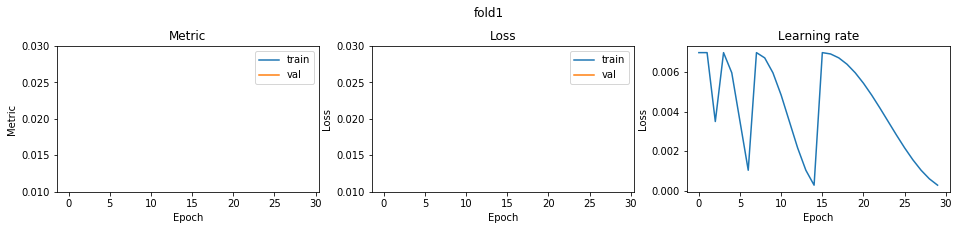

fold 2


epoch1 save best model... 0.03213910545579161
epoch11 save best model... 0.03163007629653755
fold2 score: 0.0316300772779591


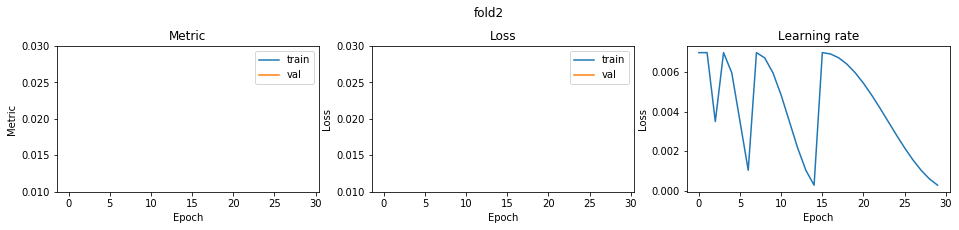

fold 3


epoch1 save best model... 0.03194150930028706
fold3 score: 0.03194150916188684


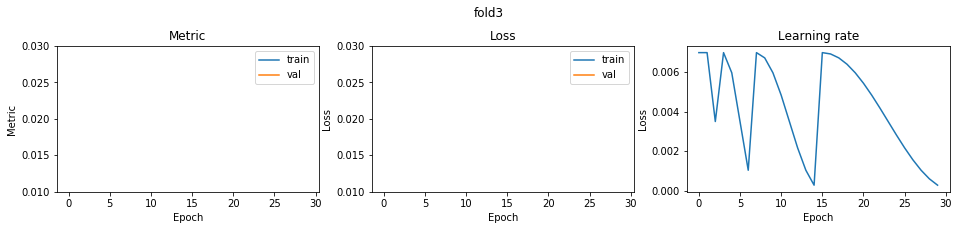

fold 4


epoch1 save best model... 0.03221664188391527
epoch2 save best model... 0.03201454308113096
epoch11 save best model... 0.03187471276026109
epoch20 save best model... 0.03132541066285961
fold4 score: 0.03132540961178362


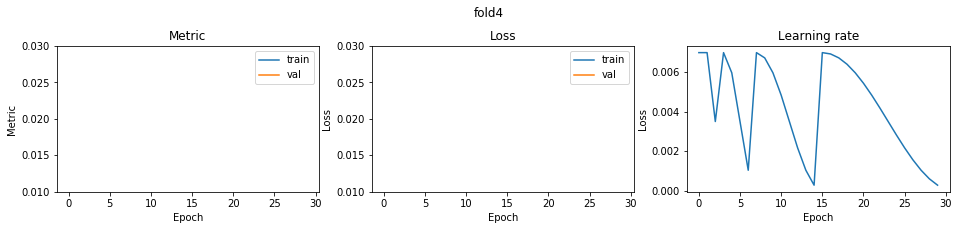

CV score: 0.03171181212700097

optimizer: RAdam
fold 0


epoch1 save best model... 0.0208583637011282
epoch2 save best model... 0.019109297062616142
epoch3 save best model... 0.0180810220004961
epoch5 save best model... 0.017487796082040444
epoch6 save best model... 0.017223913877659345
epoch7 save best model... 0.01672955031309421
epoch11 save best model... 0.016659862353786793
epoch12 save best model... 0.016516092771787307
epoch13 save best model... 0.016338358781298364
epoch14 save best model... 0.01625082350775158
epoch15 save best model... 0.016185747976319394
epoch24 save best model... 0.016183555974775676
epoch25 save best model... 0.016148480735634345
fold0 score: 0.016148480706402218


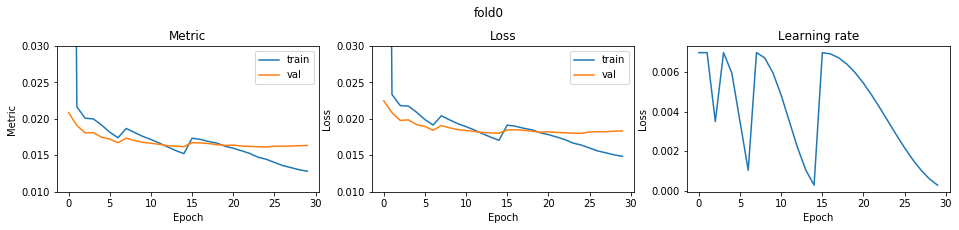

fold 1


epoch1 save best model... 0.02048315357448273
epoch2 save best model... 0.0189724876610089
epoch3 save best model... 0.018203318052844322
epoch5 save best model... 0.01770952714984402
epoch6 save best model... 0.017305532096246225
epoch7 save best model... 0.016972900148227346
epoch11 save best model... 0.016921559265946493
epoch12 save best model... 0.016713785423497645
epoch13 save best model... 0.0165870923726756
epoch14 save best model... 0.016440814931355595
epoch15 save best model... 0.016416707209390573
fold1 score: 0.016416707138860395


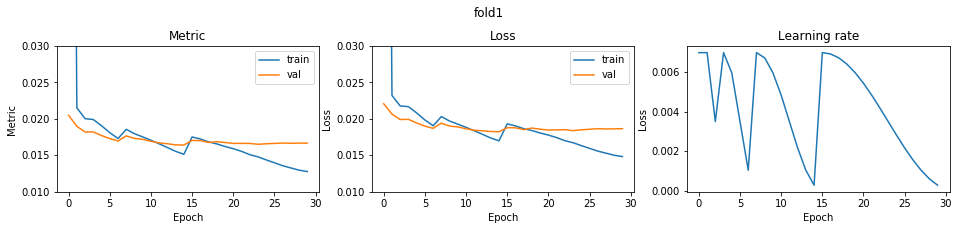

fold 2


epoch1 save best model... 0.020539045003687337
epoch2 save best model... 0.019204774952526923
epoch3 save best model... 0.018057820697837672
epoch5 save best model... 0.01766227697497363
epoch6 save best model... 0.017132198344894885
epoch7 save best model... 0.01679529295311203
epoch11 save best model... 0.016715090713782226
epoch12 save best model... 0.016584518154003837
epoch13 save best model... 0.016415468330320423
epoch14 save best model... 0.016267533207600385
epoch15 save best model... 0.016205784714702024
fold2 score: 0.016205784527286618


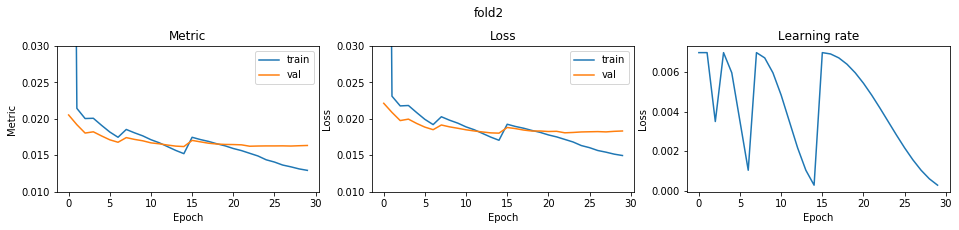

fold 3


epoch1 save best model... 0.020637928438213802
epoch2 save best model... 0.01885196581856265
epoch3 save best model... 0.018266809198385896
epoch4 save best model... 0.018065825550645113
epoch5 save best model... 0.01770539145984587
epoch6 save best model... 0.017266001341469873
epoch7 save best model... 0.016905095601339817
epoch12 save best model... 0.016738914207455644
epoch13 save best model... 0.016592442660098194
epoch14 save best model... 0.016464001388800307
epoch15 save best model... 0.016433787188473624
fold3 score: 0.016433786998125522


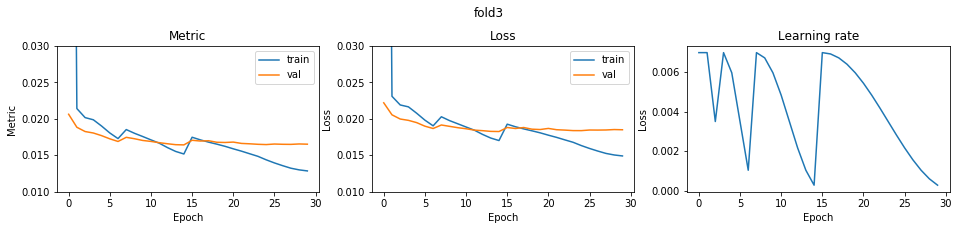

fold 4


epoch1 save best model... 0.02009826918940881
epoch2 save best model... 0.018672077144774056
epoch3 save best model... 0.017944113740905408
epoch4 save best model... 0.017811947875997745
epoch5 save best model... 0.01773178447122794
epoch6 save best model... 0.017103134913705204
epoch7 save best model... 0.016852487791711487
epoch12 save best model... 0.016652293024257945
epoch13 save best model... 0.01651005489552279
epoch14 save best model... 0.016467802792125657
epoch15 save best model... 0.016436663162650578
fold4 score: 0.016436663203966837


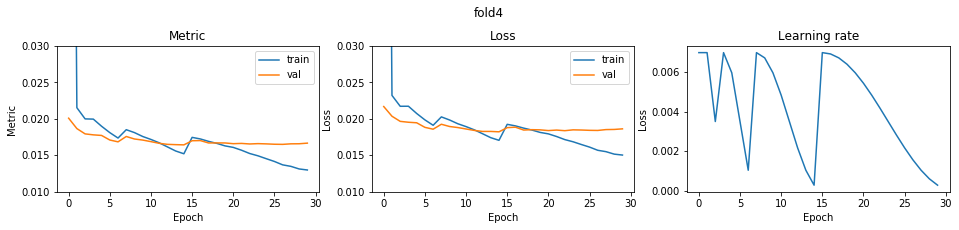

CV score: 0.016328286067569277

optimizer: Ranger
fold 0


epoch1 save best model... 0.021413188327553602
epoch2 save best model... 0.01956789505780422
epoch3 save best model... 0.018682850450107612
epoch4 save best model... 0.018227426489658128
epoch5 save best model... 0.017740801600463568
epoch6 save best model... 0.017291208578099695
epoch7 save best model... 0.01701643612312157
epoch10 save best model... 0.016870562334657394
epoch11 save best model... 0.01669451814306081
epoch12 save best model... 0.016544528433666956
epoch13 save best model... 0.01629036770187369
epoch14 save best model... 0.016197115130264287
epoch15 save best model... 0.016152248724208878
fold0 score: 0.016152248585120307


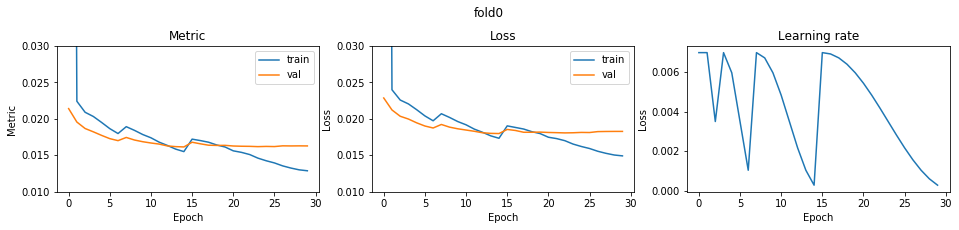

fold 1


epoch1 save best model... 0.02182060088830756
epoch2 save best model... 0.019553984689156406
epoch3 save best model... 0.018796896887062542
epoch4 save best model... 0.018368264373351973
epoch5 save best model... 0.017848540667005648
epoch6 save best model... 0.017434725111384792
epoch7 save best model... 0.017107246174990764
epoch10 save best model... 0.0170887194647723
epoch11 save best model... 0.016874864220442657
epoch12 save best model... 0.016639956233245917
epoch13 save best model... 0.016557110085197287
epoch14 save best model... 0.016458725236741602
epoch15 save best model... 0.016410443158156103
fold1 score: 0.016410443099253227


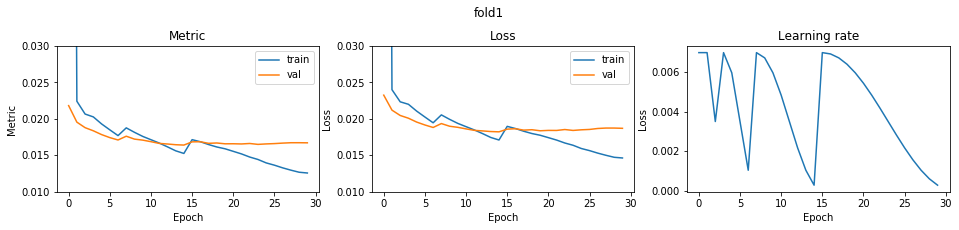

fold 2


epoch1 save best model... 0.021213365225157453
epoch2 save best model... 0.019863654864456706
epoch3 save best model... 0.01868188617113145
epoch4 save best model... 0.0183483027165773
epoch5 save best model... 0.01762398826962052
epoch6 save best model... 0.01726199154449021
epoch7 save best model... 0.01695672451484737
epoch11 save best model... 0.01667708075779545
epoch12 save best model... 0.016512031244242633
epoch13 save best model... 0.016379235752010078
epoch14 save best model... 0.01621922934807686
epoch15 save best model... 0.016186730368336583
fold2 score: 0.01618673023769361


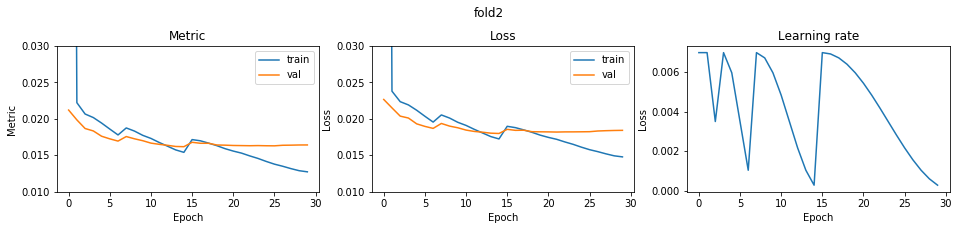

fold 3


epoch1 save best model... 0.021594691621924587
epoch2 save best model... 0.01975662219200224
epoch3 save best model... 0.018853877386362513
epoch4 save best model... 0.01832638571467378
epoch5 save best model... 0.017967302877040143
epoch6 save best model... 0.017373082127023258
epoch7 save best model... 0.017151951854348455
epoch10 save best model... 0.017100543636141306
epoch11 save best model... 0.016913163397198113
epoch12 save best model... 0.016661283855404968
epoch13 save best model... 0.016601088480569914
epoch14 save best model... 0.01649038178086756
epoch15 save best model... 0.016434941882509442
fold3 score: 0.01643494185940705


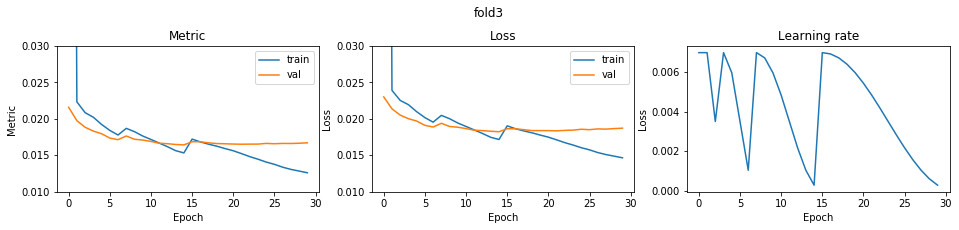

fold 4


epoch1 save best model... 0.02103923326082409
epoch2 save best model... 0.019285151283500678
epoch3 save best model... 0.018489043240208426
epoch4 save best model... 0.018035976632003903
epoch5 save best model... 0.017604205374243183
epoch6 save best model... 0.017201754001472017
epoch7 save best model... 0.017008556904173657
epoch11 save best model... 0.016788343696988662
epoch12 save best model... 0.01667710724954996
epoch13 save best model... 0.016509453047296046
epoch14 save best model... 0.01638398076575207
epoch15 save best model... 0.016373570296056315
fold4 score: 0.016373570280166158


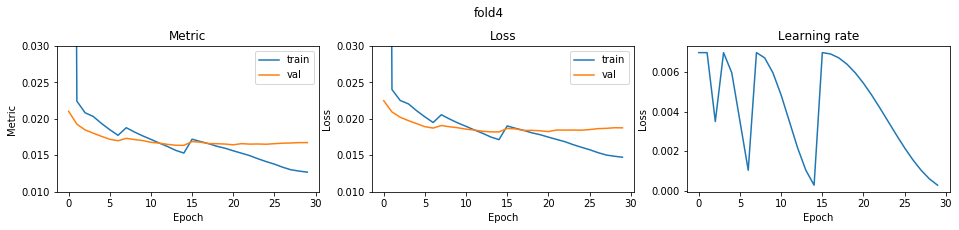

CV score: 0.016311587996959368

optimizer: RangerQH
fold 0


epoch1 save best model... 0.03144193725461026
fold0 score: 0.031441937192957965


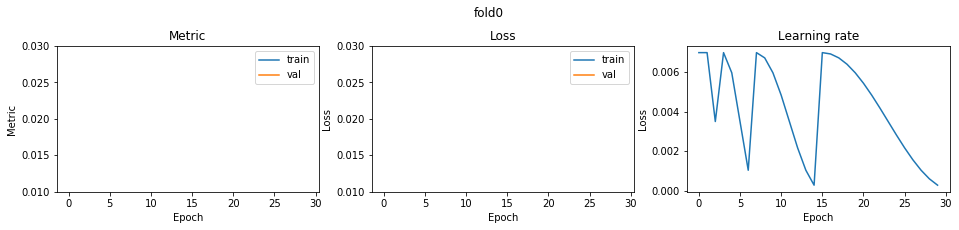

fold 1


epoch1 save best model... 0.031711044312406164
fold1 score: 0.031711044206958576


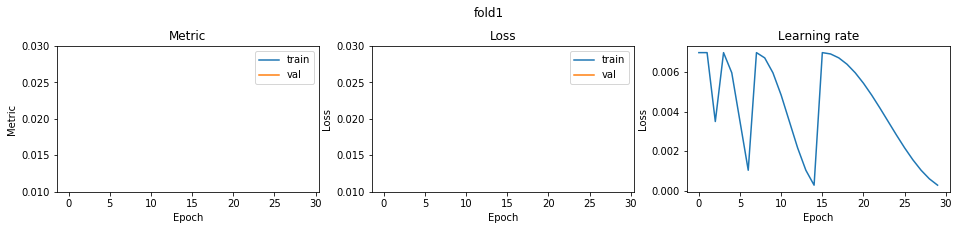

fold 2


epoch1 save best model... 0.031528690853214504
fold2 score: 0.03152869086340632


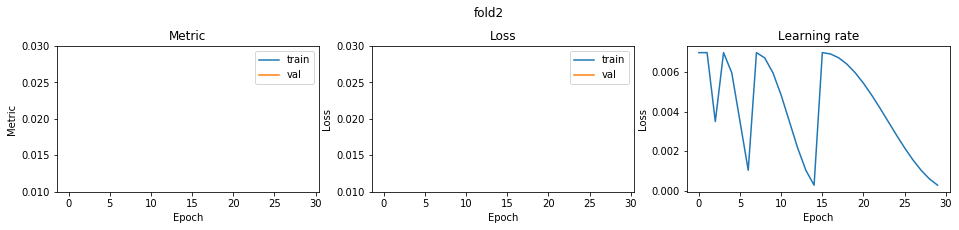

fold 3


epoch1 save best model... 0.03210303753207105
epoch6 save best model... 0.03208802700772508
epoch21 save best model... 0.03204559473011108
epoch22 save best model... 0.03196857531803208
epoch23 save best model... 0.031853909623344556
fold3 score: 0.03185390733320698


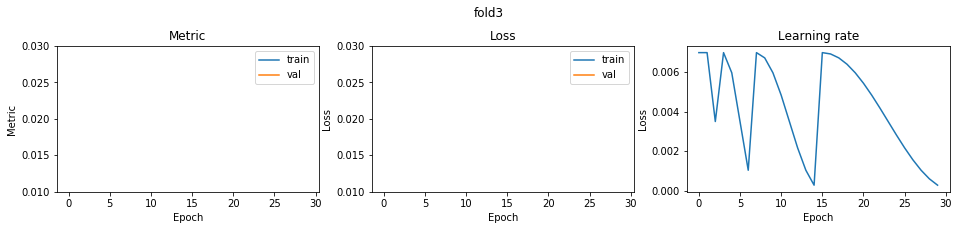

fold 4


epoch1 save best model... 0.0316432331724767
fold4 score: 0.0316432329045352


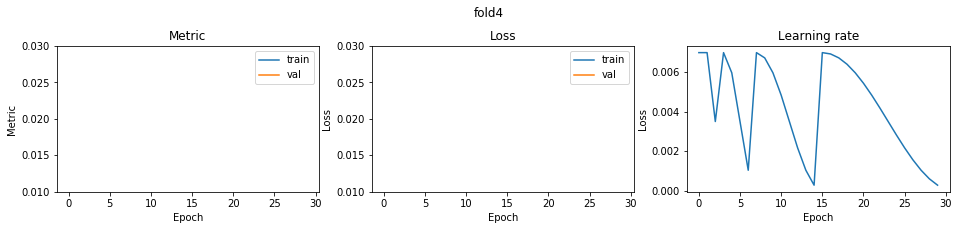

CV score: 0.031635763948633364

optimizer: RangerVA
fold 0


epoch1 save best model... 0.5341030567545011
epoch2 save best model... 0.05873881465922998
epoch3 save best model... 0.0349339247038397
epoch4 save best model... 0.024578611427973233
epoch5 save best model... 0.022492074912121192
epoch6 save best model... 0.021807047560946816
epoch7 save best model... 0.02170976799634839
epoch8 save best model... 0.020991272946866334
epoch9 save best model... 0.02057699141493555
epoch10 save best model... 0.020291535546981935
epoch11 save best model... 0.020151389728815788
epoch12 save best model... 0.02002921666619039
epoch13 save best model... 0.01992811732045067
epoch14 save best model... 0.019860089250367162
epoch15 save best model... 0.01985725477626356
epoch16 save best model... 0.01967690833897281
epoch17 save best model... 0.019487122956298477
epoch18 save best model... 0.0193382802417243
epoch19 save best model... 0.019160850713525926
epoch20 save best model... 0.01908556797917177
epoch21 save best model... 0.018919895961880685
epoch22 save be

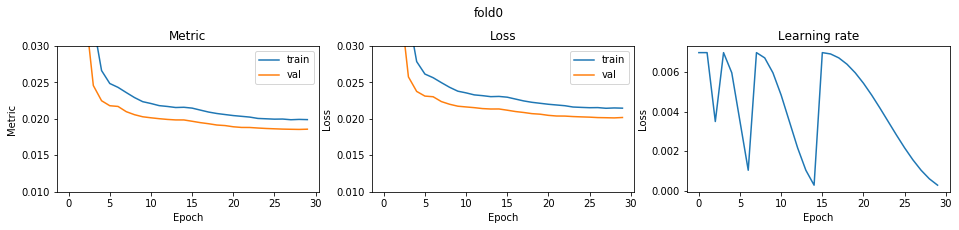

fold 1


epoch1 save best model... 0.5411678660320621
epoch2 save best model... 0.059996366765673485
epoch3 save best model... 0.03484677802707672
epoch4 save best model... 0.024568017026824134
epoch5 save best model... 0.022443672035659303
epoch6 save best model... 0.021860071292198392
epoch7 save best model... 0.021741603951206046
epoch8 save best model... 0.021038473487633675
epoch9 save best model... 0.020609209852538855
epoch10 save best model... 0.020351970966376566
epoch11 save best model... 0.0202846488458953
epoch12 save best model... 0.02006507047007909
epoch13 save best model... 0.01998445022987882
epoch14 save best model... 0.019895331634051112
epoch16 save best model... 0.01974166417908196
epoch17 save best model... 0.019587912279106702
epoch18 save best model... 0.01944990184452613
epoch19 save best model... 0.01925781456718387
epoch20 save best model... 0.019206267726172833
epoch21 save best model... 0.019093291612889886
epoch22 save best model... 0.018982273451585003
epoch23 sav

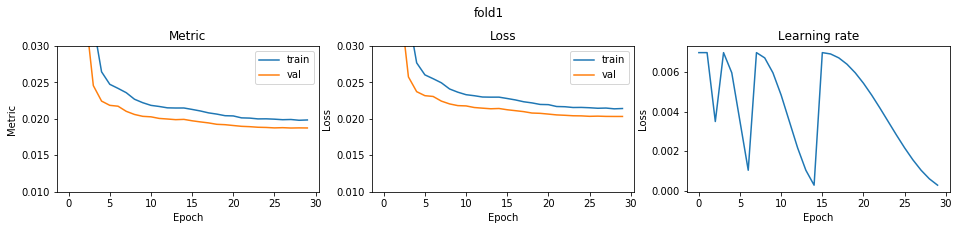

fold 2


epoch1 save best model... 0.5376991072665805
epoch2 save best model... 0.05908120265343
epoch3 save best model... 0.035050809048124694
epoch4 save best model... 0.02482777706536896
epoch5 save best model... 0.02256565760947572
epoch6 save best model... 0.021967616222084152
epoch7 save best model... 0.0218172046368847
epoch8 save best model... 0.02109921855589311
epoch9 save best model... 0.02078078097501915
epoch10 save best model... 0.020495084192672576
epoch11 save best model... 0.02027583526569215
epoch12 save best model... 0.020150279626674657
epoch13 save best model... 0.02014276126175134
epoch14 save best model... 0.02003101438350125
epoch16 save best model... 0.019835399177309917
epoch17 save best model... 0.01967690229767288
epoch18 save best model... 0.01953547272986528
epoch19 save best model... 0.019315044885583173
epoch20 save best model... 0.019226672489847076
epoch21 save best model... 0.019104112543574796
epoch22 save best model... 0.0189924647710754
epoch23 save best mo

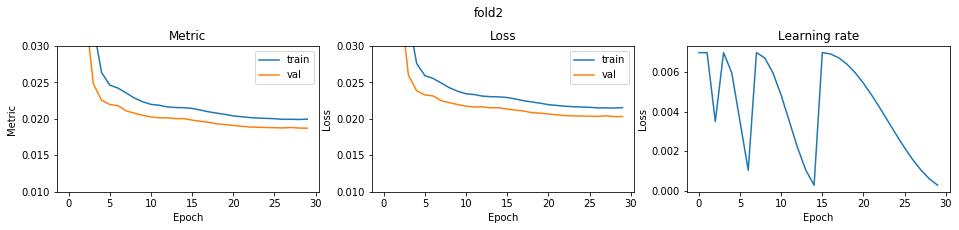

fold 3


epoch1 save best model... 0.5241409454910522
epoch2 save best model... 0.057208520683177784
epoch3 save best model... 0.034397879391399495
epoch4 save best model... 0.0246820129157131
epoch5 save best model... 0.02272771304401151
epoch6 save best model... 0.02196643231330537
epoch7 save best model... 0.021850905984063085
epoch8 save best model... 0.02125507548943603
epoch9 save best model... 0.02087035635083167
epoch10 save best model... 0.020641447301606112
epoch11 save best model... 0.020420594724289785
epoch12 save best model... 0.02032743270608654
epoch13 save best model... 0.020273311030128142
epoch14 save best model... 0.020222999340088737
epoch16 save best model... 0.019995936583770028
epoch17 save best model... 0.01984566851033233
epoch18 save best model... 0.019677107981437975
epoch19 save best model... 0.01949290504556039
epoch20 save best model... 0.019406884430498223
epoch21 save best model... 0.019272270643816314
epoch22 save best model... 0.01917691404564234
epoch23 save 

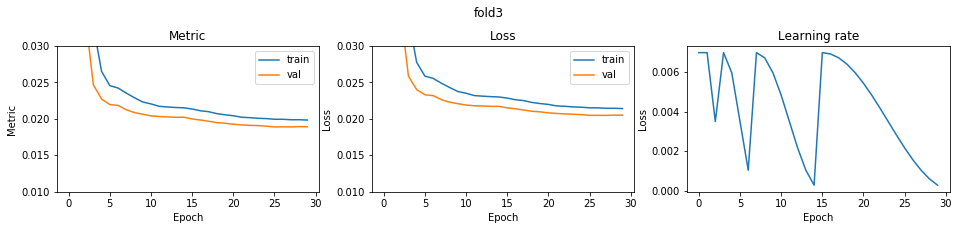

fold 4


epoch1 save best model... 0.53228230055481
epoch2 save best model... 0.05819294546181357
epoch3 save best model... 0.03389240026321254
epoch4 save best model... 0.02424783402277424
epoch5 save best model... 0.02236489026652382
epoch6 save best model... 0.02173437830951735
epoch7 save best model... 0.02159585249705711
epoch8 save best model... 0.021026354907653325
epoch9 save best model... 0.02054257397720238
epoch10 save best model... 0.02026801664288875
epoch11 save best model... 0.020098501037390467
epoch12 save best model... 0.020035090186295856
epoch13 save best model... 0.01990903245883406
epoch16 save best model... 0.019725210852666434
epoch17 save best model... 0.019551705813421475
epoch18 save best model... 0.019438897576480086
epoch19 save best model... 0.019238407970119716
epoch20 save best model... 0.019127959553534187
epoch21 save best model... 0.019035898221991872
epoch22 save best model... 0.018954755107878554
epoch23 save best model... 0.018844208665667335
epoch24 save b

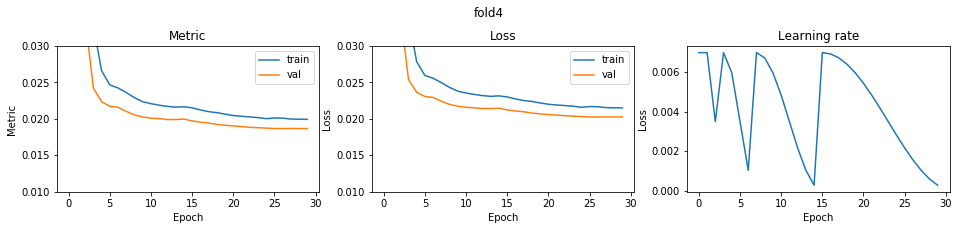

CV score: 0.018721257813392414

optimizer: SWATS
fold 0


epoch1 save best model... 0.031114464329559874
fold0 score: 0.031114464267957675


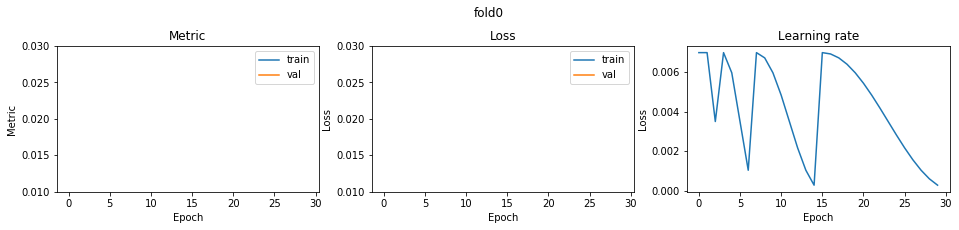

fold 1


epoch1 save best model... 0.03096112182483121
fold1 score: 0.030961121790154873


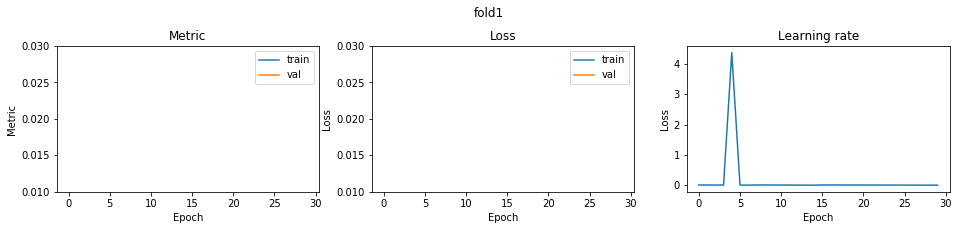

fold 2


epoch1 save best model... 0.031143150124915316
fold2 score: 0.031143150093055013


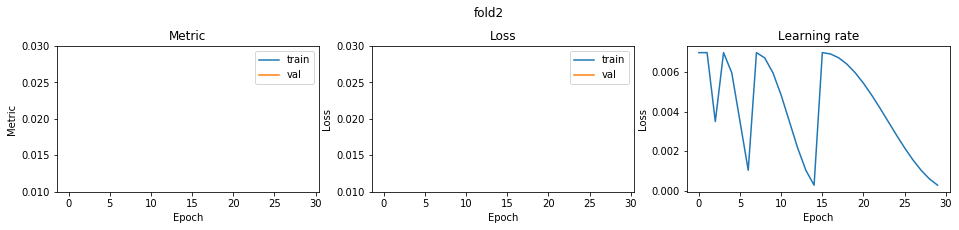

fold 3


epoch1 save best model... 0.031063105838886697
fold3 score: 0.031063105732937368


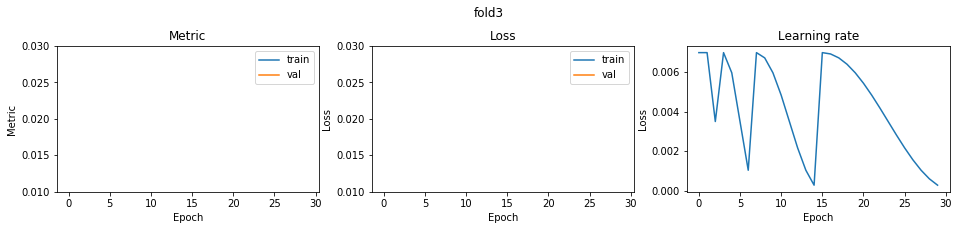

fold 4


epoch1 save best model... 0.03079692870972504
fold4 score: 0.030796928505008914


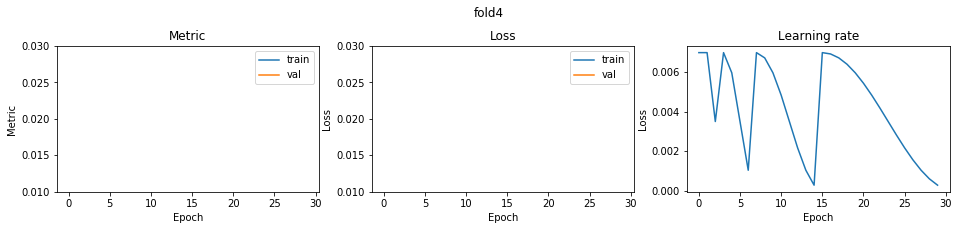

CV score: 0.031015750762544494

optimizer: Yogi
fold 0


epoch1 save best model... 0.031010195856451445
fold0 score: 0.031010195717106344


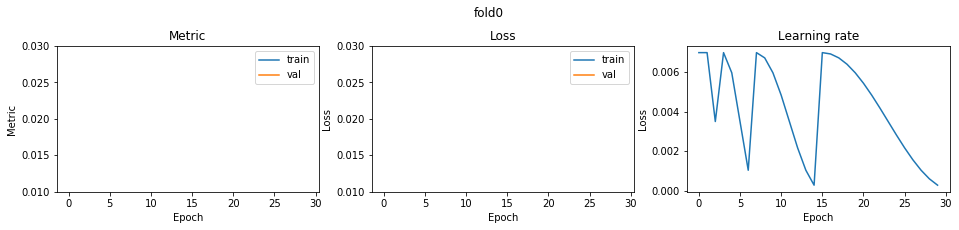

fold 1


epoch1 save best model... 0.03085473847381752
fold1 score: 0.030854738640295715


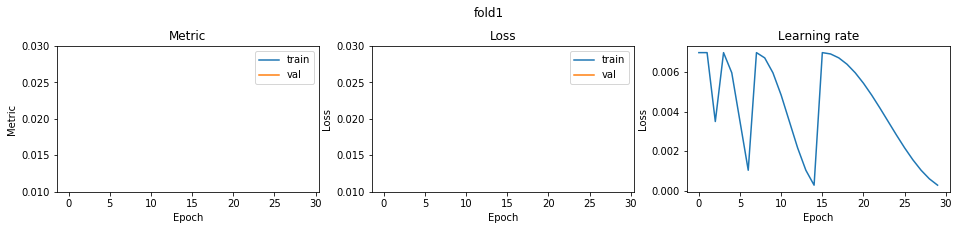

fold 2


epoch1 save best model... 0.031016398730097258
fold2 score: 0.031016398587571783


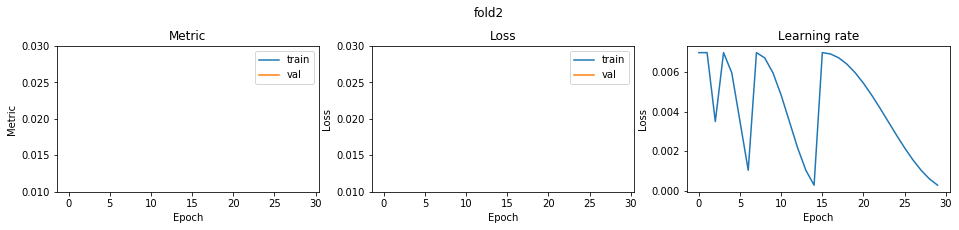

fold 3


epoch1 save best model... 0.031051056270311524
fold3 score: 0.031051056192036304


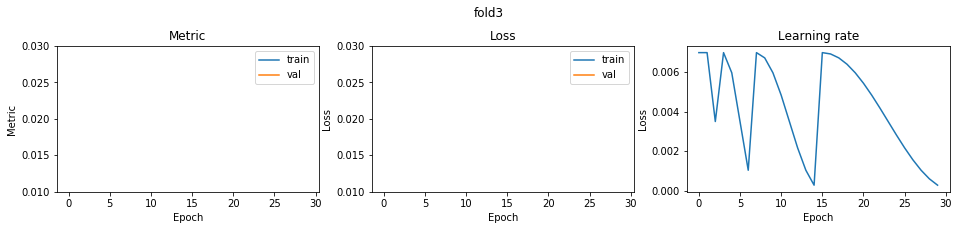

fold 4


epoch1 save best model... 0.030993465447038886
fold4 score: 0.030993465475698277


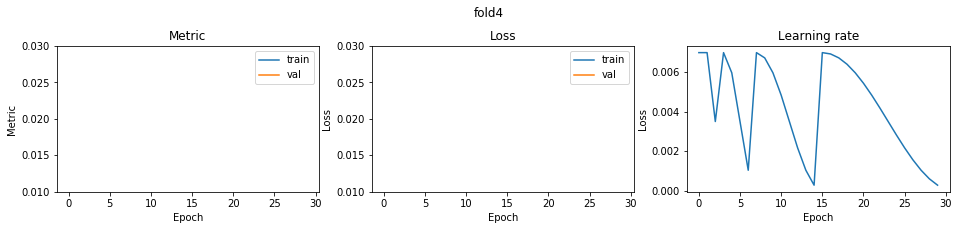

CV score: 0.030985175442526065

optimizer: Adam
fold 0


epoch1 save best model... 0.031946653128518875
epoch4 save best model... 0.03179952521174128
epoch22 save best model... 0.031609053712058174
fold0 score: 0.03160905233000102


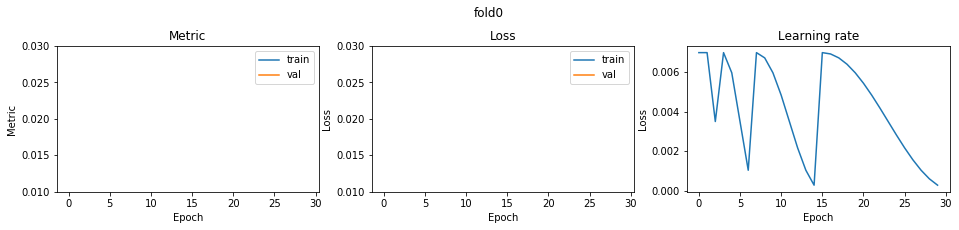

fold 1


epoch1 save best model... 0.031976906657830054
epoch13 save best model... 0.03189455042258974
epoch25 save best model... 0.03174821175015252
fold1 score: 0.03174821235903583


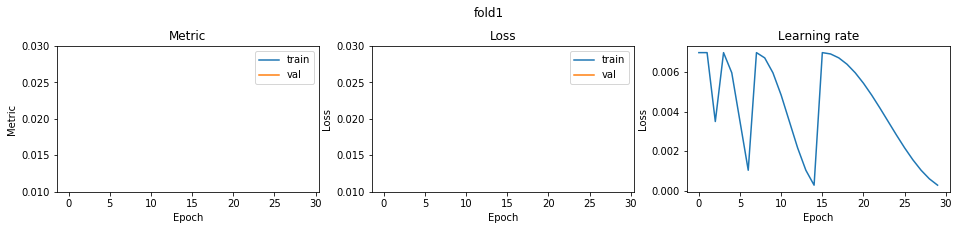

fold 2


epoch1 save best model... 0.031941081815895556
epoch18 save best model... 0.031379862245207064
fold2 score: 0.0313798619984692


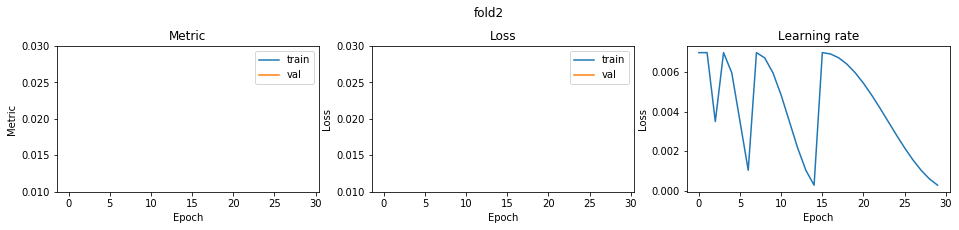

fold 3


epoch1 save best model... 0.03182400782127994
epoch21 save best model... 0.031791516569080275
fold3 score: 0.03179151685096692


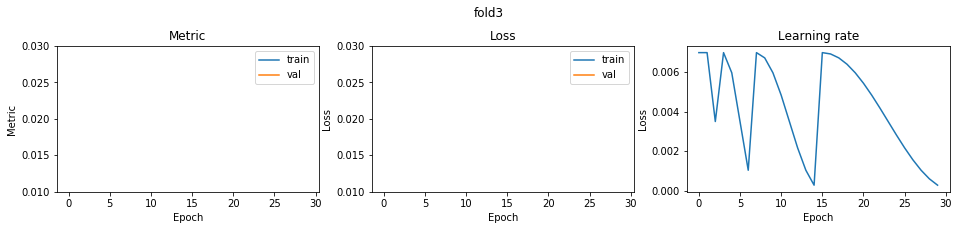

fold 4


epoch1 save best model... 0.03228572195985594
epoch4 save best model... 0.03169484481826459
epoch22 save best model... 0.03161234072746883
fold4 score: 0.03161233883824757


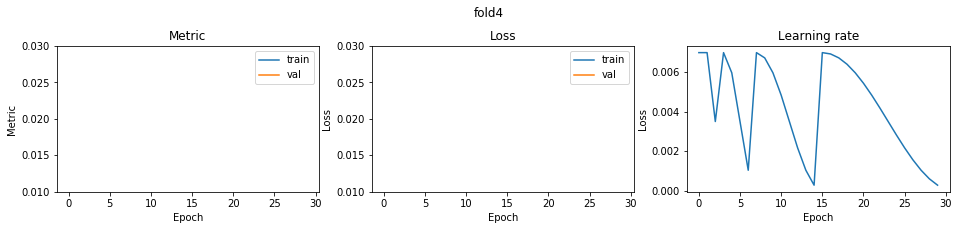

CV score: 0.03162820232182639

optimizer: LookaheadAdam
fold 0


epoch1 save best model... 0.031227423665633507
fold0 score: 0.031227423649614176


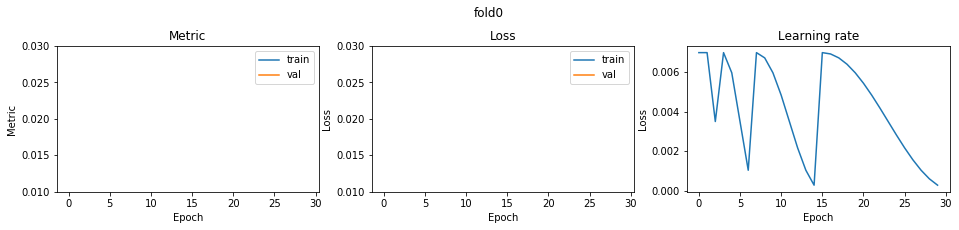

fold 1


epoch1 save best model... 0.03172166035000271
epoch26 save best model... 0.03157983948454332
fold1 score: 0.031579837655561216


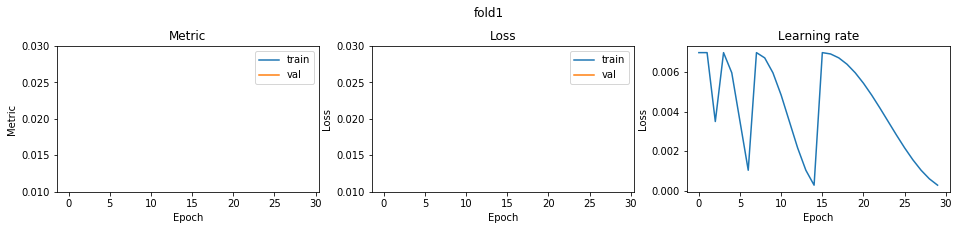

fold 2


epoch1 save best model... 0.031323804877194245
fold2 score: 0.0313238048708741


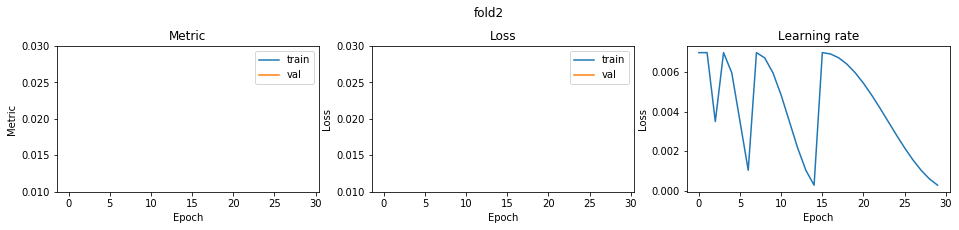

fold 3


epoch1 save best model... 0.03186426096954351
epoch16 save best model... 0.03181381789640712
epoch19 save best model... 0.03166788614912973
fold3 score: 0.031667883658008635


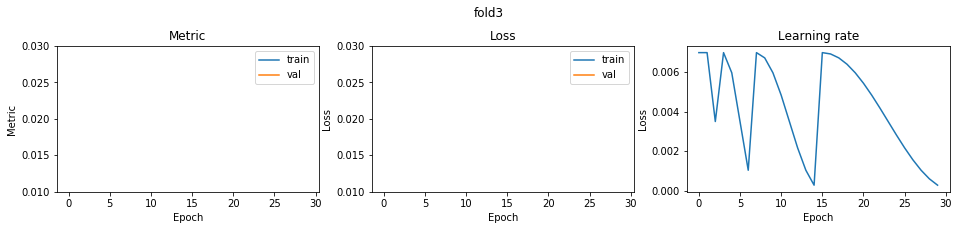

fold 4


epoch1 save best model... 0.03187326012022267
epoch10 save best model... 0.03166254707410558
epoch12 save best model... 0.03164167738687205
fold4 score: 0.031641679349642744


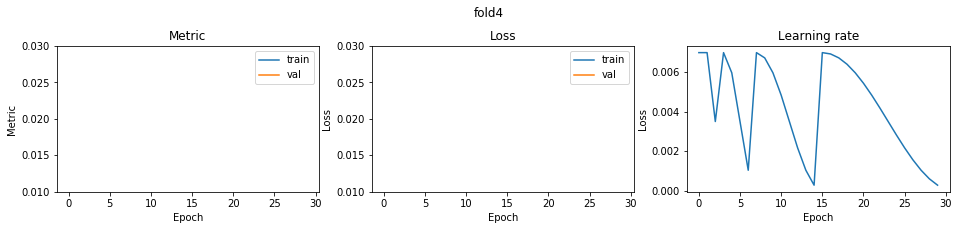

CV score: 0.03148812914497541

optimizer: LookaheadDiffGrad
fold 0


epoch1 save best model... 0.03395185788291462
epoch2 save best model... 0.03174128133913922
epoch3 save best model... 0.03164581882519168
fold0 score: 0.031645818786035694


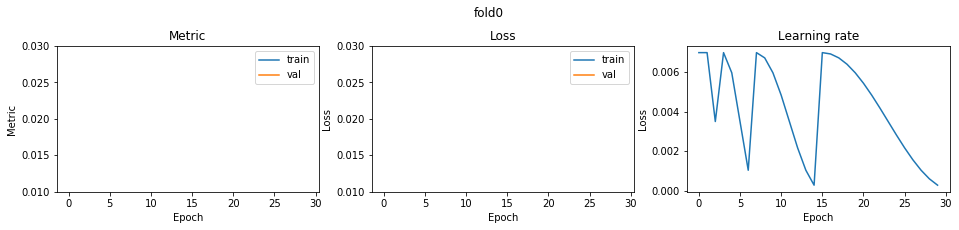

fold 1


epoch1 save best model... 0.03296978914536031
epoch2 save best model... 0.03128759857834974
fold1 score: 0.031287598632338806


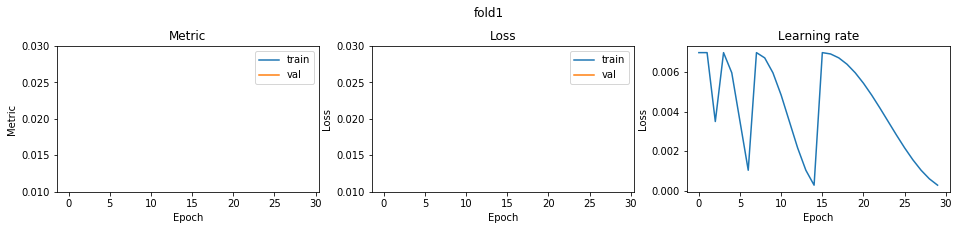

fold 2


epoch1 save best model... 0.03396926895904362
epoch2 save best model... 0.031147578418404237
fold2 score: 0.031147578459715657


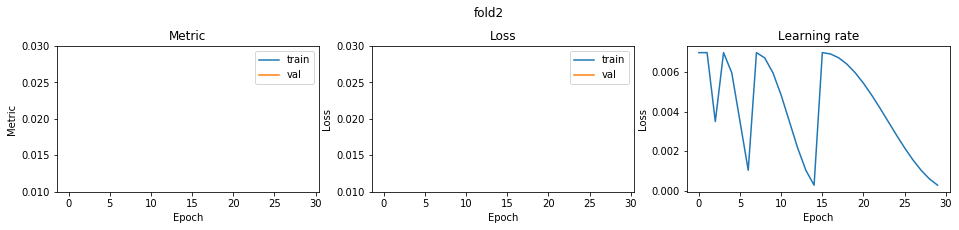

fold 3


epoch1 save best model... 0.03398074476909665
epoch2 save best model... 0.03162445981641022
fold3 score: 0.03162445973093959


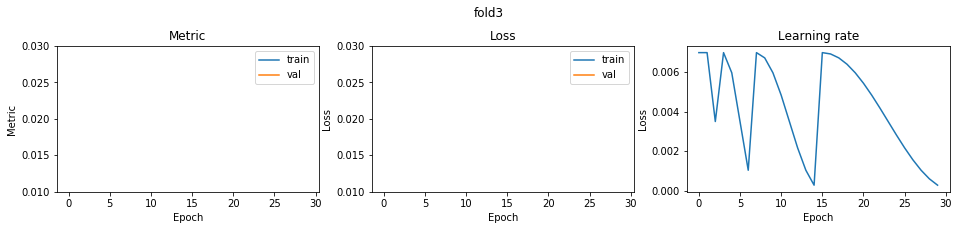

fold 4


epoch1 save best model... 0.0331178108005358
epoch2 save best model... 0.03141870557973352
epoch3 save best model... 0.03127462366905598
fold4 score: 0.03127462359539076


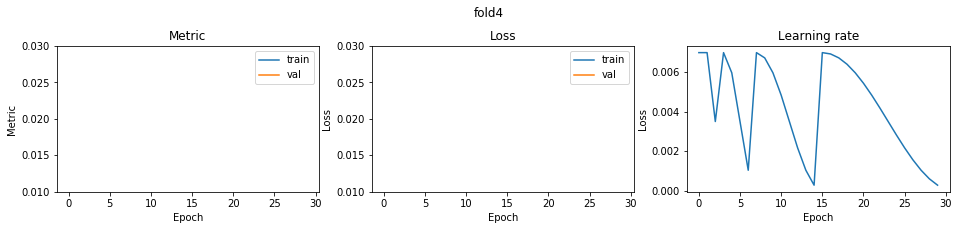

CV score: 0.03139603209997786

optimizer: LookaheadYogi
fold 0


epoch1 save best model... 0.03136042080446229
epoch2 save best model... 0.03089158297399725
fold0 score: 0.030891583046039634


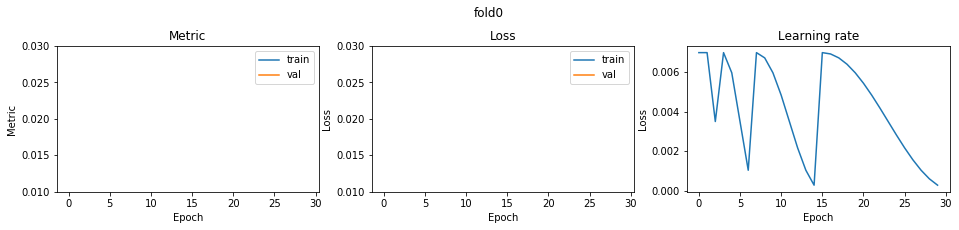

fold 1


epoch1 save best model... 0.03098092830297914
epoch2 save best model... 0.03092606855001692
fold1 score: 0.030926068440884615


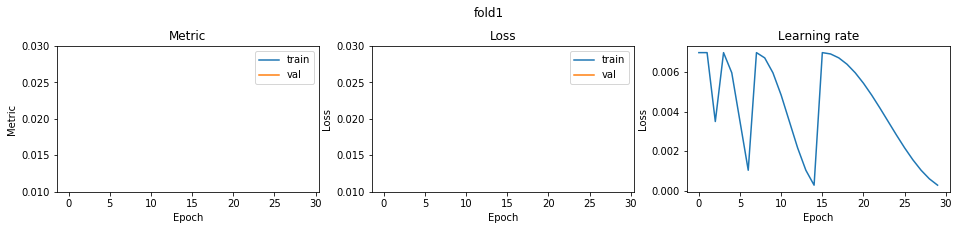

fold 2


epoch1 save best model... 0.03118274891042416
epoch2 save best model... 0.030999978582845186
fold2 score: 0.030999978632158018


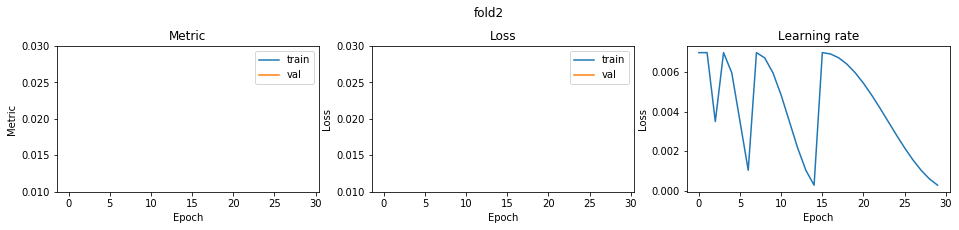

fold 3


epoch1 save best model... 0.03147116116670243
epoch2 save best model... 0.030948230729423515
fold3 score: 0.0309482307052983


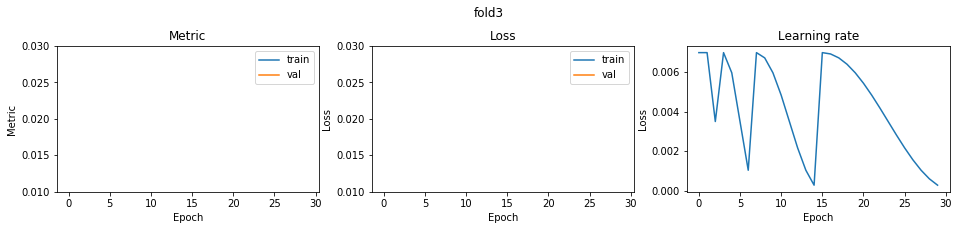

fold 4


epoch1 save best model... 0.031073060101386083
epoch2 save best model... 0.03075842983545502
fold4 score: 0.03075842986958592


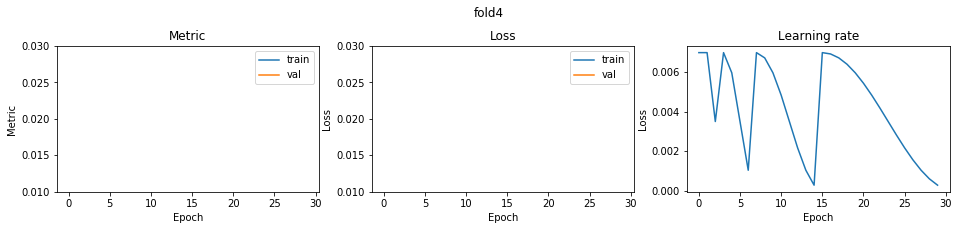

CV score: 0.030904852838501907


In [25]:
score_dict = {}

for optimizer in optim_list:
    CFG.optimizer = optimizer
    logger.info('')
    logger.info('optimizer: '+ optimizer.__name__)
    oof, predictions = run_kfold_nn(CFG,
                                    trn_df,
                                    test_df,
                                    CFG.feature_cols,
                                    CFG.target_cols,
                                    n_fold=5)

    # OOF score without 'ctl_vehicle'
    ys = trn_df[y_keys]
    preds = oof

    score = compute_metric(preds, ys)
    score_dict[optimizer.__name__] = score

In [26]:
logger.info(pd.DataFrame.from_dict(score_dict, columns=['metric'], orient='index'))
pd.DataFrame.from_dict(score_dict, columns=['metric'], orient='index')

                     metric
Adam_CG            0.031739
AdamW_CG           0.016363
PlainRAdam_CG      0.021395
RAdam_CG           0.016346
Ranger_CG          0.016396
AggMo              0.030181
Apollo             0.476922
PID                0.477446
QHM                0.482584
SGDP               0.479691
SGDW               0.151372
SGD                0.484685
AdaBelief          0.016303
AdaBound           0.030452
AdaMod             0.016261
AdamW              0.016296
AdamP              0.016300
DiffGrad           0.031619
Lamb               0.016419
NovoGrad           0.016300
PlainRAdam         0.016316
QHAdam             0.031712
RAdam              0.016328
Ranger             0.016312
RangerQH           0.031636
RangerVA           0.018721
SWATS              0.031016
Yogi               0.030985
Adam               0.031628
LookaheadAdam      0.031488
LookaheadDiffGrad  0.031396
LookaheadYogi      0.030905


metric
Adam_CG            0.031739
AdamW_CG           0.016363
PlainRAdam_CG      0.021395
RAdam_CG           0.016346
Ranger_CG          0.016396
AggMo              0.030181
Apollo             0.476922
PID                0.477446
QHM                0.482584
SGDP               0.479691
SGDW               0.151372
SGD                0.484685
AdaBelief          0.016303
AdaBound           0.030452
AdaMod             0.016261
AdamW              0.016296
AdamP              0.016300
DiffGrad           0.031619
Lamb               0.016419
NovoGrad           0.016300
PlainRAdam         0.016316
QHAdam             0.031712
RAdam              0.016328
Ranger             0.016312
RangerQH           0.031636
RangerVA           0.018721
SWATS              0.031016
Yogi               0.030985
Adam               0.031628
LookaheadAdam      0.031488
LookaheadDiffGrad  0.031396
LookaheadYogi      0.030905

In [27]:
sort_dict = {k: v for k, v in sorted(score_dict.items(), key=lambda x: x[1])}
logger.info(pd.DataFrame.from_dict(sort_dict, columns=['metric'], orient='index'))
pd.DataFrame.from_dict(sort_dict, columns=['metric'], orient='index')

                     metric
AdaMod             0.016261
AdamW              0.016296
AdamP              0.016300
NovoGrad           0.016300
AdaBelief          0.016303
Ranger             0.016312
PlainRAdam         0.016316
RAdam              0.016328
RAdam_CG           0.016346
AdamW_CG           0.016363
Ranger_CG          0.016396
Lamb               0.016419
RangerVA           0.018721
PlainRAdam_CG      0.021395
AggMo              0.030181
AdaBound           0.030452
LookaheadYogi      0.030905
Yogi               0.030985
SWATS              0.031016
LookaheadDiffGrad  0.031396
LookaheadAdam      0.031488
DiffGrad           0.031619
Adam               0.031628
RangerQH           0.031636
QHAdam             0.031712
Adam_CG            0.031739
SGDW               0.151372
Apollo             0.476922
PID                0.477446
SGDP               0.479691
QHM                0.482584
SGD                0.484685


metric
AdaMod             0.016261
AdamW              0.016296
AdamP              0.016300
NovoGrad           0.016300
AdaBelief          0.016303
Ranger             0.016312
PlainRAdam         0.016316
RAdam              0.016328
RAdam_CG           0.016346
AdamW_CG           0.016363
Ranger_CG          0.016396
Lamb               0.016419
RangerVA           0.018721
PlainRAdam_CG      0.021395
AggMo              0.030181
AdaBound           0.030452
LookaheadYogi      0.030905
Yogi               0.030985
SWATS              0.031016
LookaheadDiffGrad  0.031396
LookaheadAdam      0.031488
DiffGrad           0.031619
Adam               0.031628
RangerQH           0.031636
QHAdam             0.031712
Adam_CG            0.031739
SGDW               0.151372
Apollo             0.476922
PID                0.477446
SGDP               0.479691
QHM                0.482584
SGD                0.484685

In [28]:
pd.DataFrame.from_dict(sort_dict, columns=['metric'], orient='index').to_csv(nb_name[:-6]+'.csv')